In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')
import os
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, DenseGCNConv, dense_diff_pool
import torch_explain as te
from torch_explain.logic.nn import entropy
from torch_explain.logic.metrics import test_explanation, complexity

import numpy as np
import pandas as pd
from pytorch_lightning.utilities.seed import seed_everything
from scipy.spatial.distance import cdist
from sympy import to_dnf, lambdify
from sklearn.metrics.cluster import homogeneity_score, completeness_score

import clustering_utils
import data_utils
import lens_utils
import model_utils
import persistence_utils
import visualisation_utils
import models

In [3]:
# constants
DATASET_NAME = "Tree_Grid"
MODEL_NAME = f"GCN for {DATASET_NAME}"
NUM_CLASSES = 2

TRAIN_TEST_SPLIT = 0.8
EPOCHS = 1000

visualisation_utils.set_rc_params()

In [ ]:
class Tree_Grid_GCN(nn.Module):
    def __init__(self, num_in_features, num_hidden_features, num_classes, n_clustering=3, concept_emb_size=4):
        super(Tree_Grid_GCN, self).__init__()

        self.conv0 = GCNConv(num_in_features, num_hidden_features)
        self.conv1 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv2 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv3 = GCNConv(num_hidden_features, num_hidden_features)
        self.conv4 = DenseGCNConv(num_hidden_features, num_hidden_features)
        self.conv5 = DenseGCNConv(num_hidden_features, num_hidden_features)
        self.conv6 = DenseGCNConv(num_hidden_features, num_hidden_features)

        self.ce_layer = ConceptEmbeddings(num_hidden_features, n_clustering, concept_emb_size)
        self.lens = torch.nn.Sequential(EntropyLinear(n_clustering, 1, n_classes=num_classes),
                                        nn.LeakyReLU(),
                                        torch.nn.Linear(concept_emb_size, 1))

    def forward(self, x, edge_index):
        x = self.conv0(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv1(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv2(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv3(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv4(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv5(x, edge_index)
        x = F.leaky_relu(x)

        x = self.conv6(x, edge_index)
        x = F.leaky_relu(x)

        self.gnn_embedding = x

        x = F.softmax(x, dim=-1)
        x = torch.div(x, torch.max(x, dim=-1)[0].unsqueeze(1))
        concepts = x
        
        x = self.linear(x)
                
        return concepts, x.squeeze(-1)

In [4]:
def run_grid_search(data, lr, hidden_units, n_clustering, concept_emb_size, path):    
    # model training
    model = models.Tree_Grid_GCN(data["x"].shape[1], hidden_units, NUM_CLASSES, n_clustering, concept_emb_size)
    
    # train 
    train_acc, test_acc, train_loss, test_loss = model_utils.train(model, data, EPOCHS, lr)
        
    visualisation_utils.plot_model_accuracy(train_acc, test_acc, MODEL_NAME, path)
    visualisation_utils.plot_model_loss(train_loss, test_loss, MODEL_NAME, path)
    
    x = data["x"]
    edges = data['edges'].long()
    y = data["y"]
    train_mask = data["train_mask"]
    test_mask = data["test_mask"]
    
    # generate explanations
    concepts, _ = model(x, edges)
    explanations = lens_utils.explain_classes(model, concepts, y, train_mask, test_mask)
    
    # clean up
    plt.close()

Global seed set to 42


Task: Node Classification
Number of features:  1231
Number of labels:  1231
Number of classes:  1231
Number of edges:  1231

START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 10, n_clustering: 2, concept_emb_size: 5


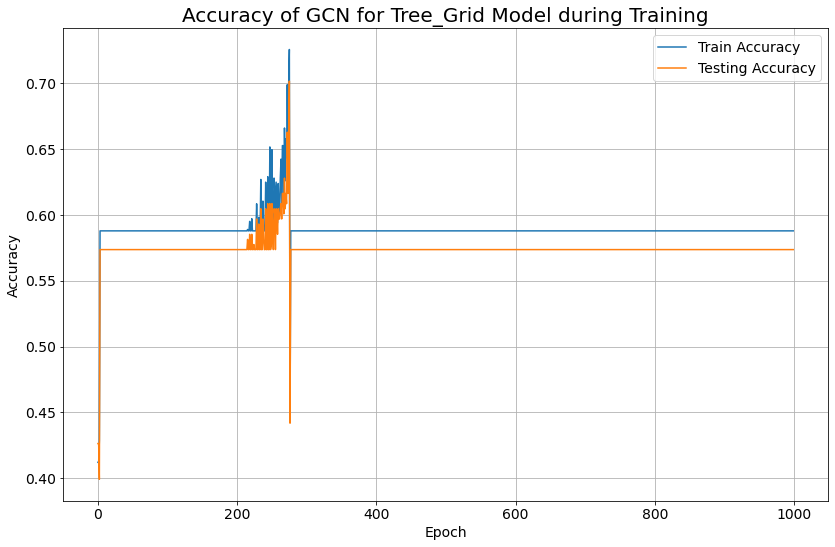

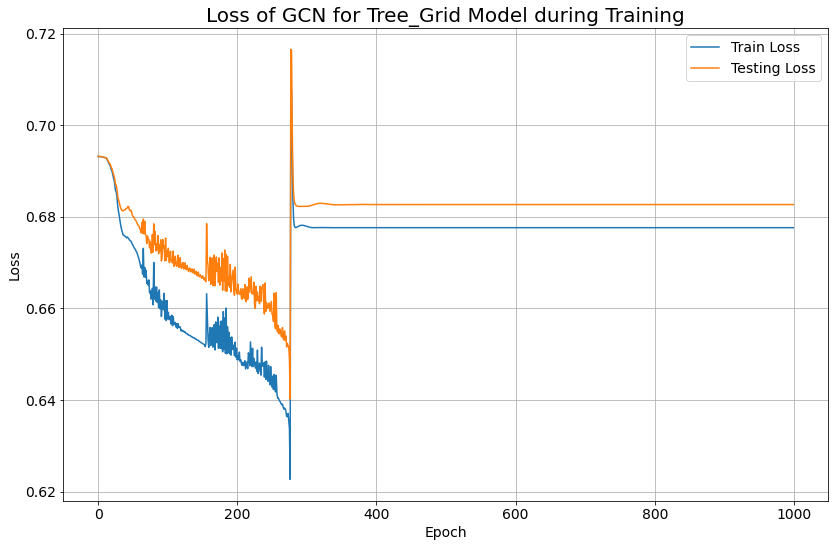

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 10, n_clustering: 2, concept_emb_size: 10


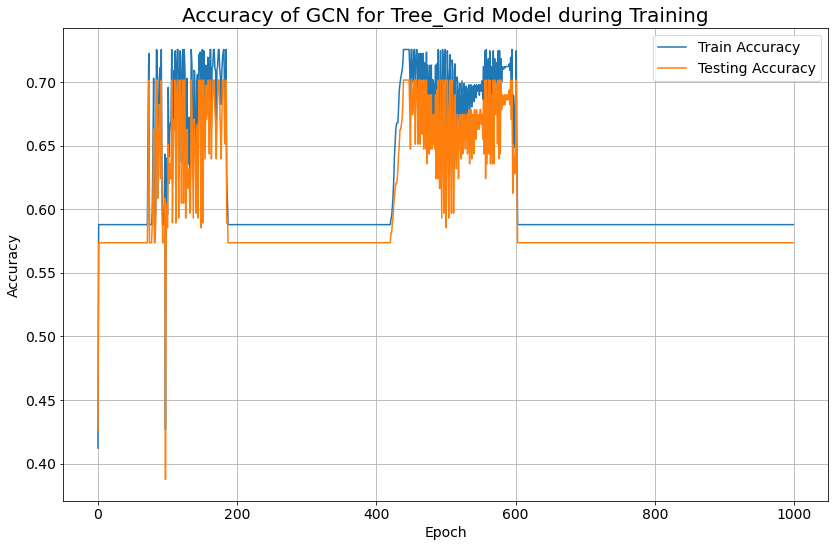

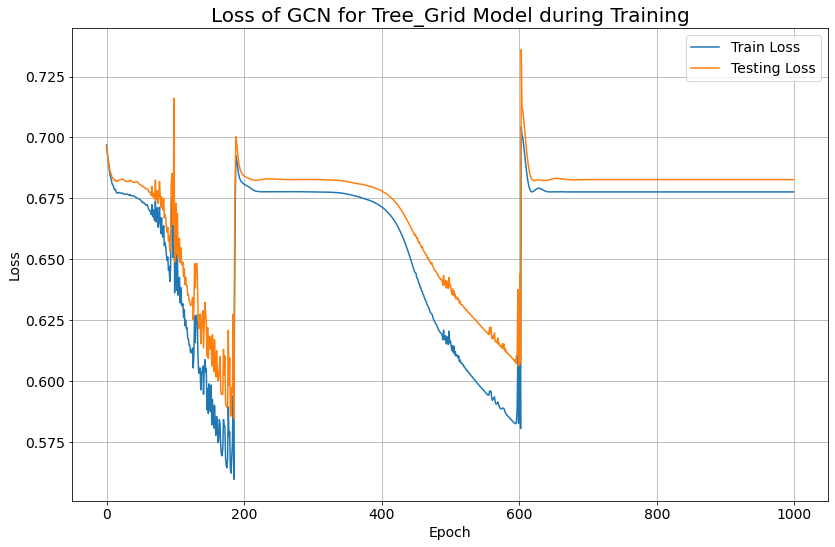

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 10, n_clustering: 2, concept_emb_size: 20


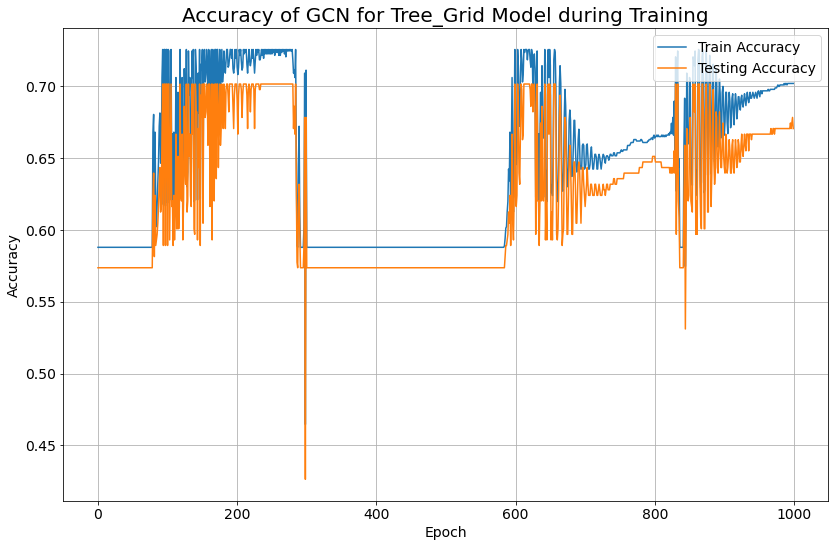

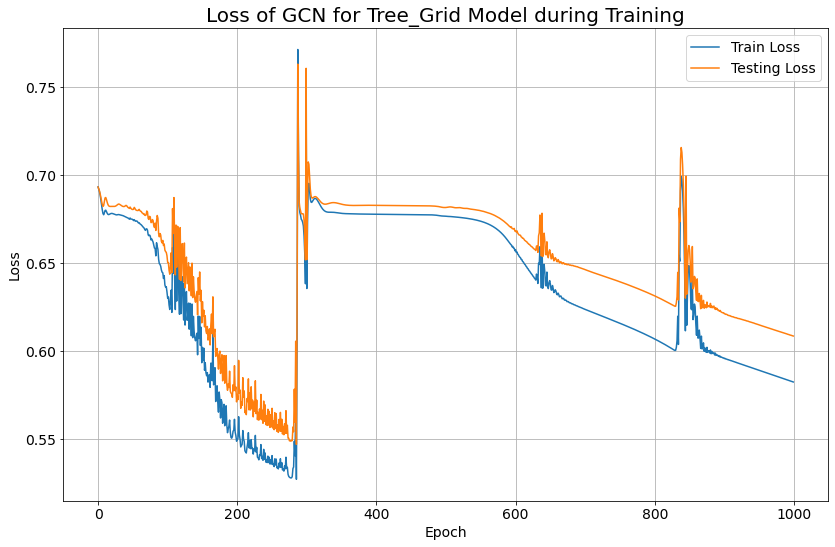

Explanation class 0: ~feature0000000001_0000000016 - acc. = 0.3645 - compl. = 1.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 10, n_clustering: 3, concept_emb_size: 5


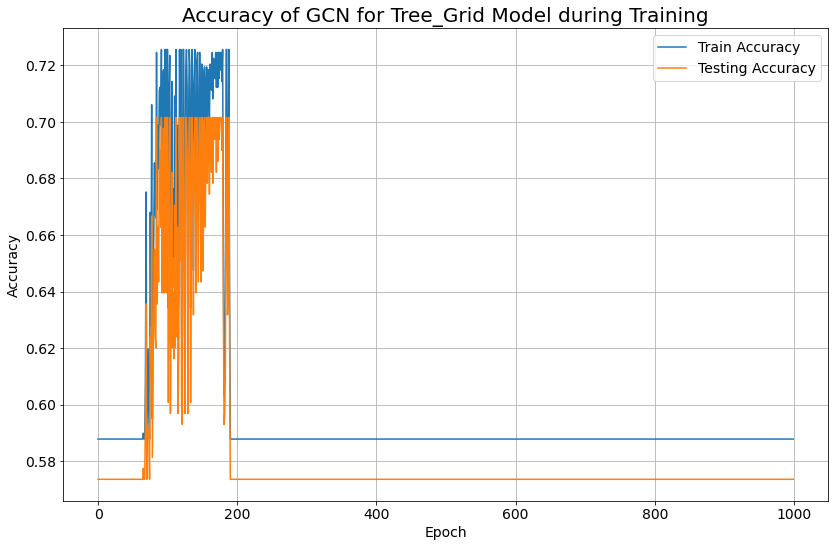

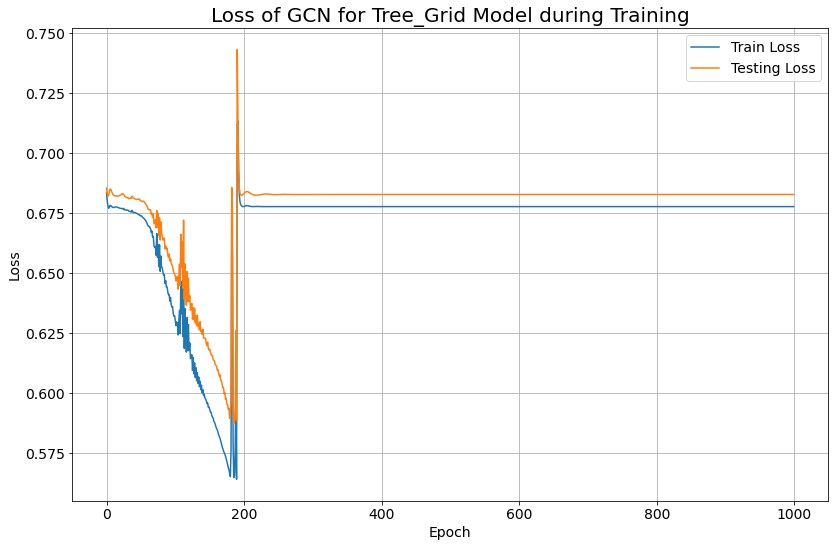

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 10, n_clustering: 3, concept_emb_size: 10


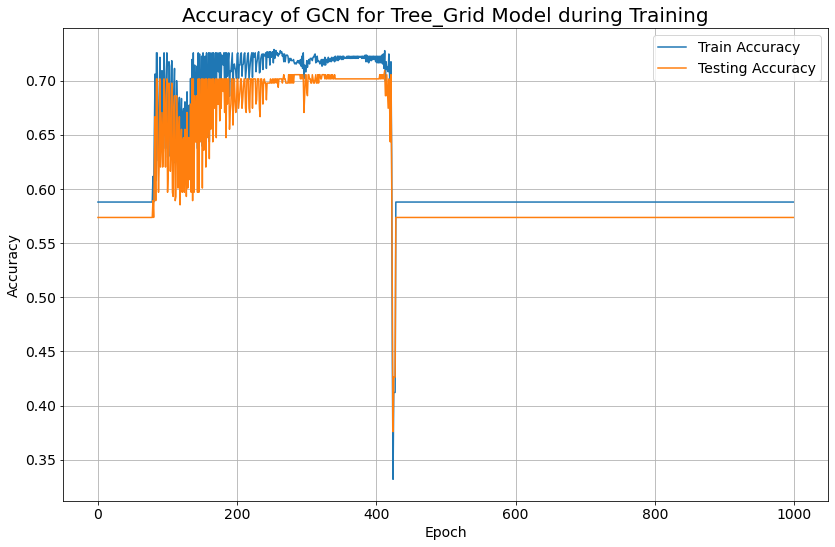

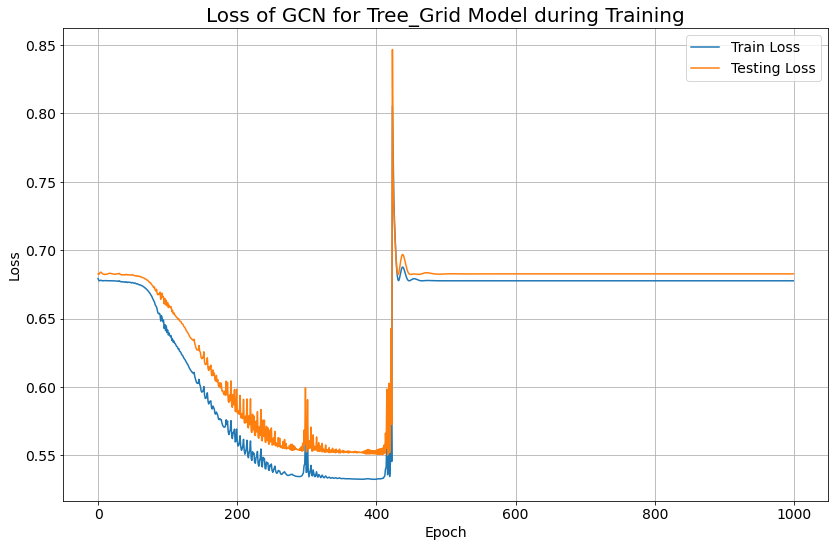

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 10, n_clustering: 3, concept_emb_size: 20


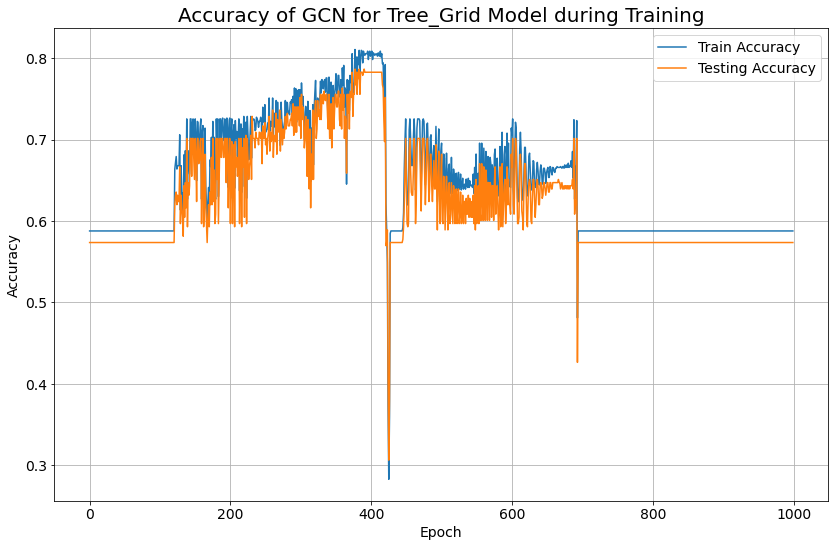

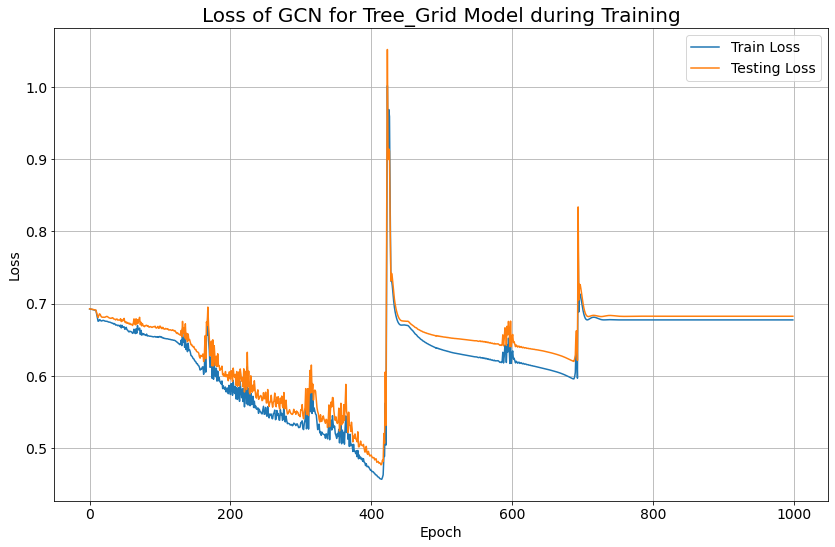

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 10, n_clustering: 4, concept_emb_size: 5


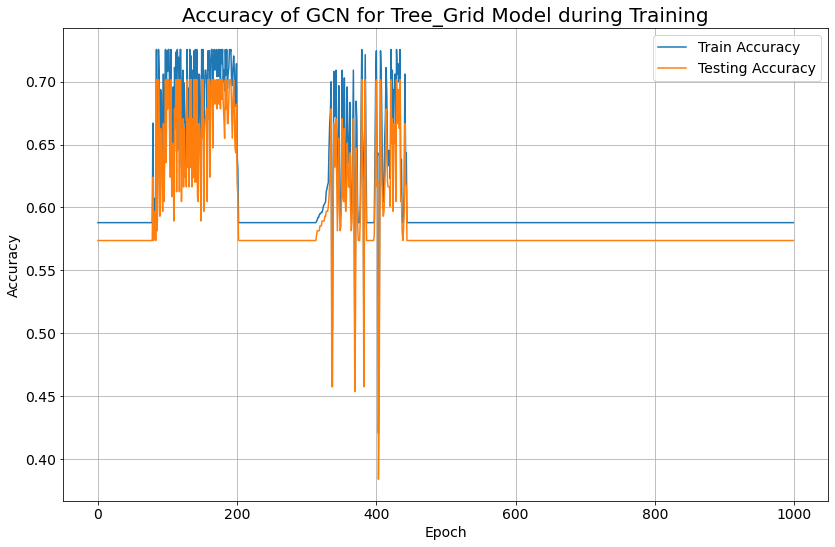

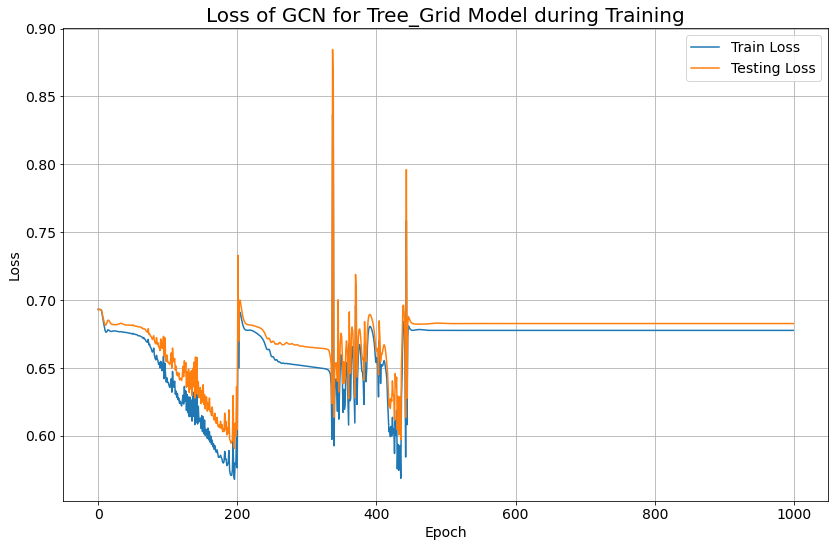

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 10, n_clustering: 4, concept_emb_size: 10


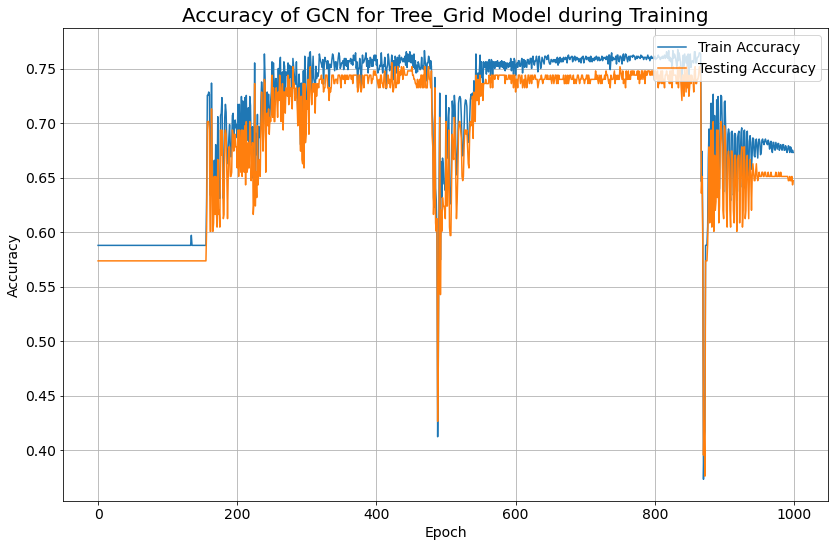

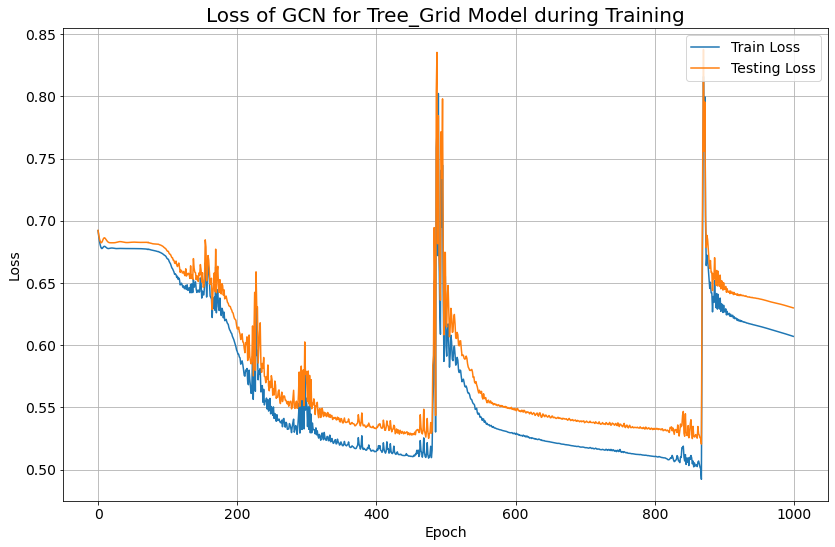

Explanation class 0: ~feature0000000003_0000000009 - acc. = 0.2989 - compl. = 1.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 10, n_clustering: 4, concept_emb_size: 20


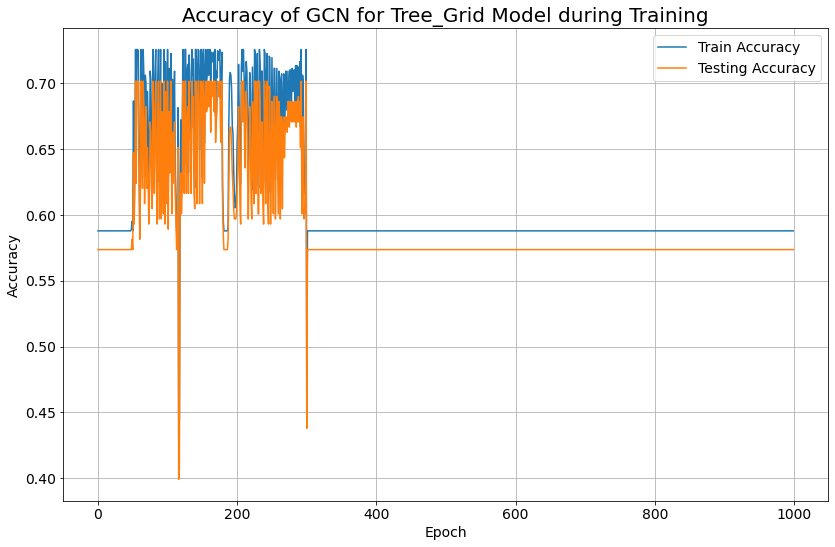

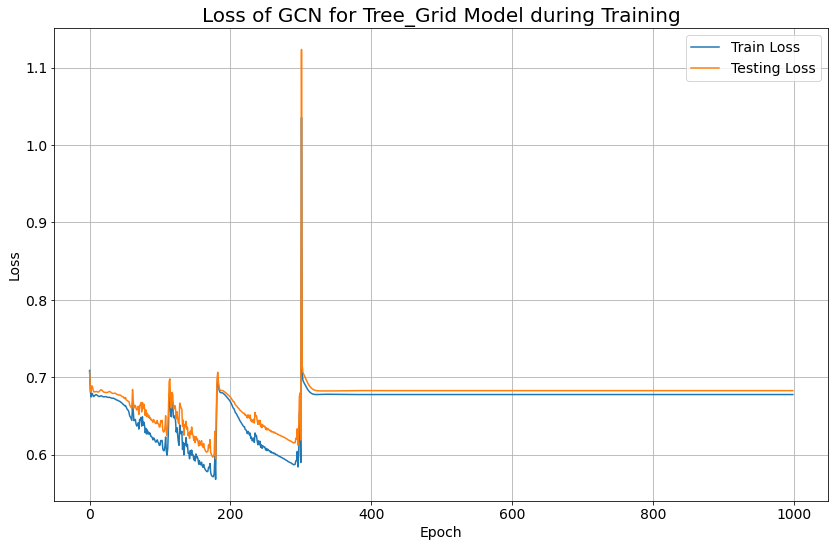

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 20, n_clustering: 2, concept_emb_size: 5


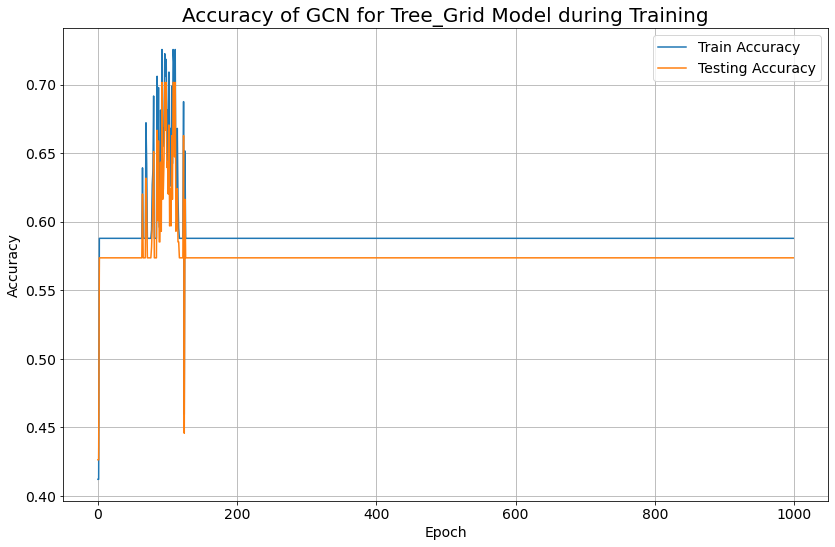

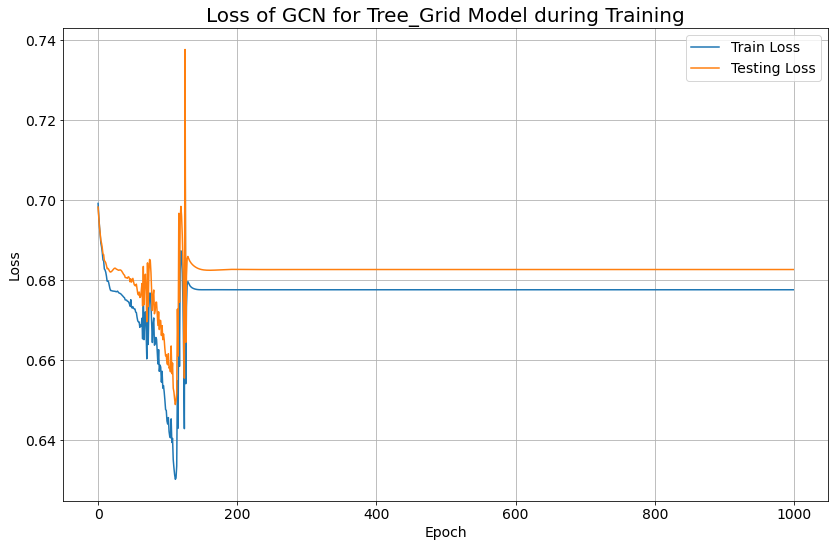

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 20, n_clustering: 2, concept_emb_size: 10


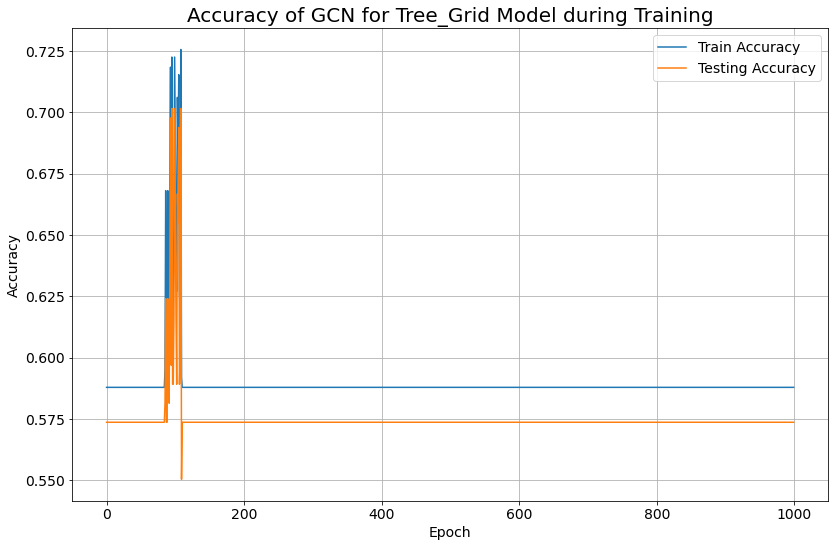

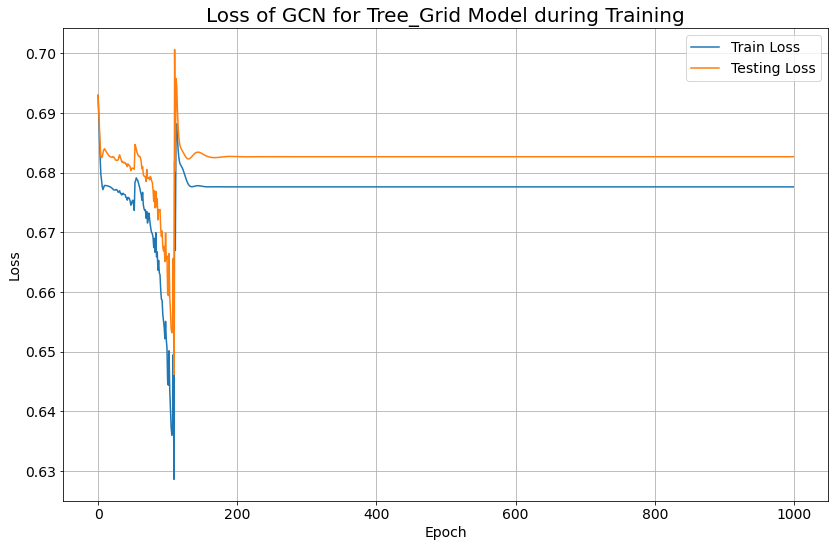

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 20, n_clustering: 2, concept_emb_size: 20


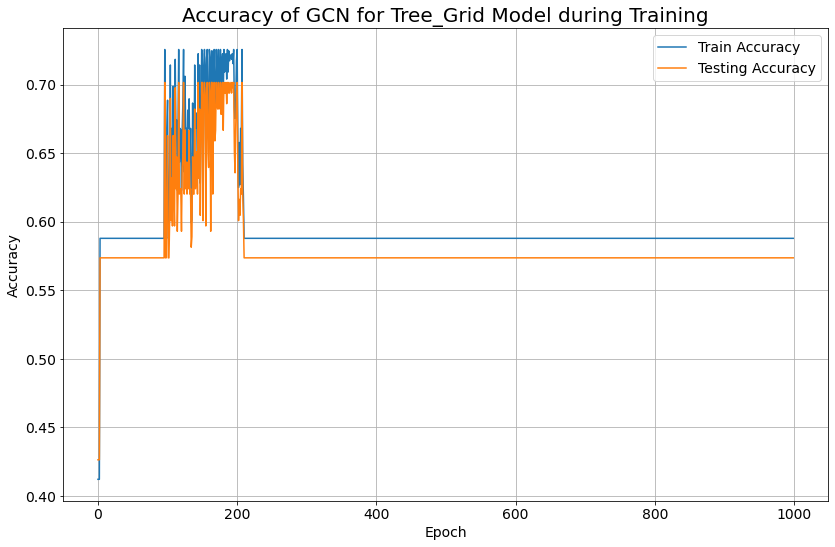

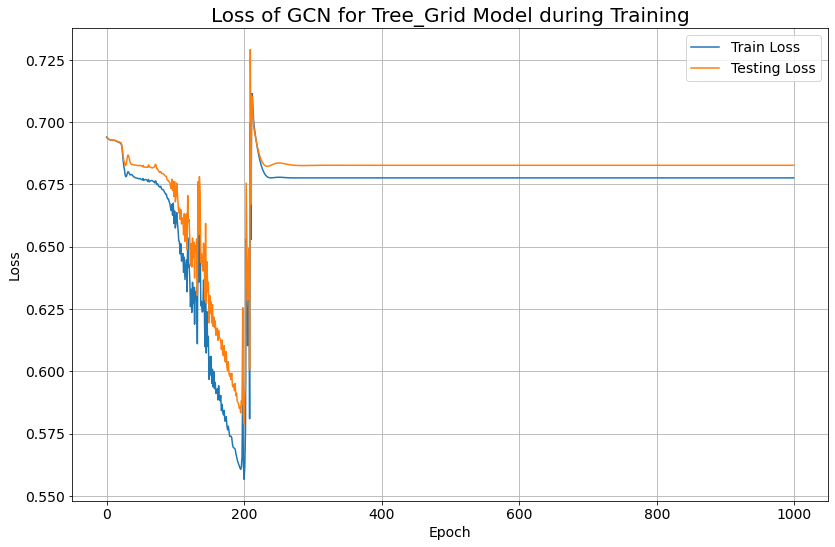

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 20, n_clustering: 3, concept_emb_size: 5


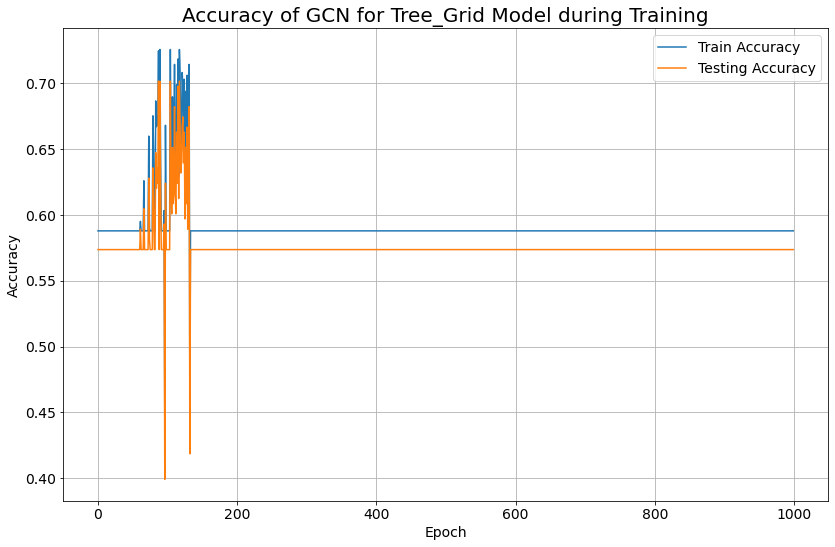

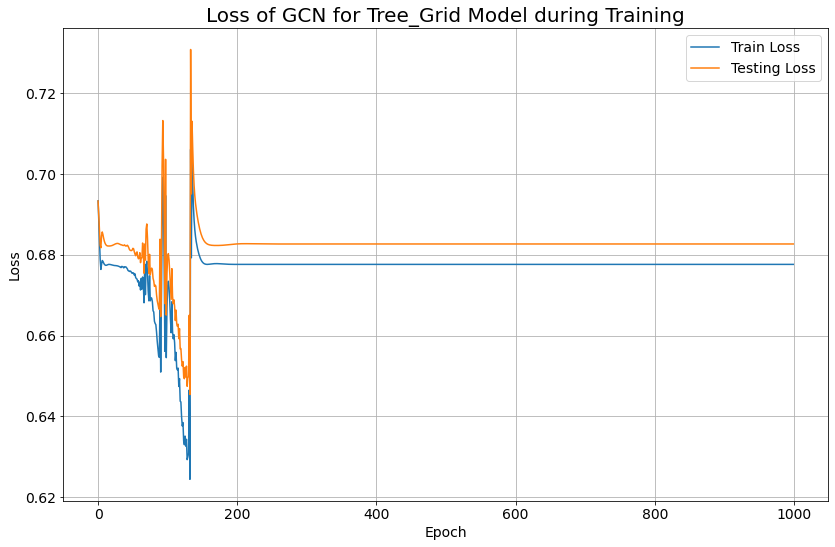

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 20, n_clustering: 3, concept_emb_size: 10


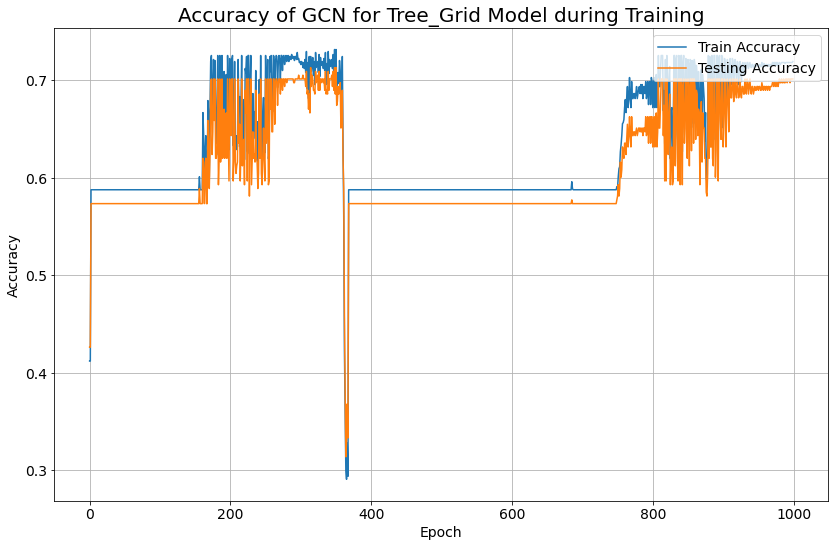

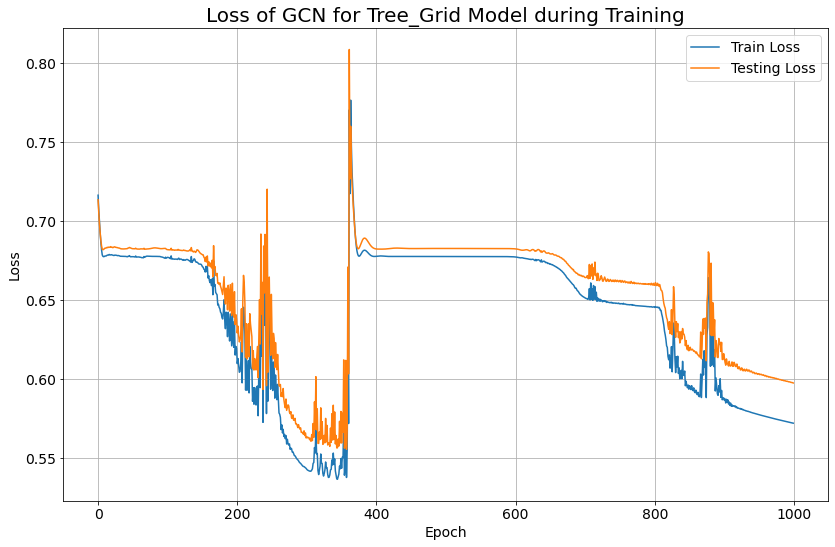

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 20, n_clustering: 3, concept_emb_size: 20


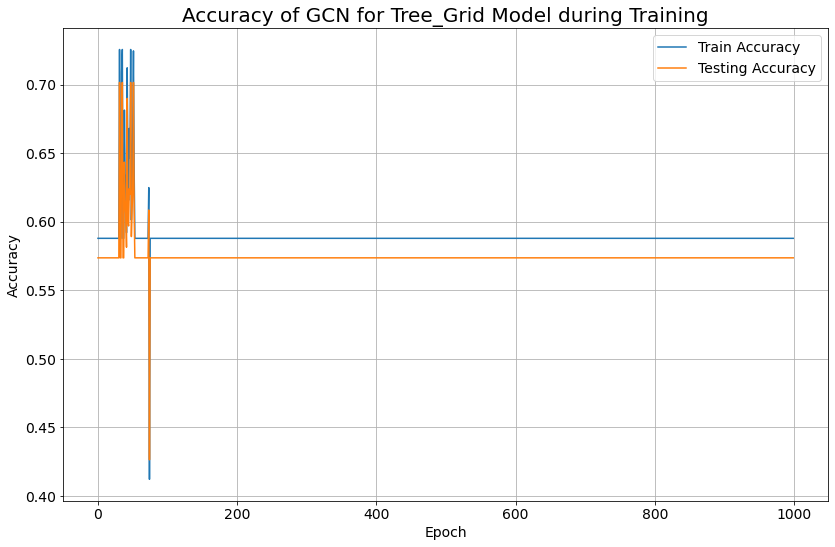

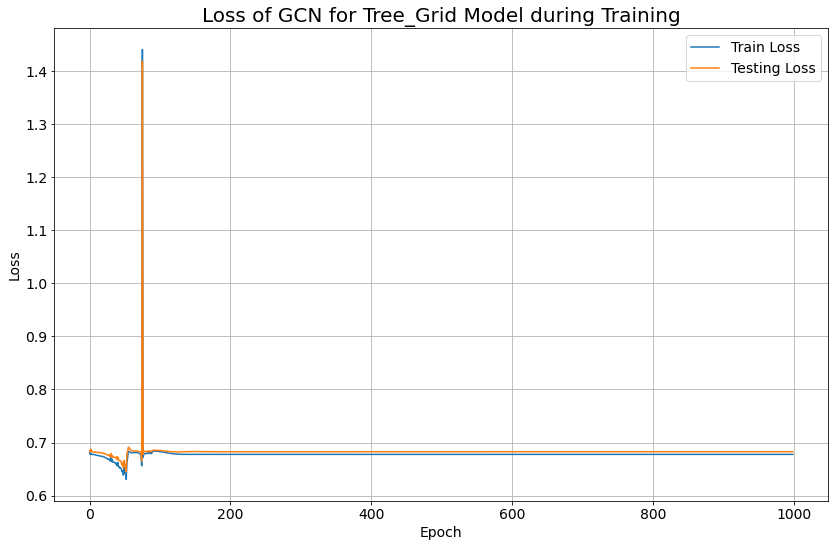

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 20, n_clustering: 4, concept_emb_size: 5


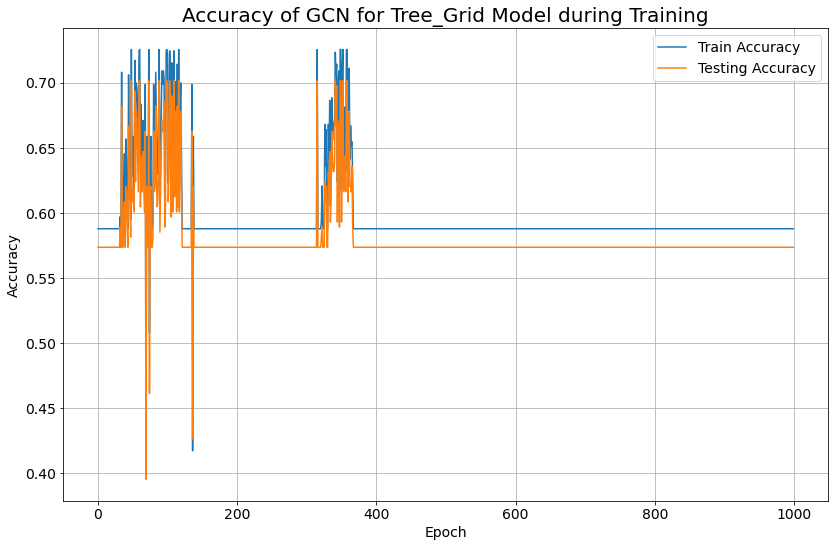

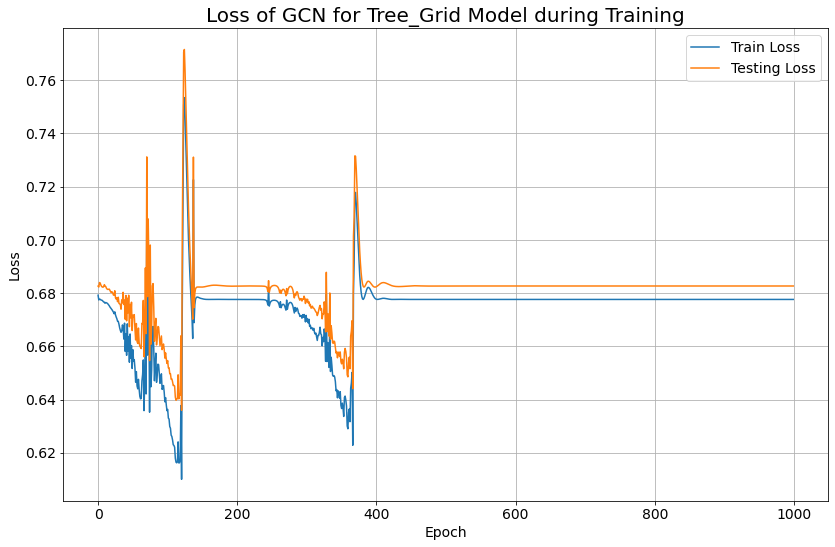

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 20, n_clustering: 4, concept_emb_size: 10


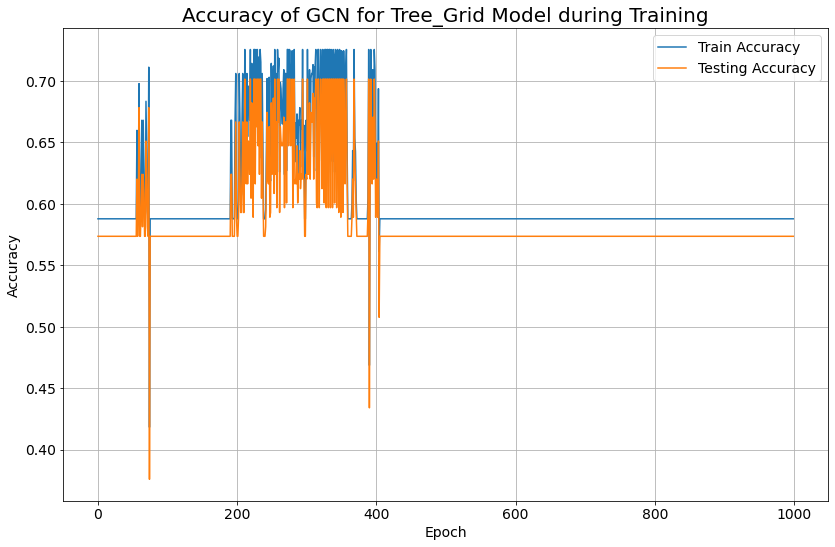

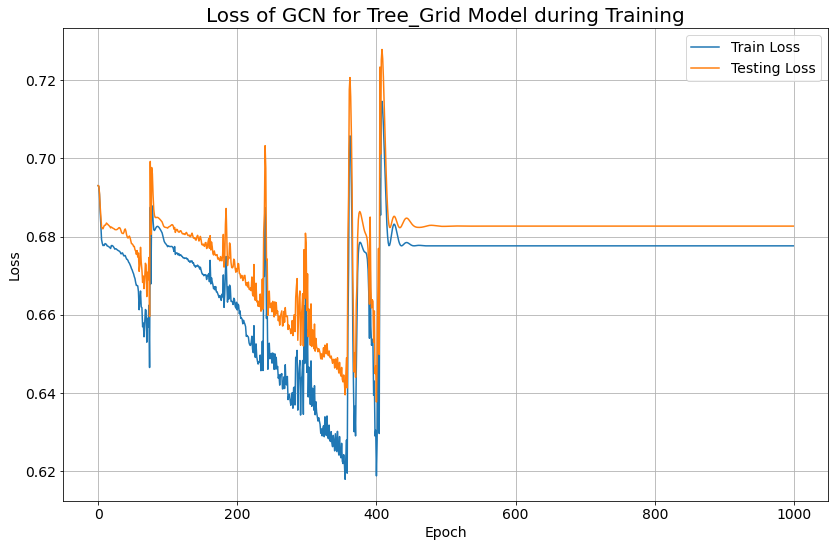

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 20, n_clustering: 4, concept_emb_size: 20


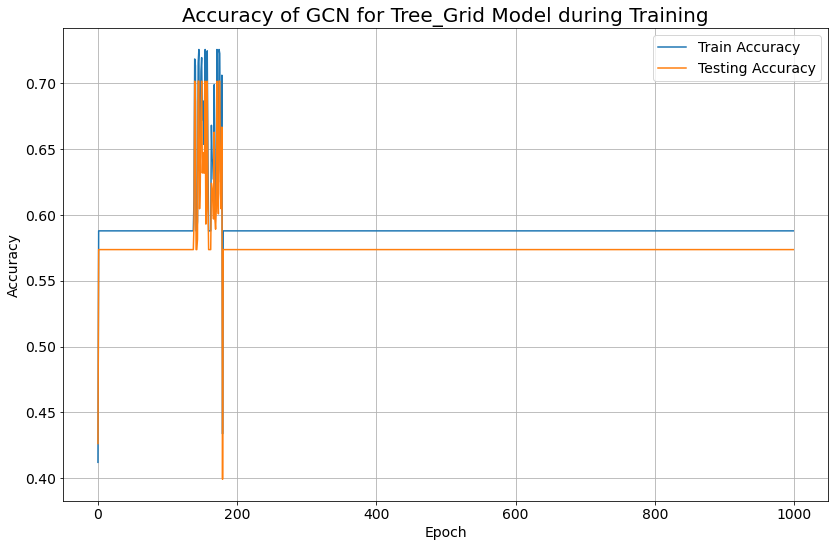

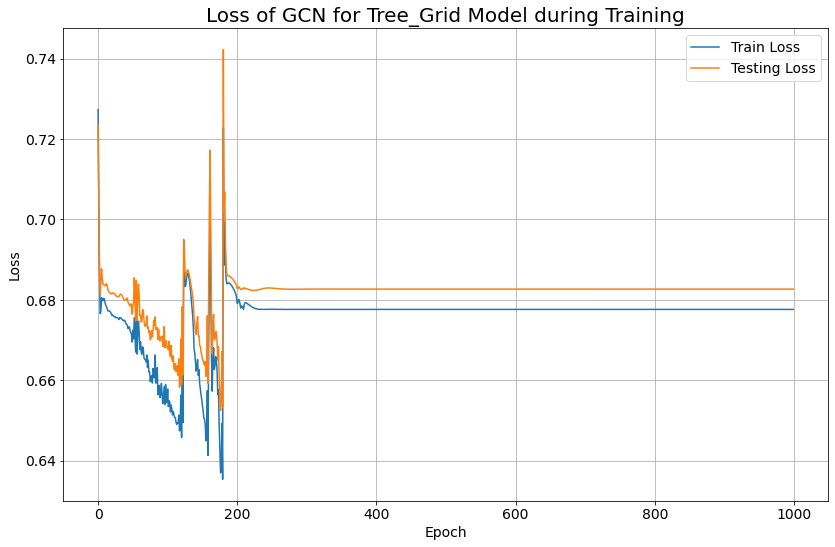

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 30, n_clustering: 2, concept_emb_size: 5


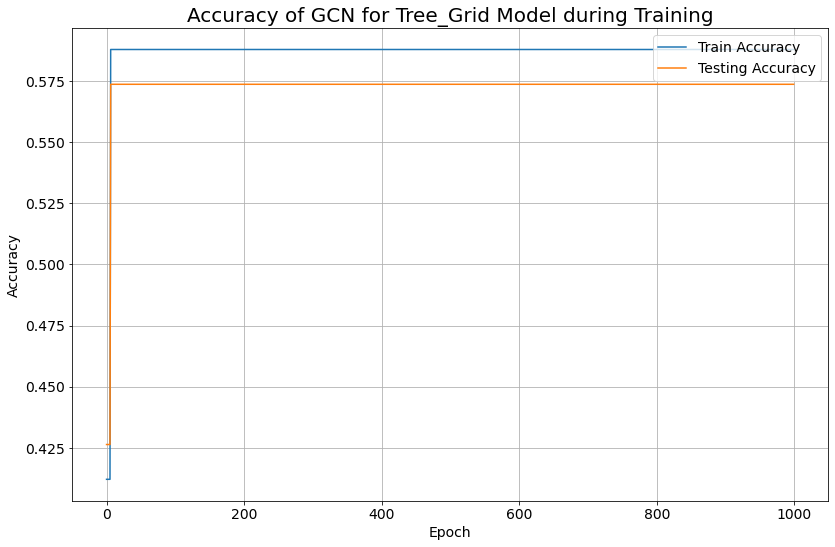

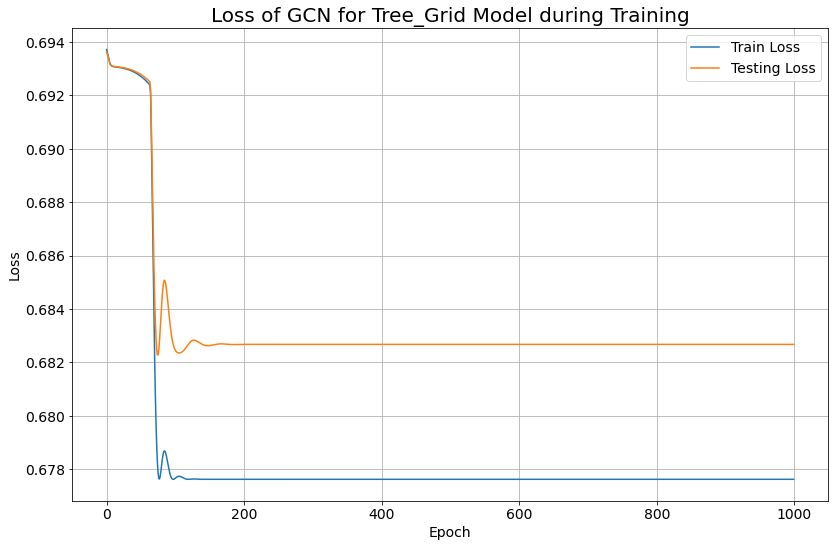

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 30, n_clustering: 2, concept_emb_size: 10


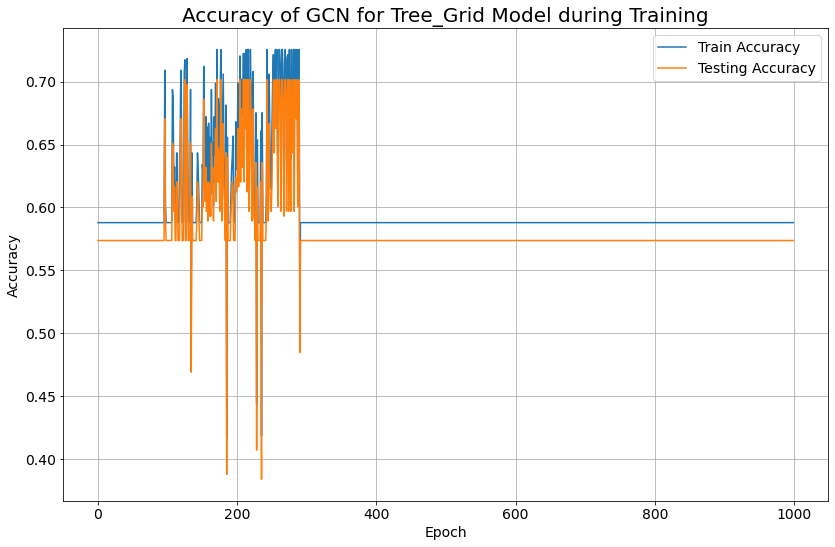

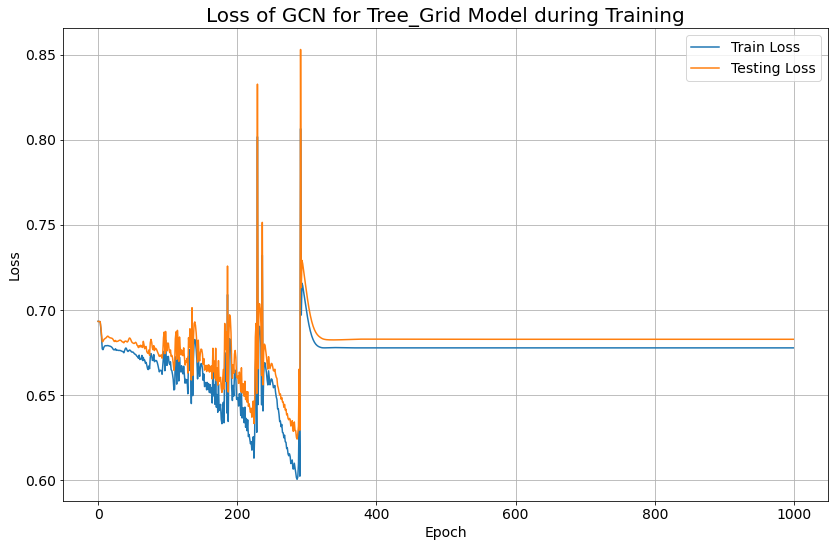

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 30, n_clustering: 2, concept_emb_size: 20


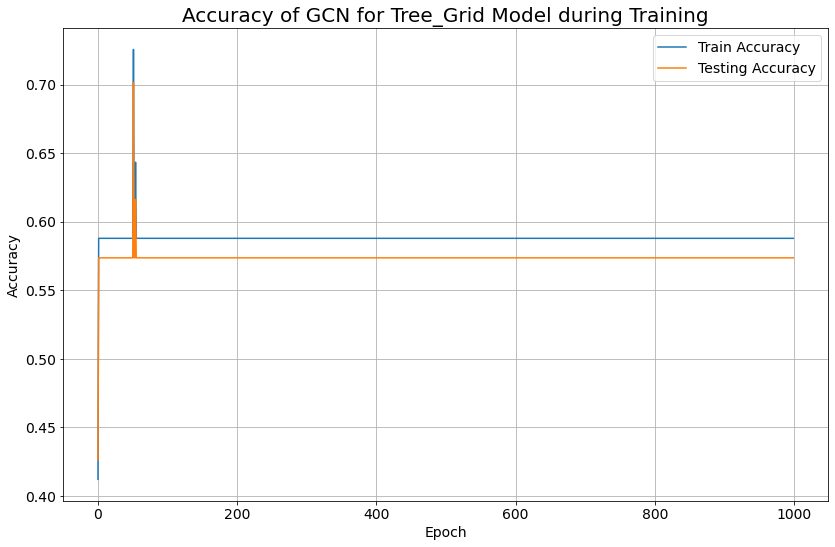

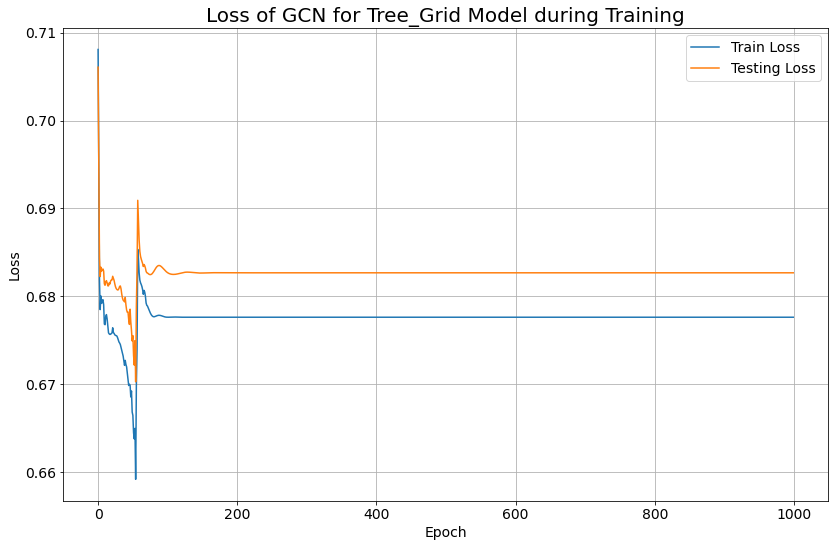

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 30, n_clustering: 3, concept_emb_size: 5


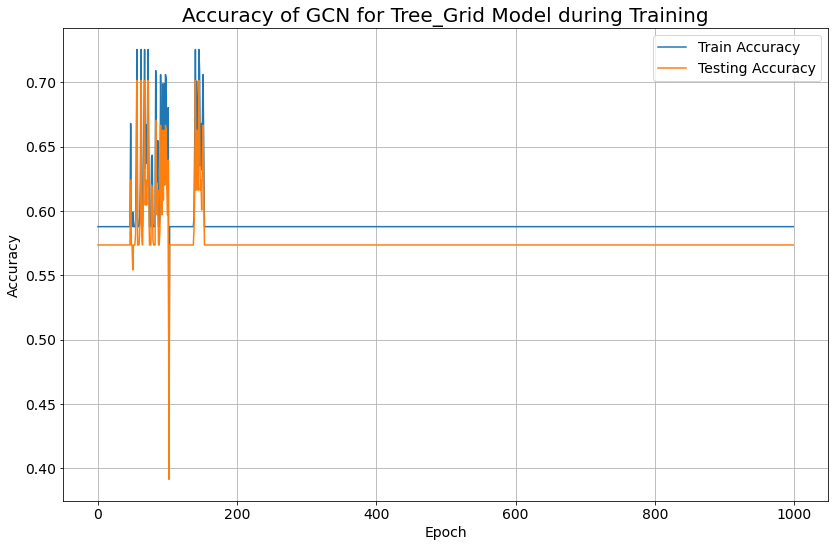

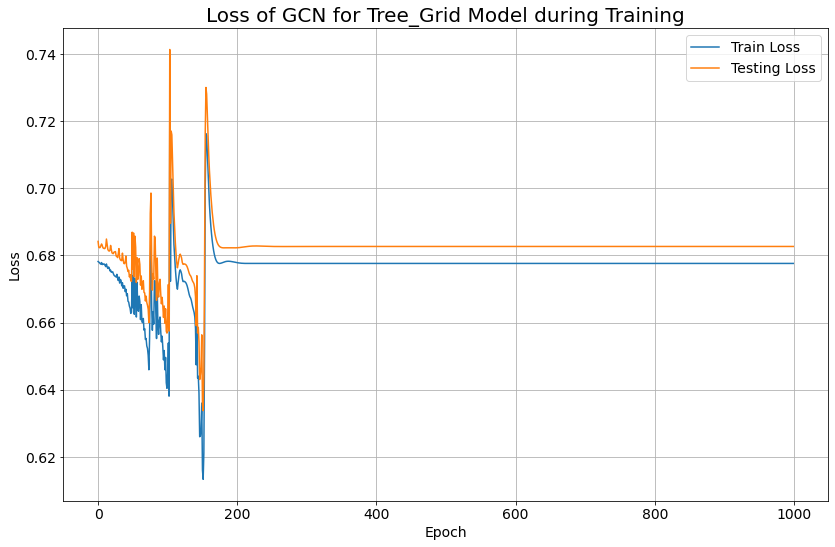

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 30, n_clustering: 3, concept_emb_size: 10


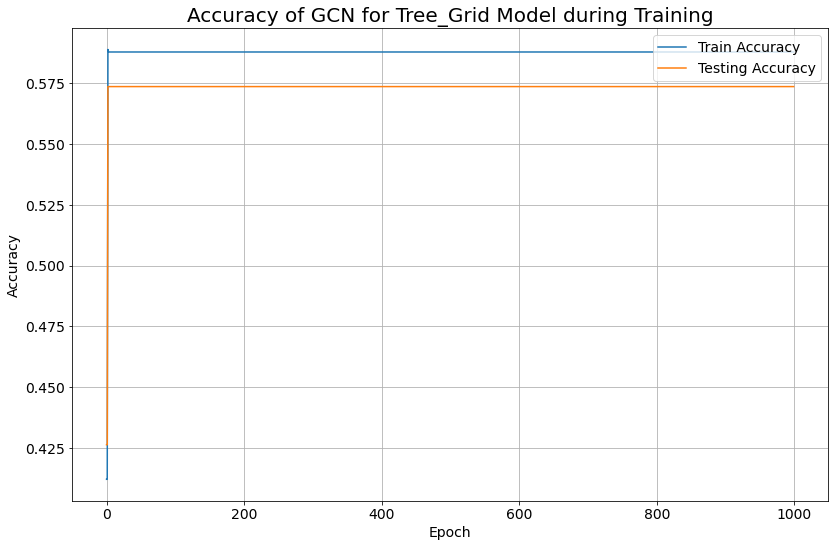

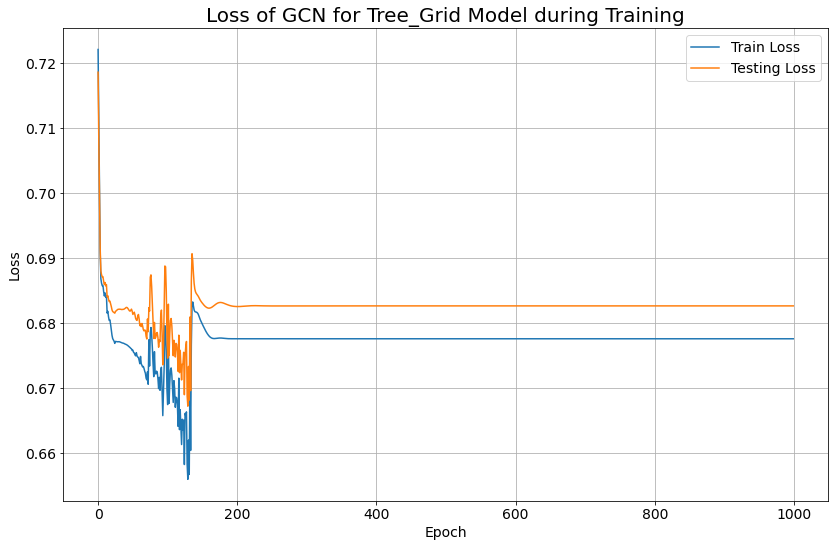

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 30, n_clustering: 3, concept_emb_size: 20


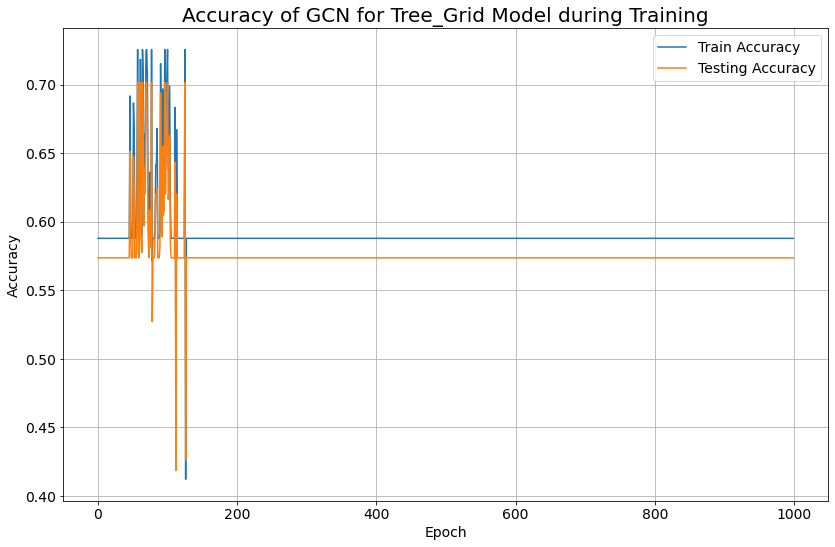

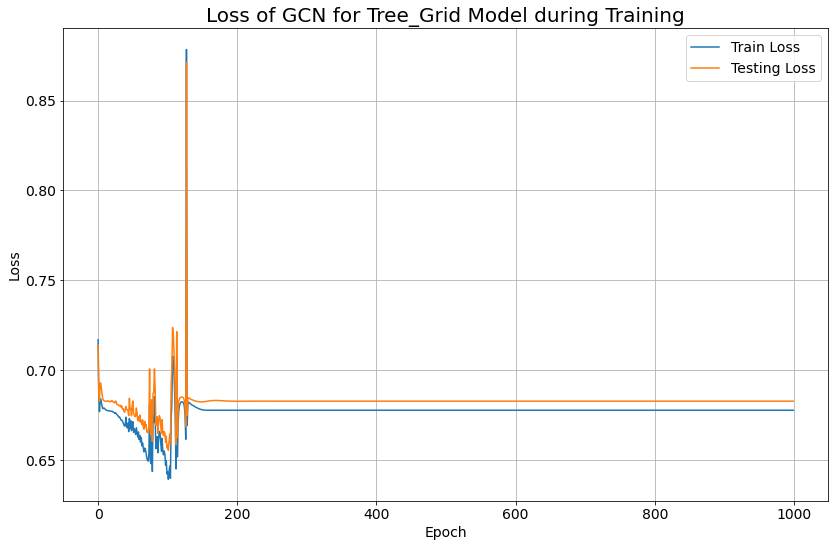

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 30, n_clustering: 4, concept_emb_size: 5


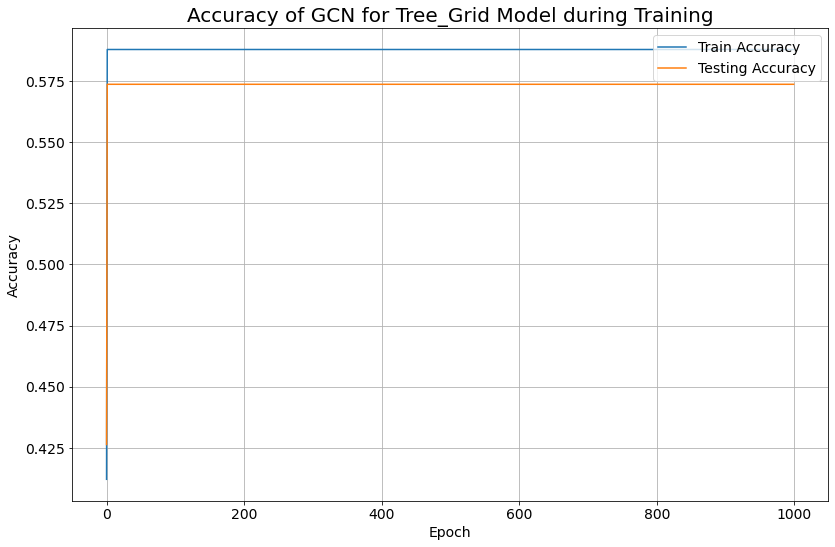

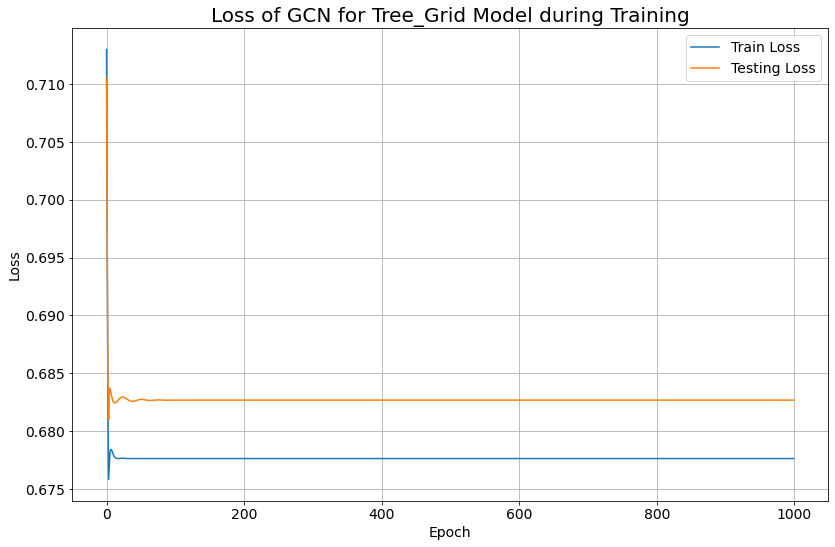

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 30, n_clustering: 4, concept_emb_size: 10


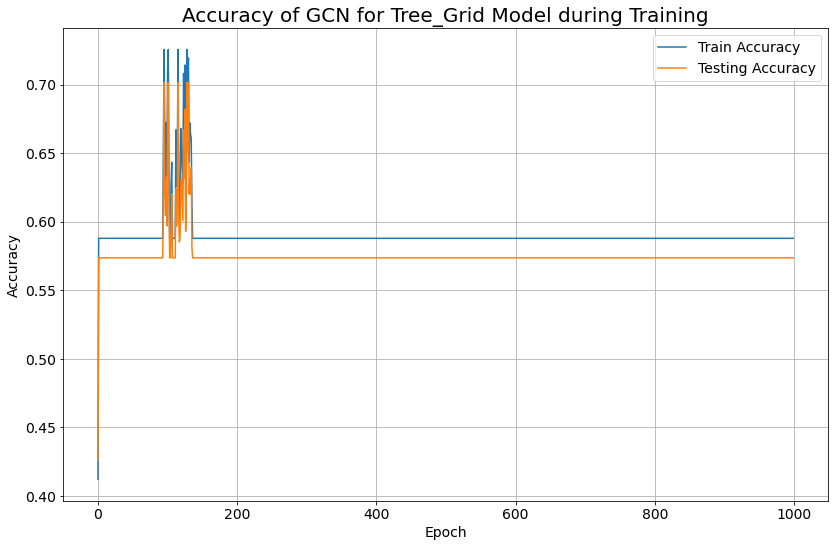

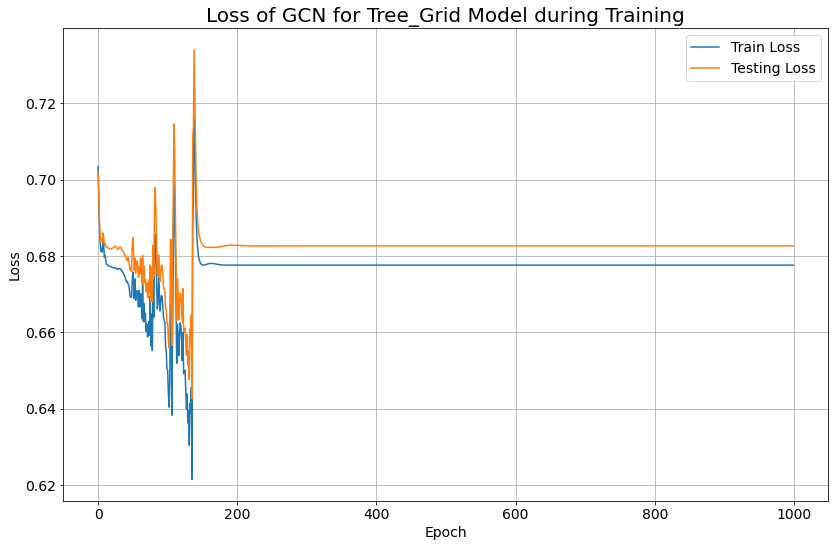

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.01, hu: 30, n_clustering: 4, concept_emb_size: 20


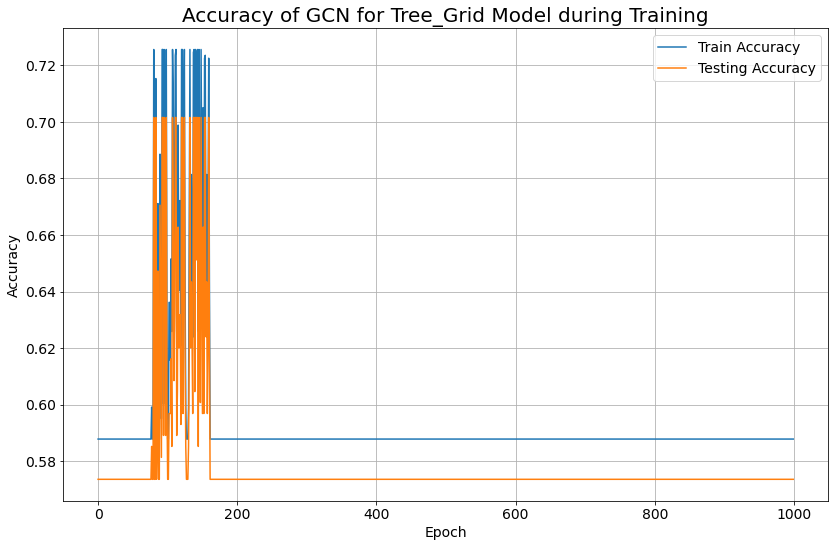

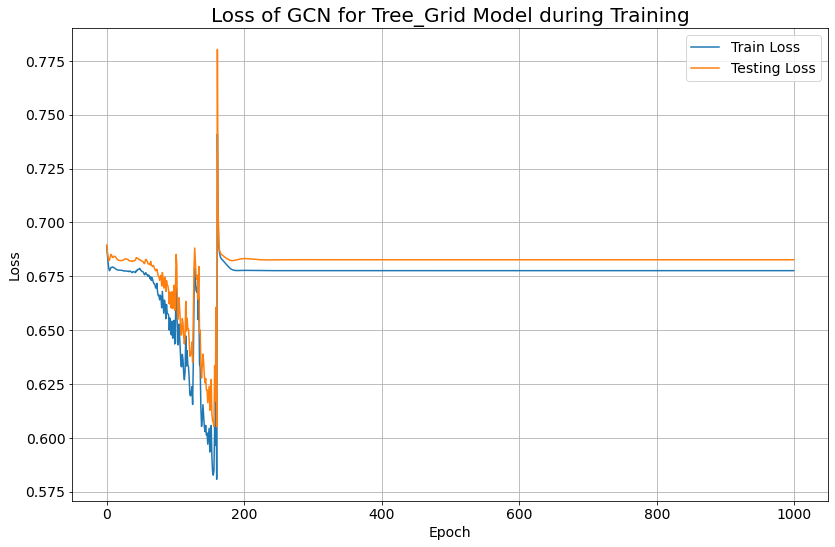

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 10, n_clustering: 2, concept_emb_size: 5


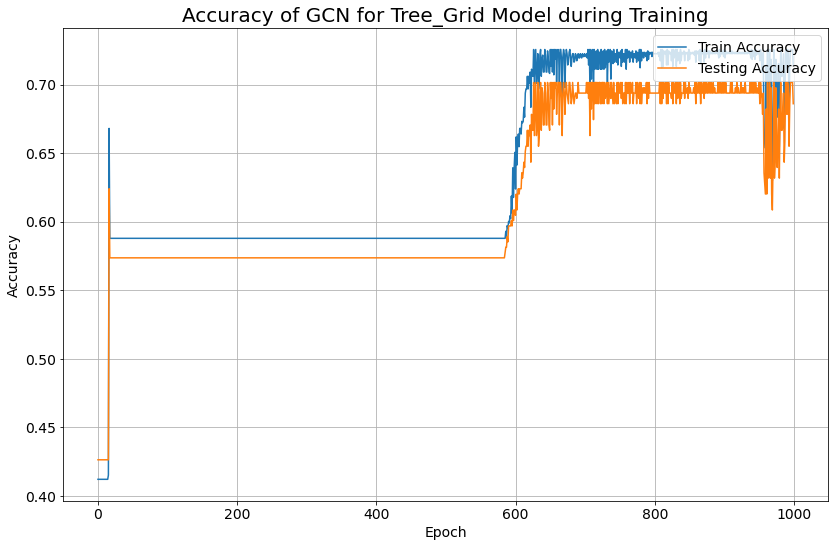

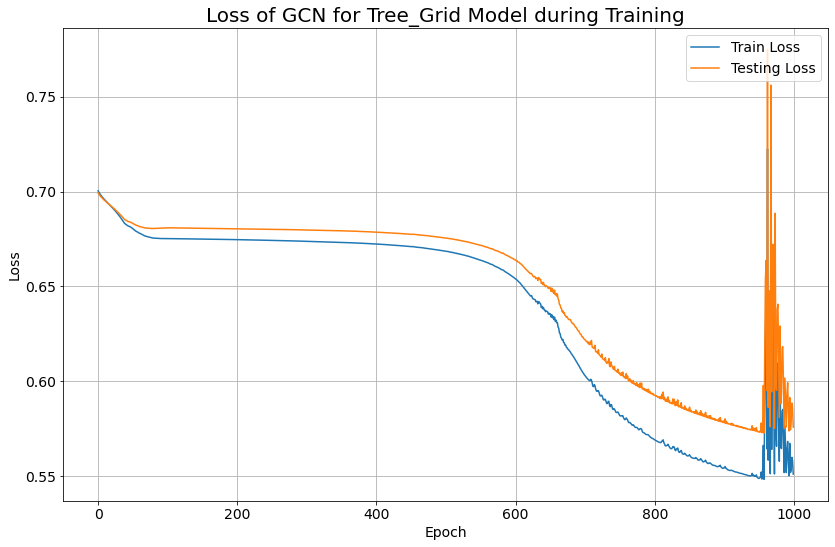

Explanation class 0: feature0000000000_0000000003 - acc. = 0.6176 - compl. = 1.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 10, n_clustering: 2, concept_emb_size: 10


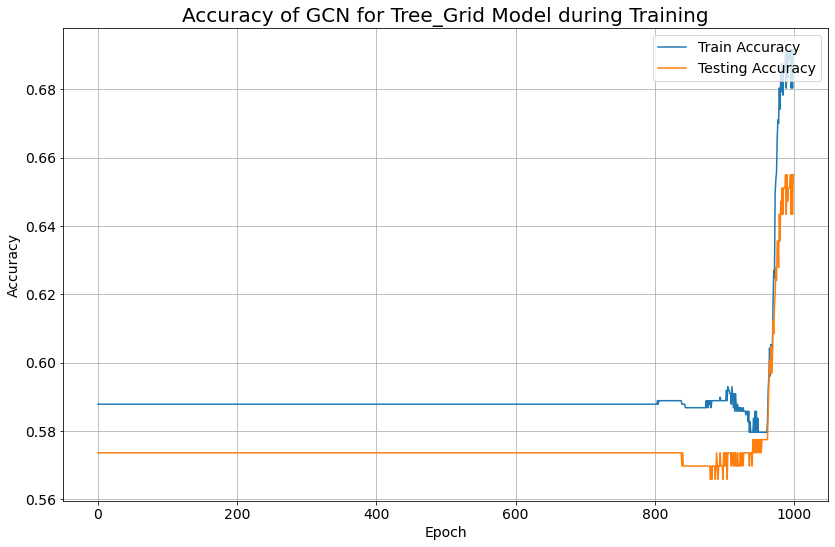

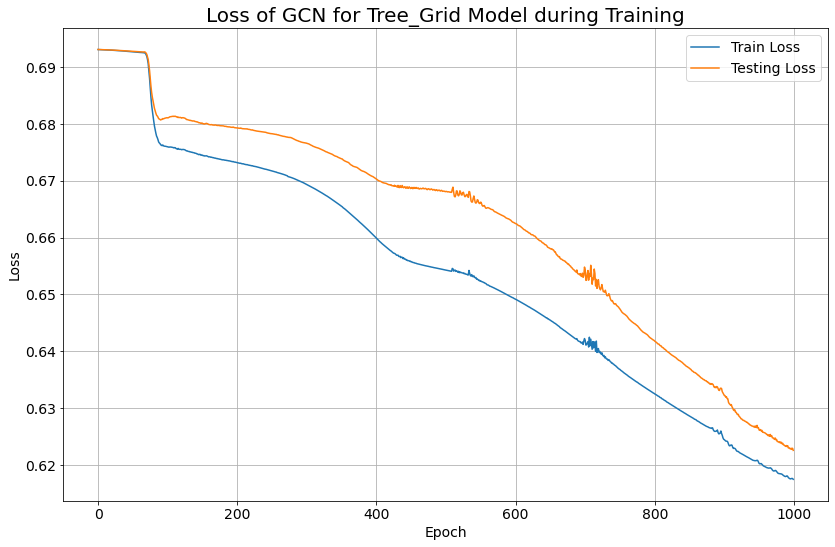

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: ~feature0000000001_0000000008 | ~feature0000000001_0000000009 - acc. = 0.3693 - compl. = 2.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 10, n_clustering: 2, concept_emb_size: 20


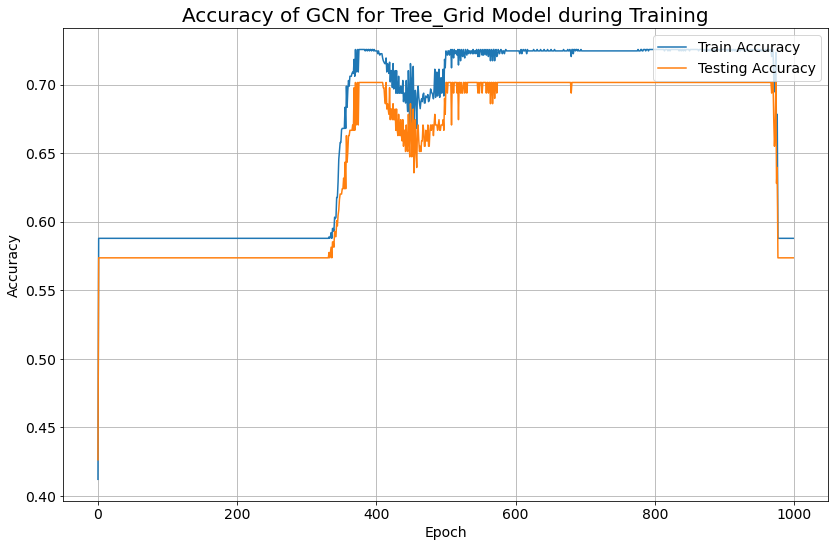

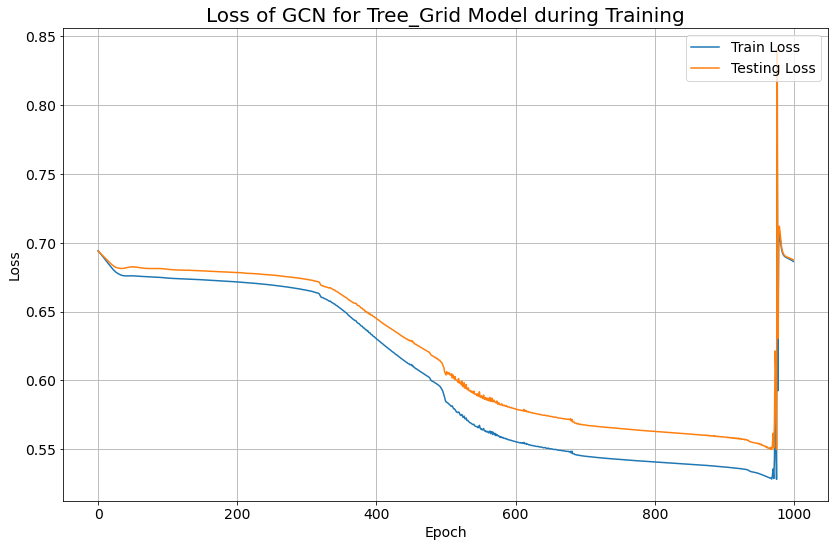

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 10, n_clustering: 3, concept_emb_size: 5


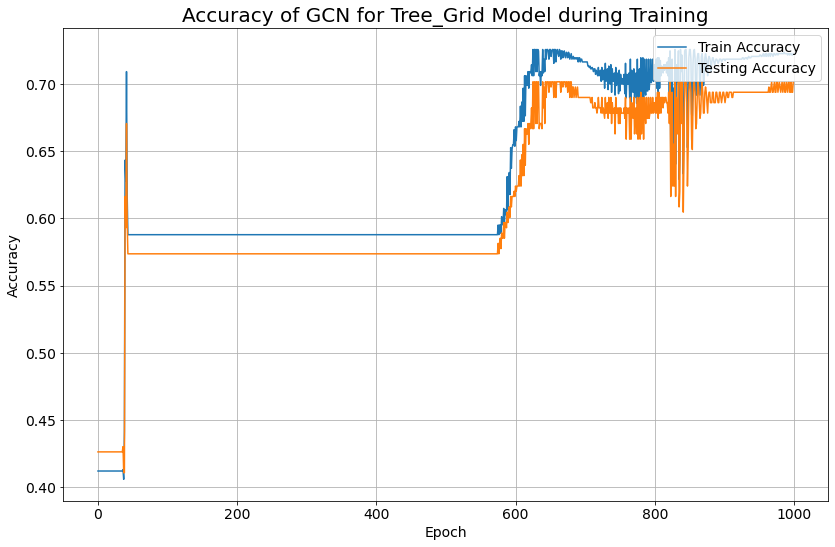

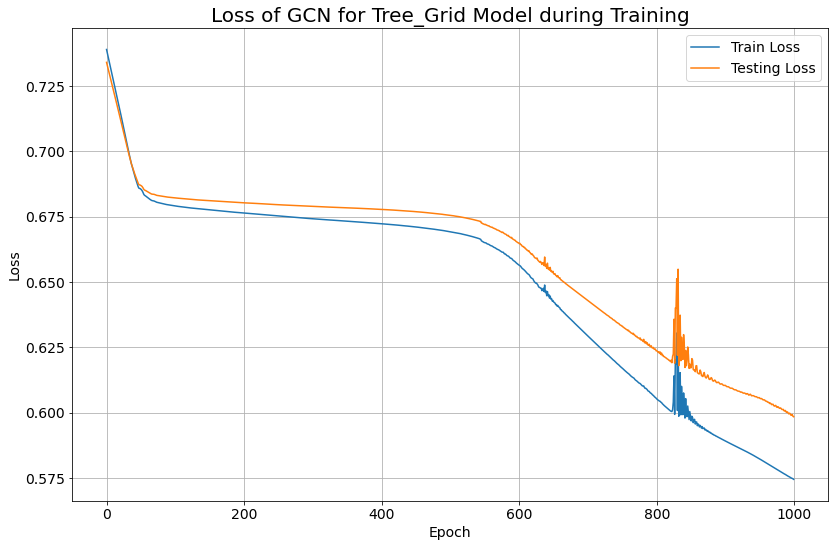

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: ~feature0000000002_0000000002 - acc. = 0.6178 - compl. = 1.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 10, n_clustering: 3, concept_emb_size: 10


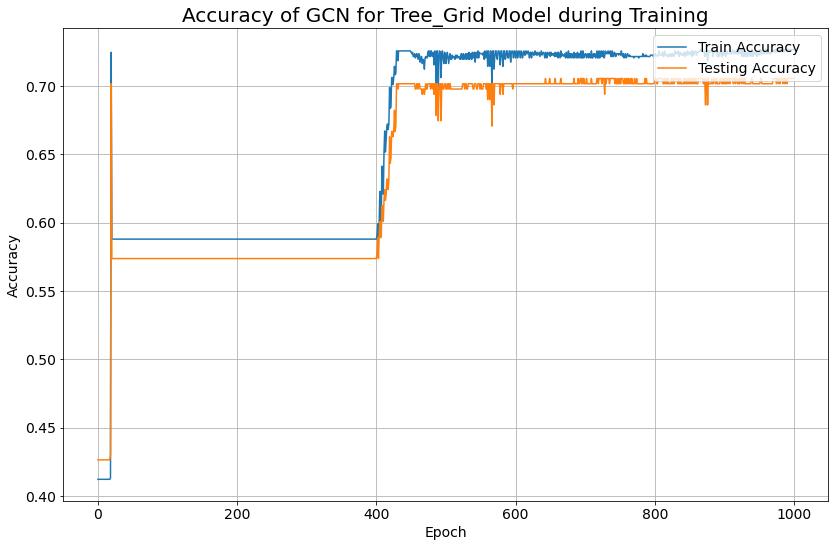

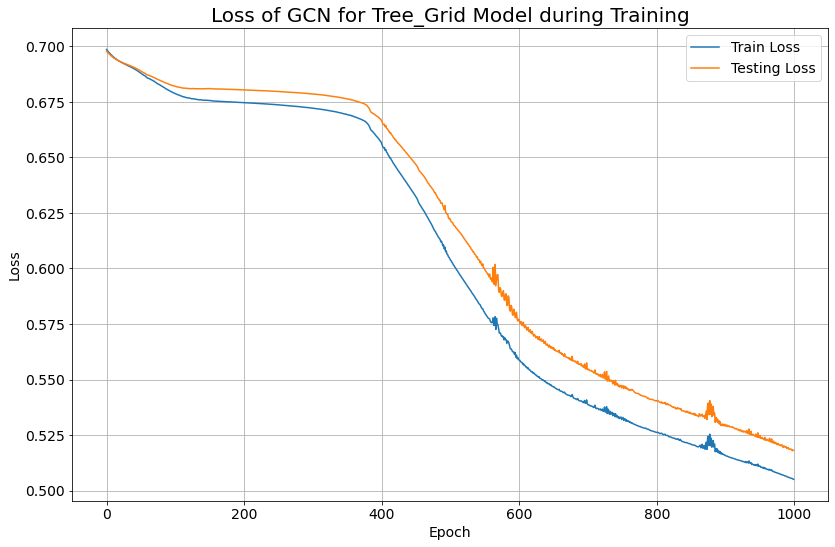

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 10, n_clustering: 3, concept_emb_size: 20


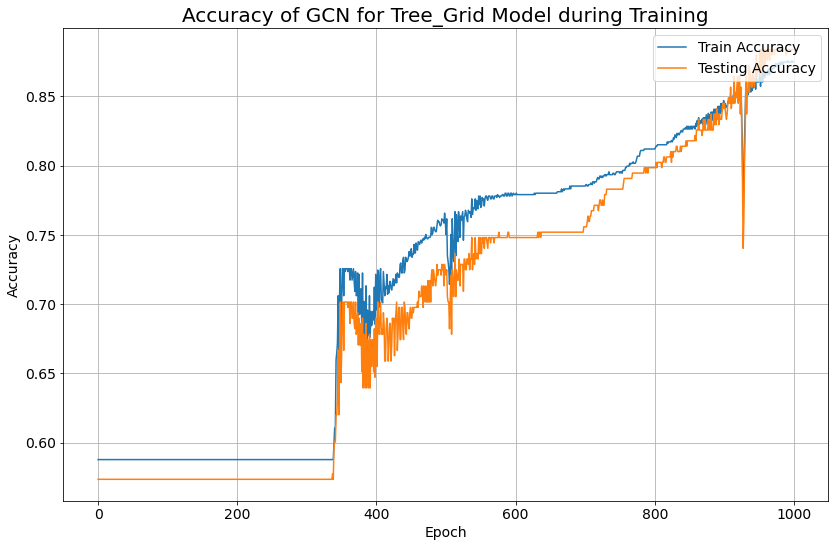

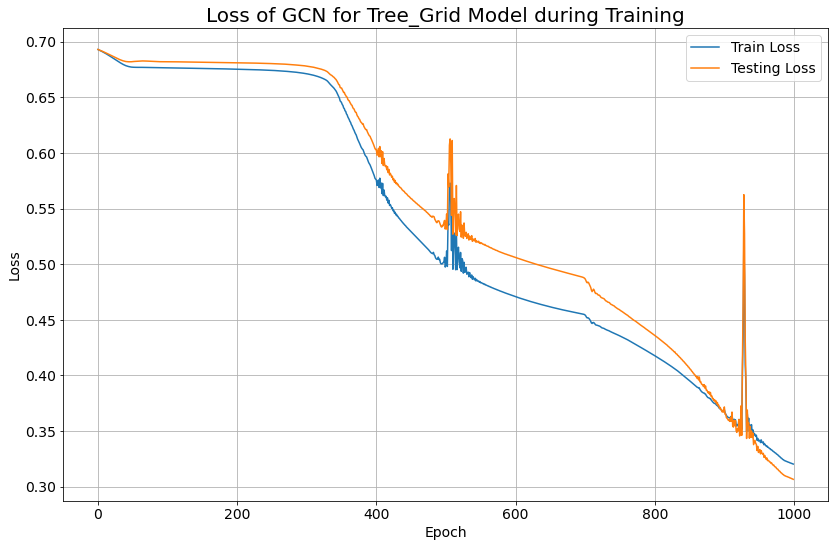

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: ~feature0000000001_0000000019 - acc. = 0.8761 - compl. = 1.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 10, n_clustering: 4, concept_emb_size: 5


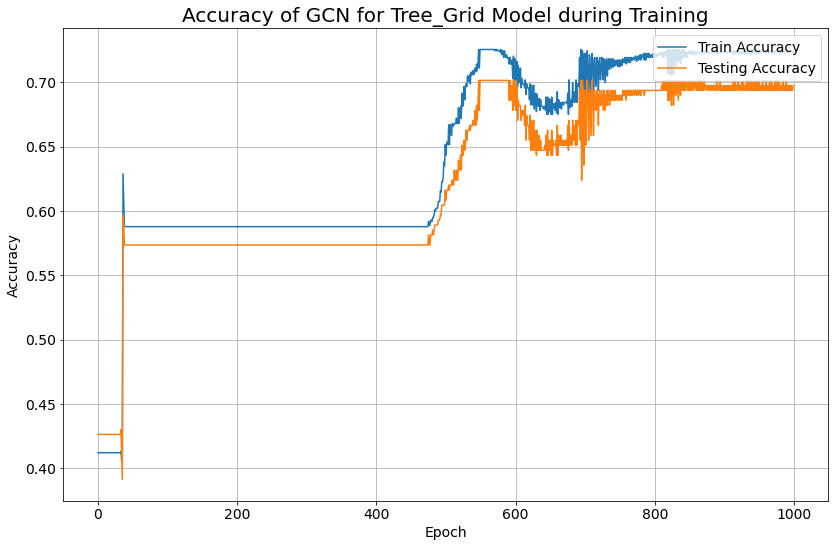

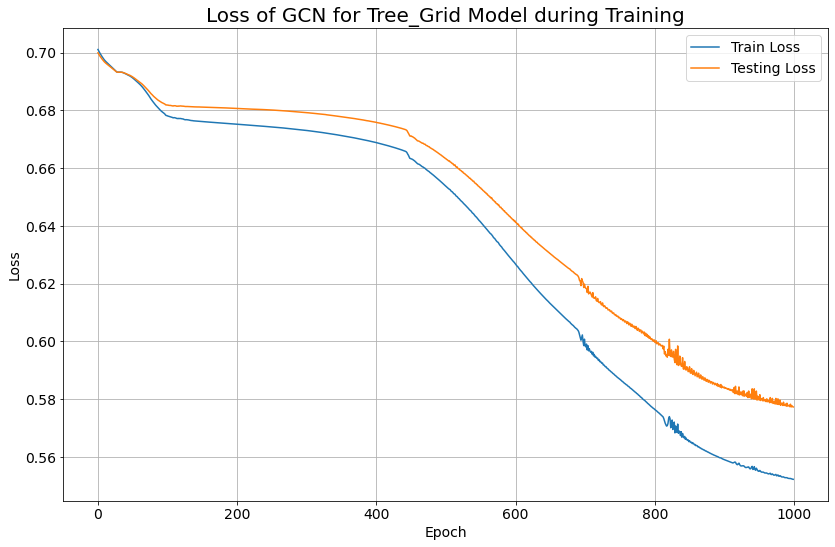

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: ~feature0000000002_0000000004 - acc. = 0.2989 - compl. = 1.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 10, n_clustering: 4, concept_emb_size: 10


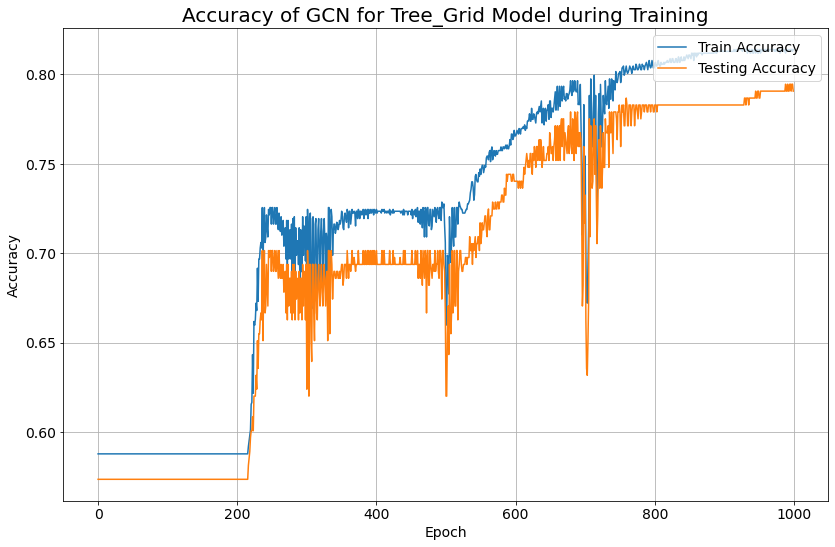

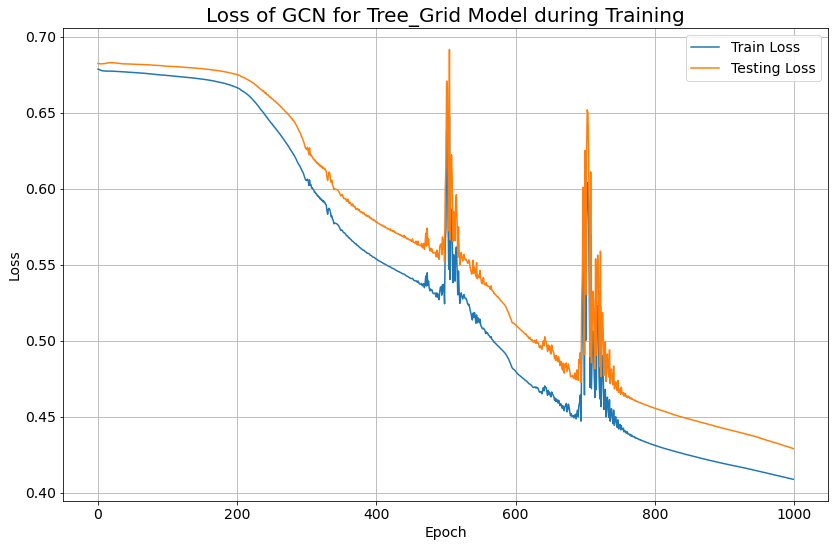

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: feature0000000003_0000000009 | ~feature0000000003_0000000007 - acc. = 0.7281 - compl. = 2.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 10, n_clustering: 4, concept_emb_size: 20


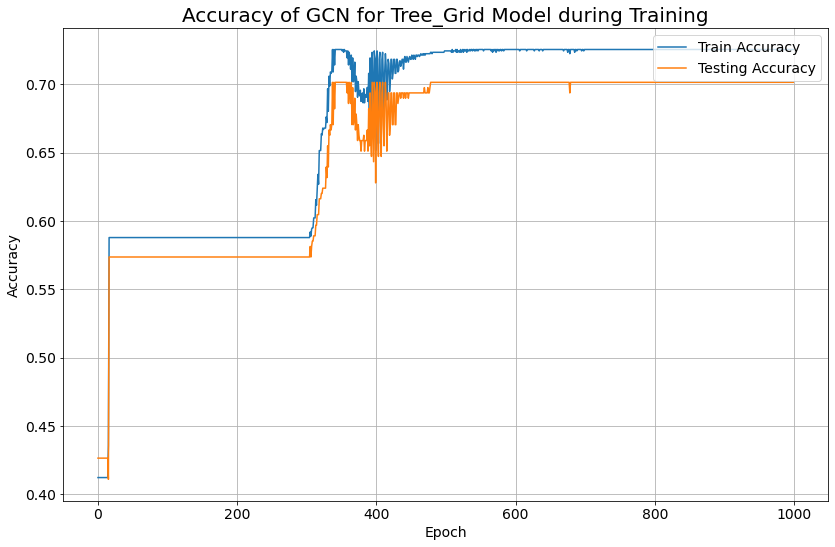

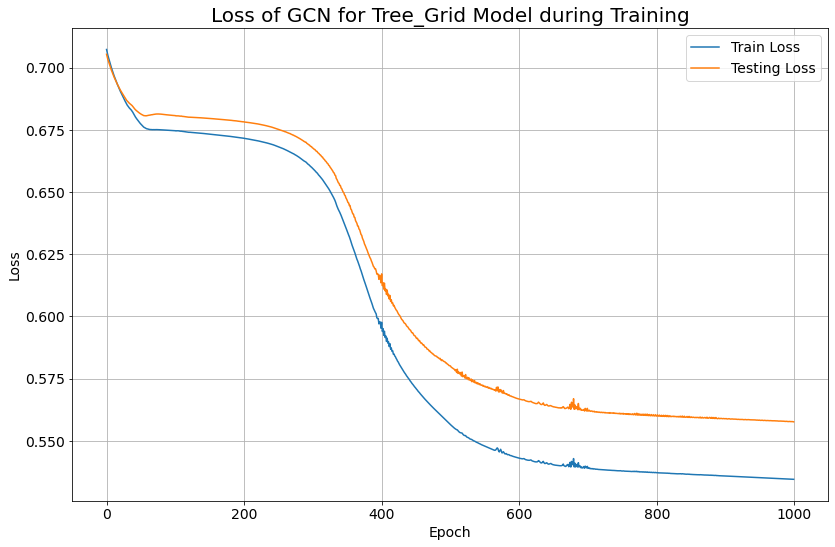

Explanation class 0: feature0000000002_0000000019 - acc. = 0.6053 - compl. = 1.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 20, n_clustering: 2, concept_emb_size: 5


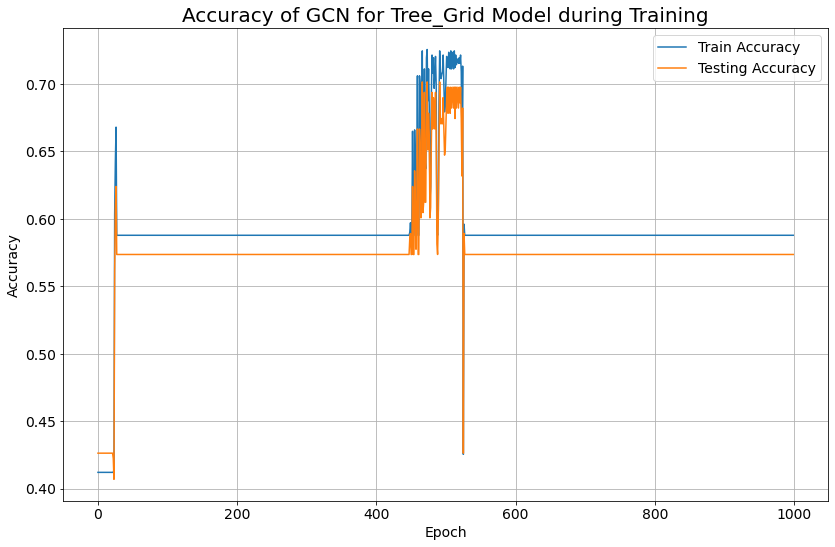

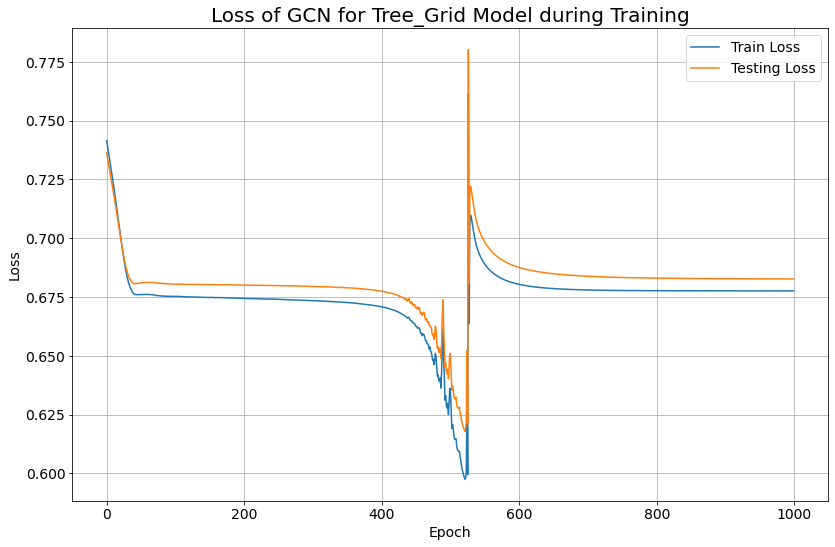

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 20, n_clustering: 2, concept_emb_size: 10


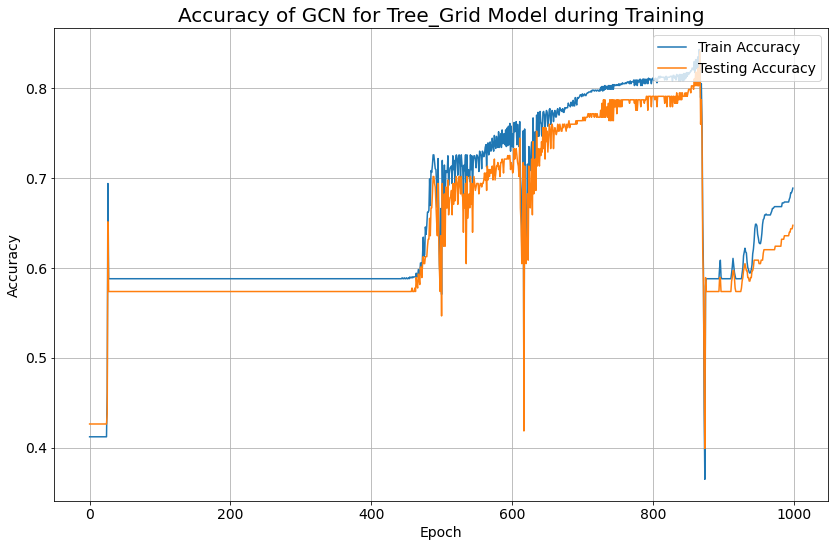

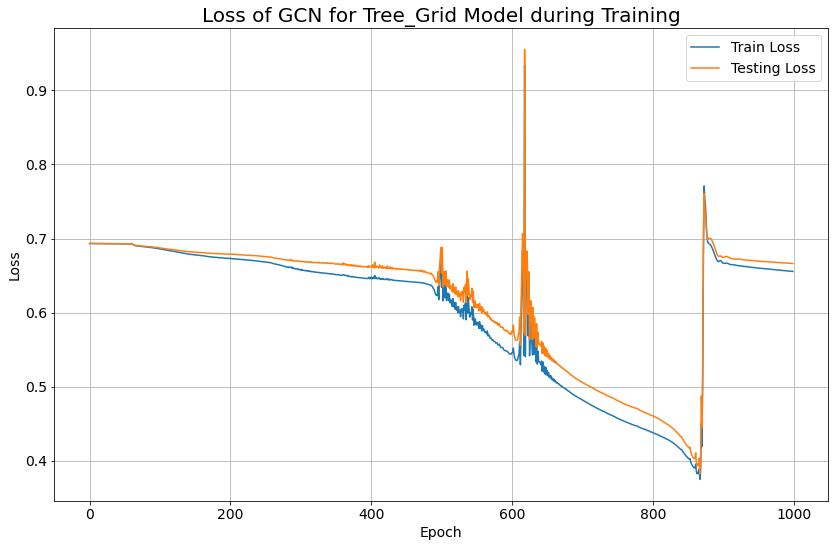

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 20, n_clustering: 2, concept_emb_size: 20


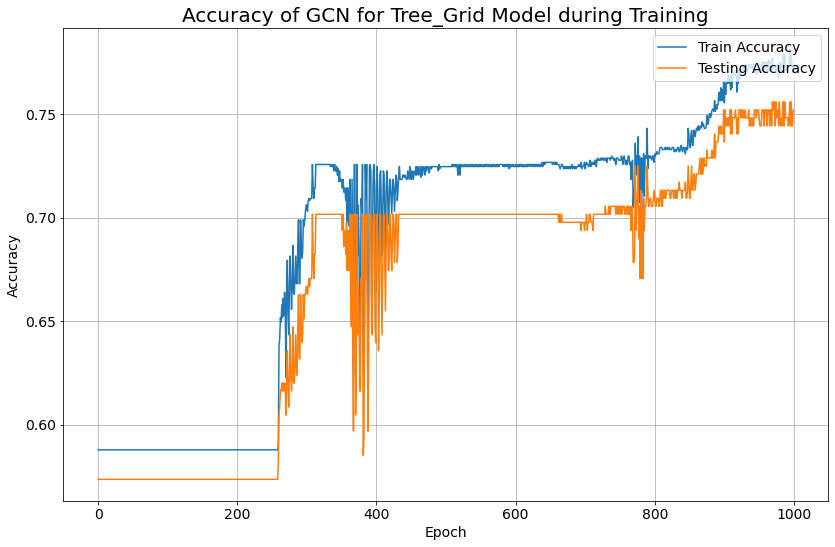

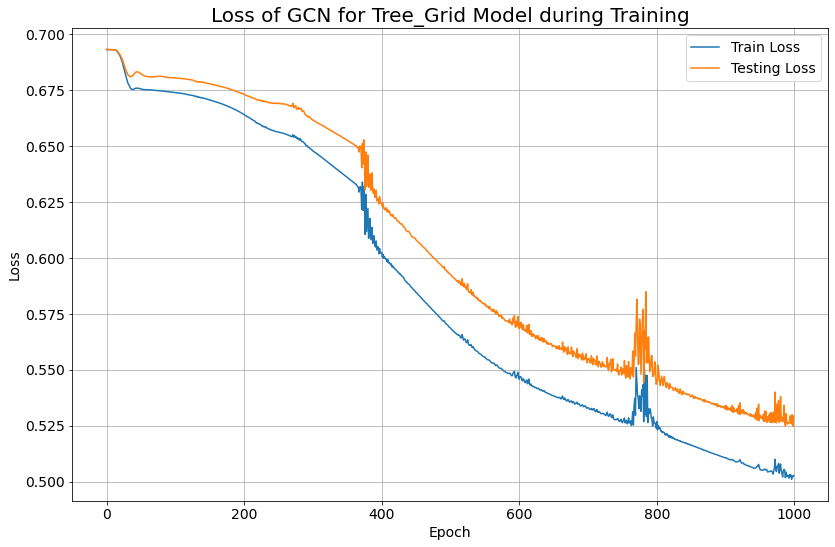

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 20, n_clustering: 3, concept_emb_size: 5


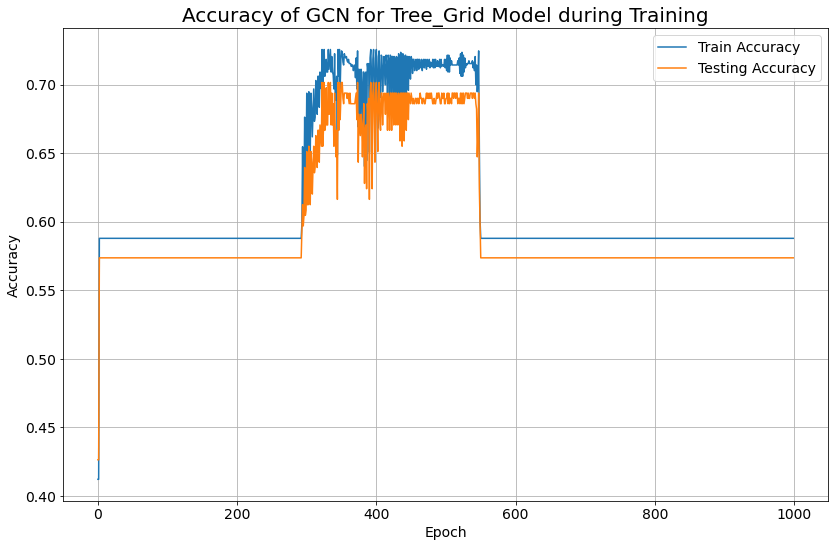

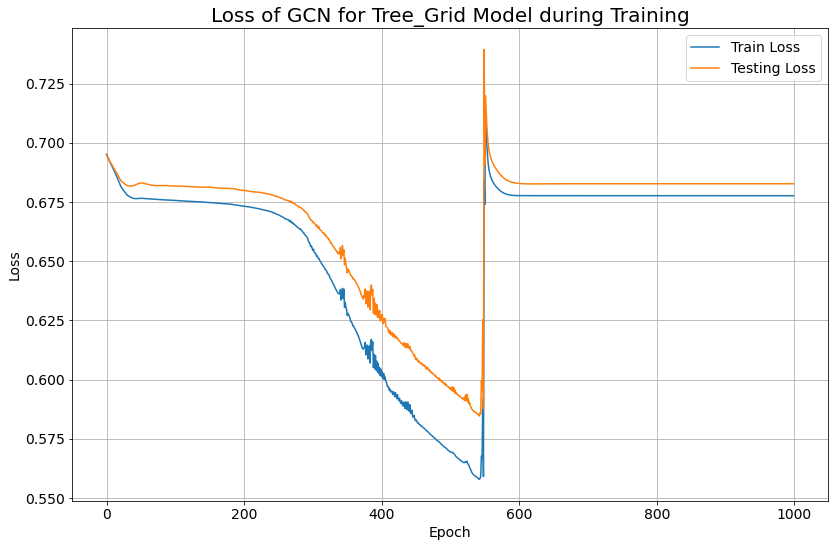

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 20, n_clustering: 3, concept_emb_size: 10


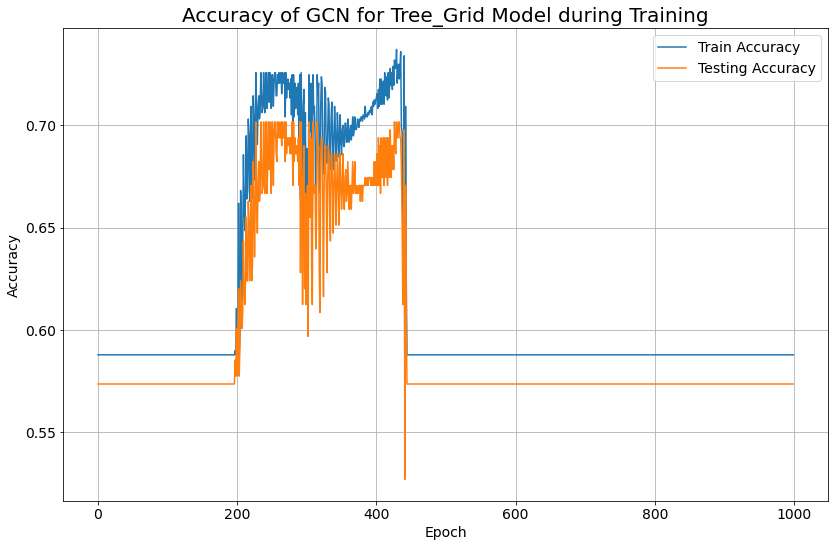

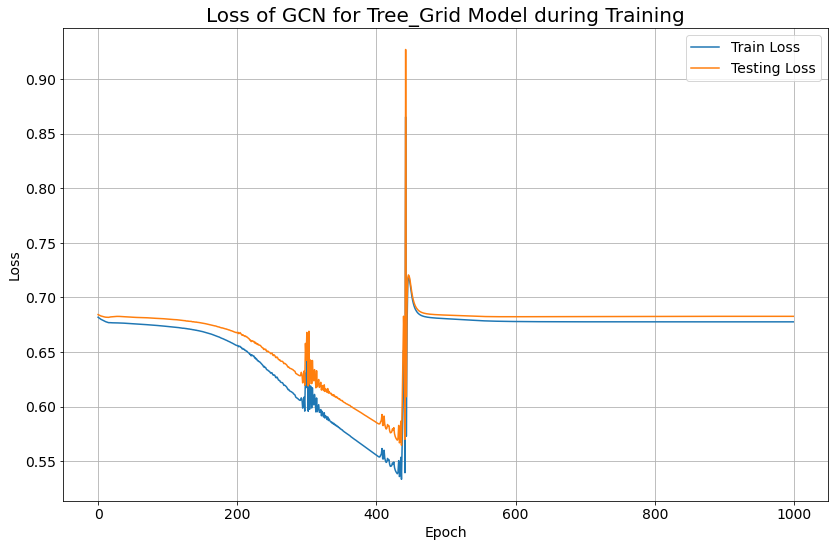

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 20, n_clustering: 3, concept_emb_size: 20


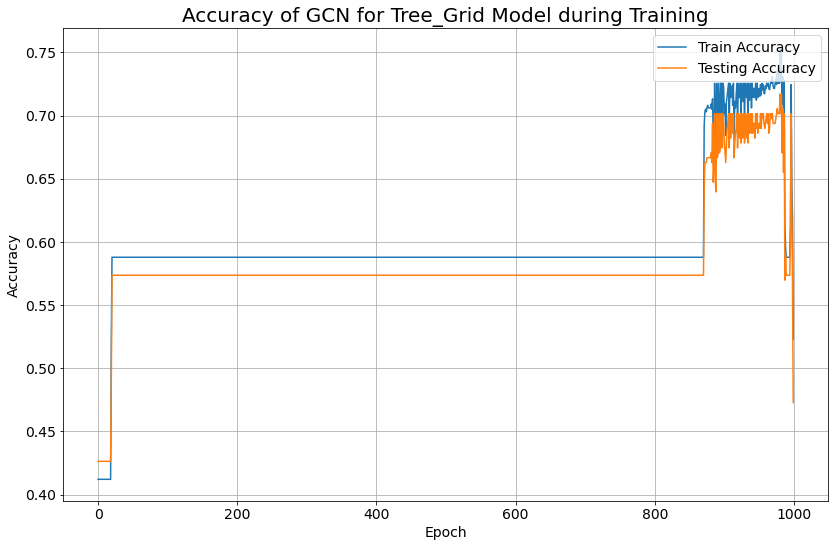

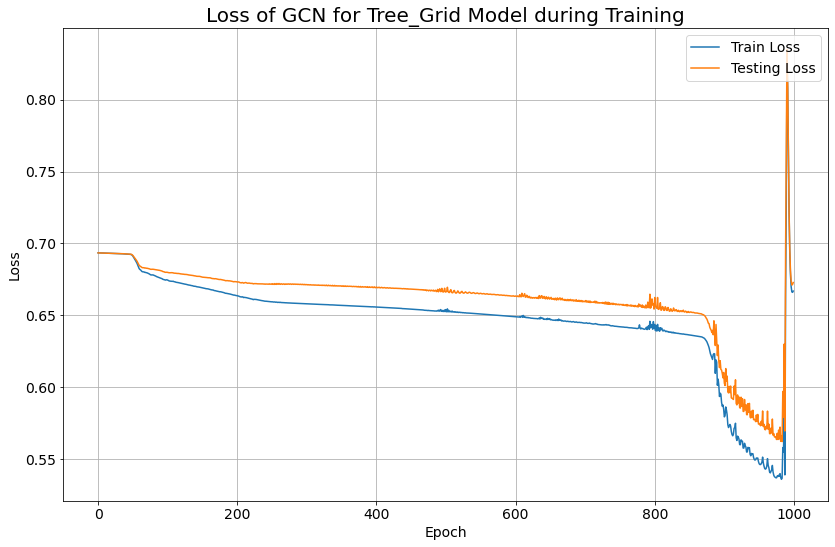

Explanation class 0: ~feature0000000000_0000000018 - acc. = 0.3645 - compl. = 1.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 20, n_clustering: 4, concept_emb_size: 5


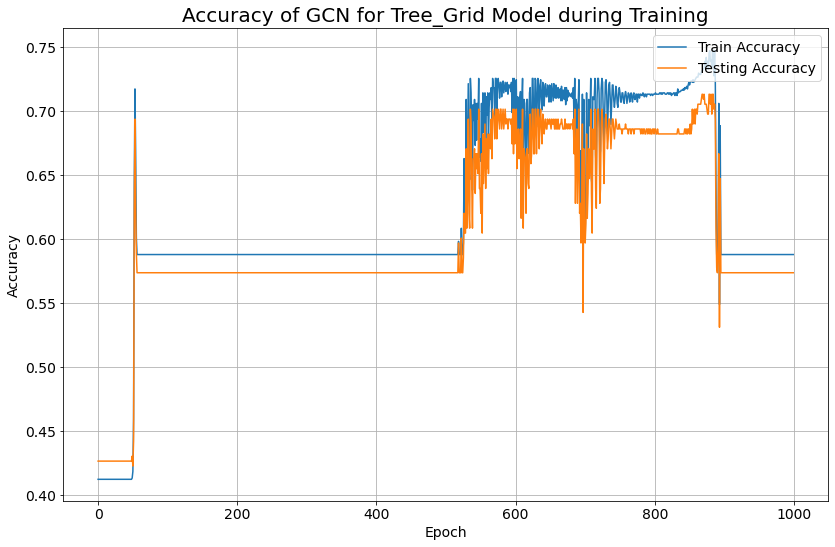

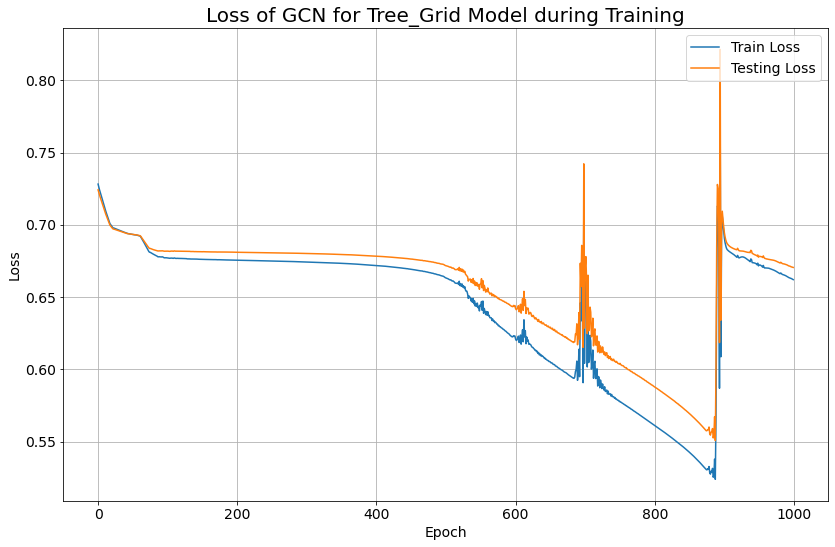

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: feature0000000000_0000000004 - acc. = 0.2989 - compl. = 1.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 20, n_clustering: 4, concept_emb_size: 10


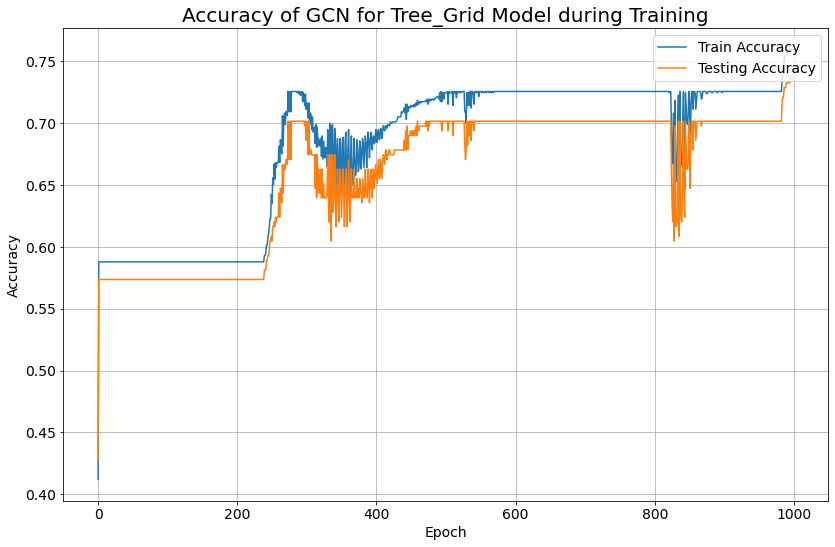

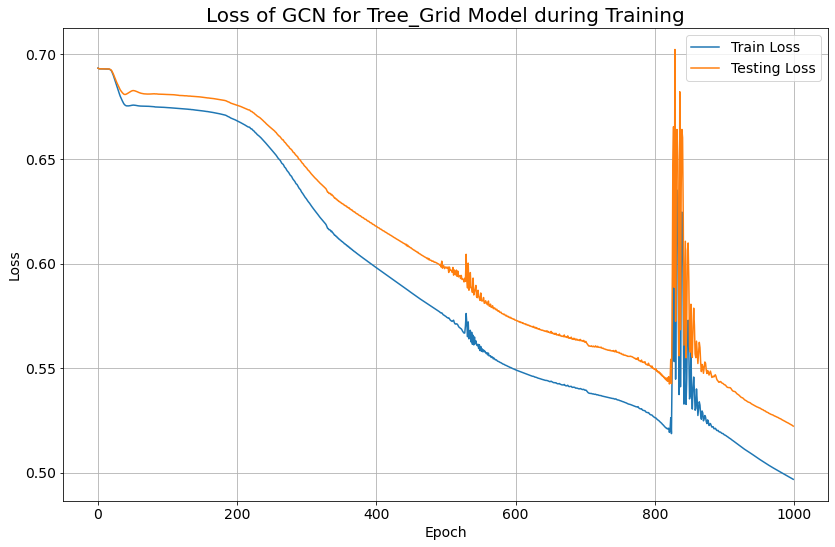

Explanation class 0: ~feature0000000003_0000000008 - acc. = 0.5373 - compl. = 1.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 20, n_clustering: 4, concept_emb_size: 20


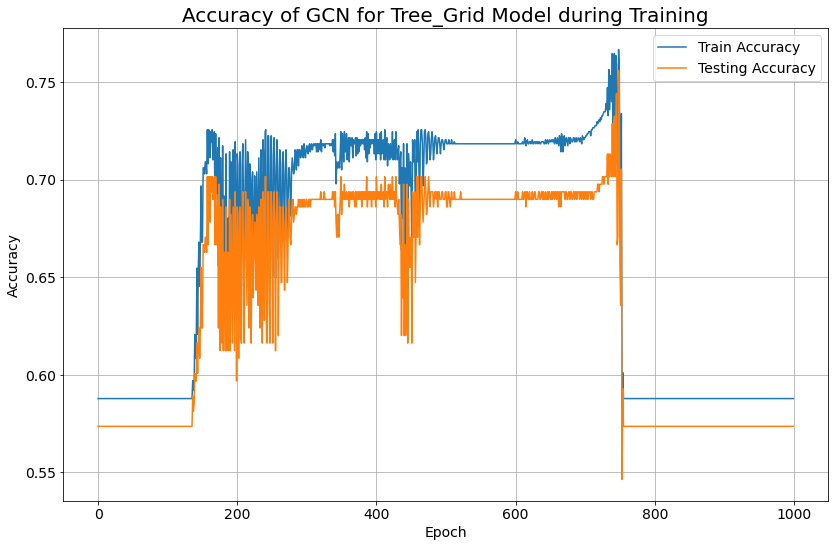

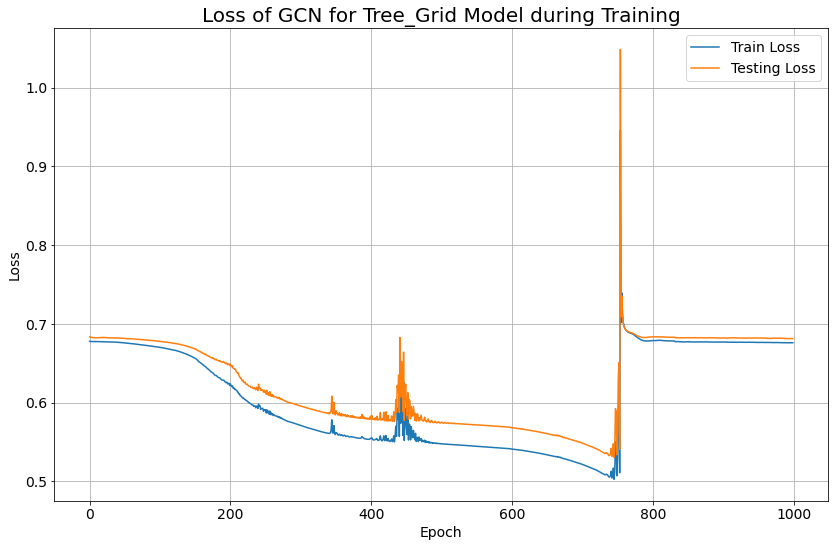

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 30, n_clustering: 2, concept_emb_size: 5


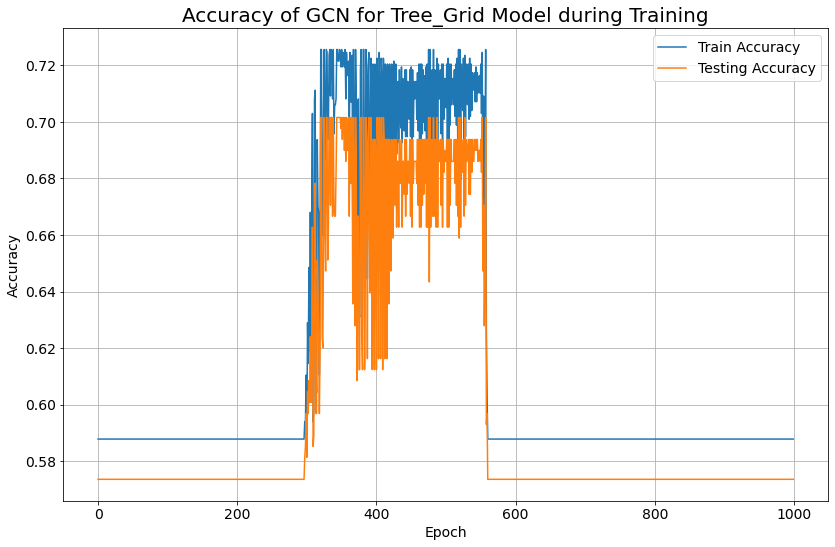

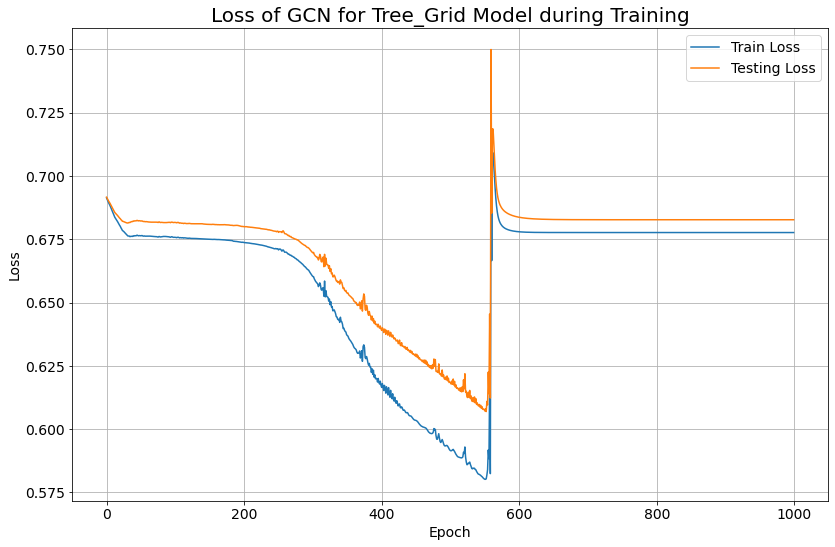

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 30, n_clustering: 2, concept_emb_size: 10


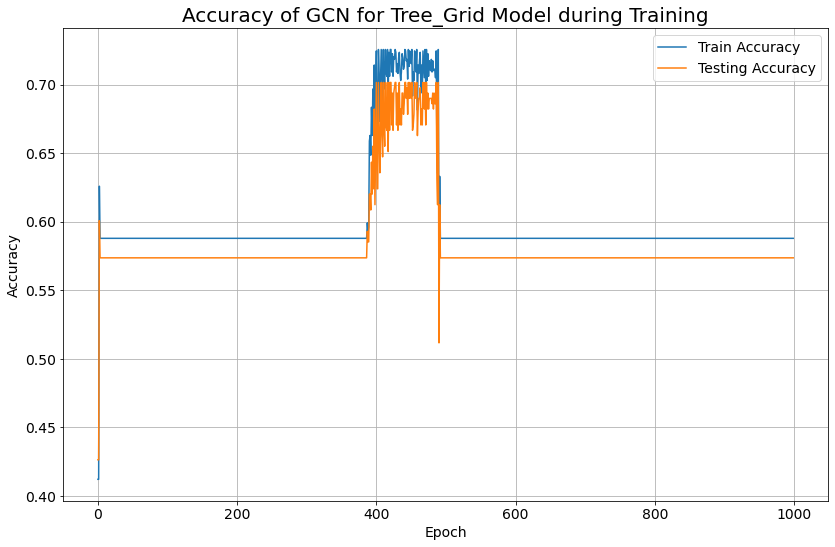

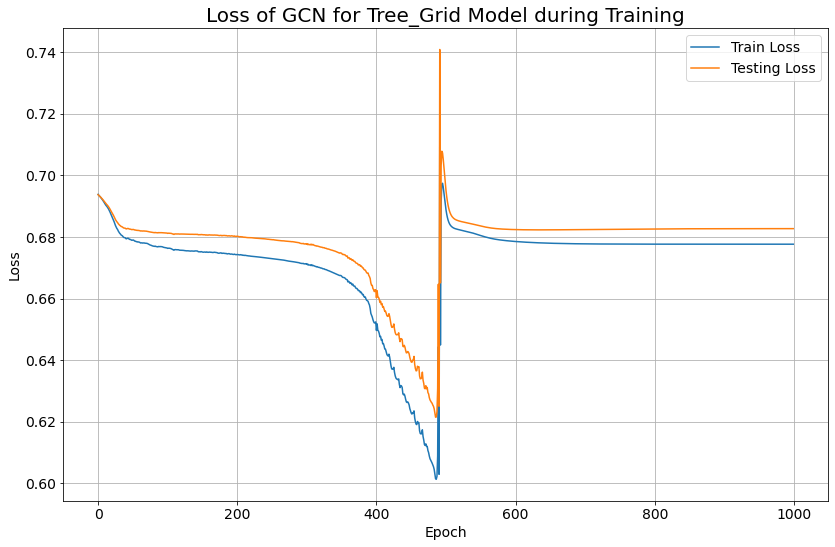

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 30, n_clustering: 2, concept_emb_size: 20


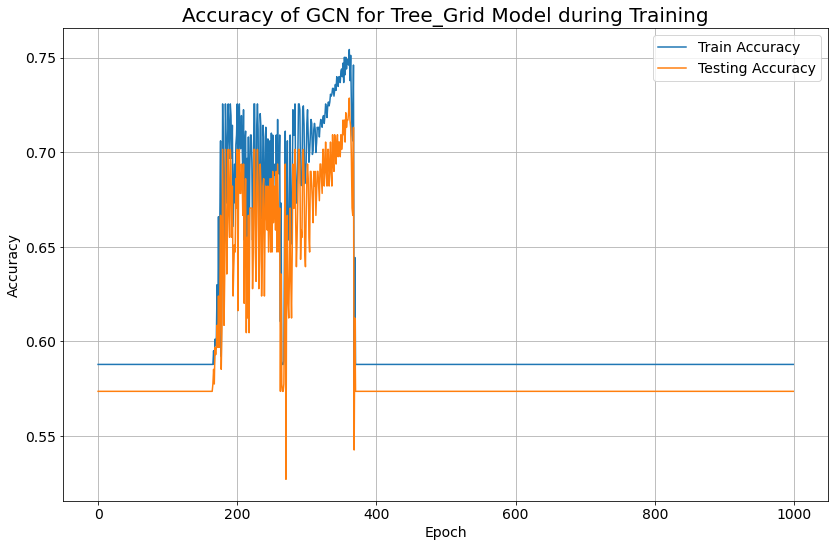

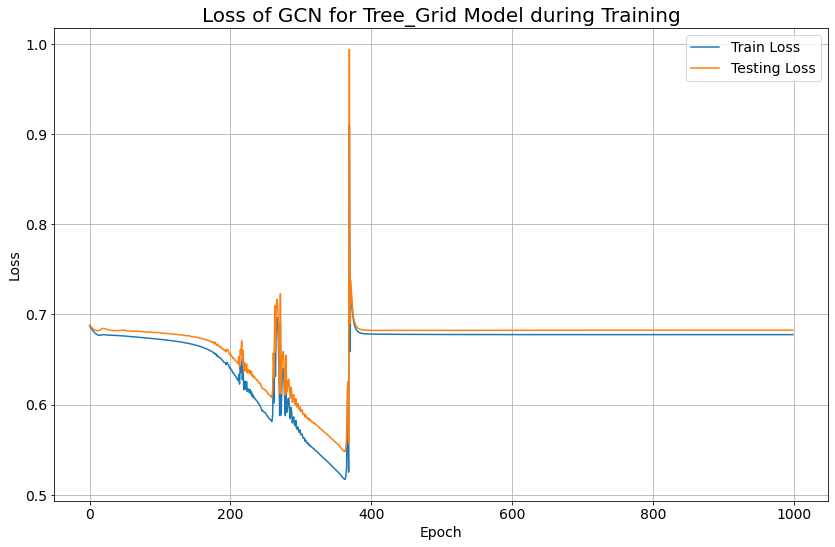

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 30, n_clustering: 3, concept_emb_size: 5


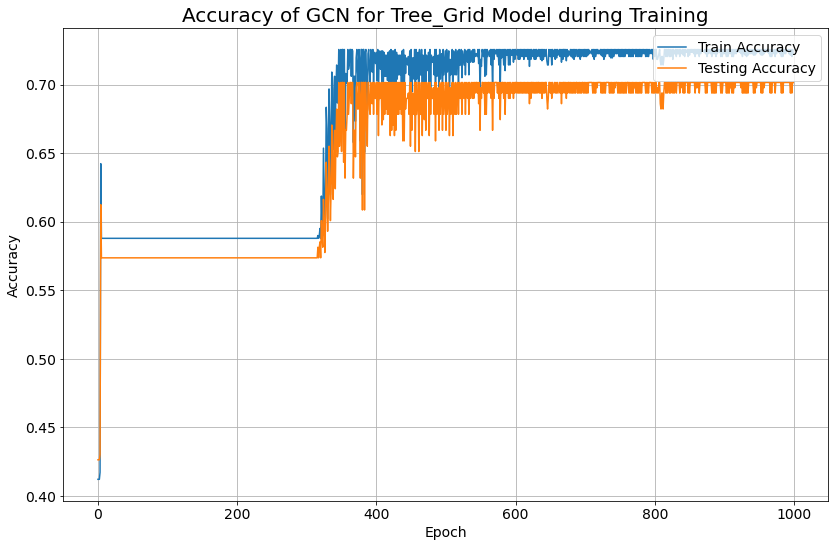

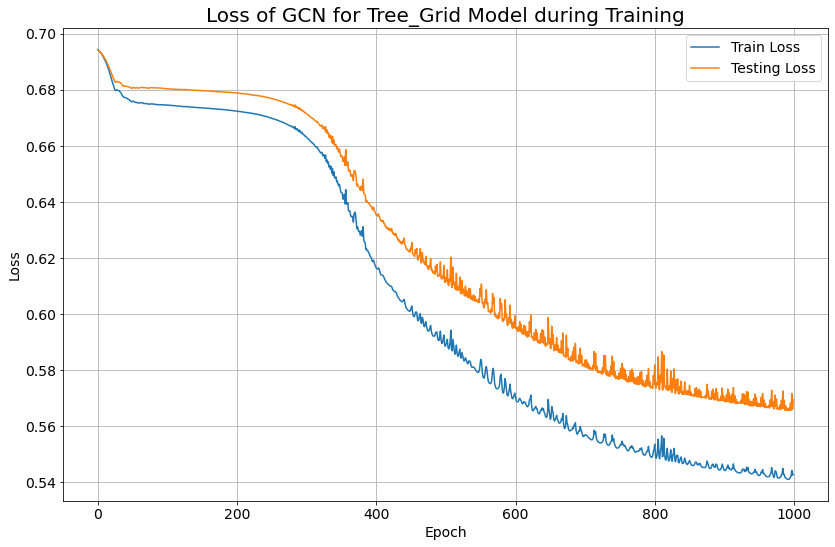

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 30, n_clustering: 3, concept_emb_size: 10


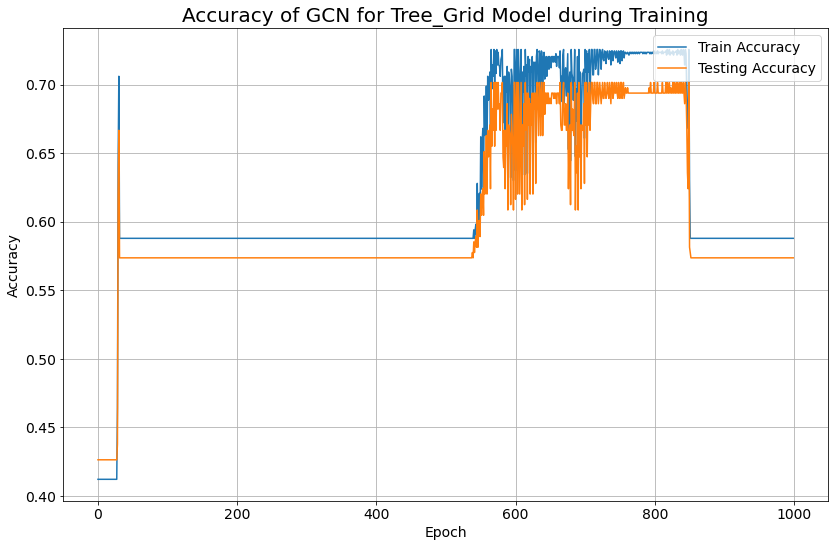

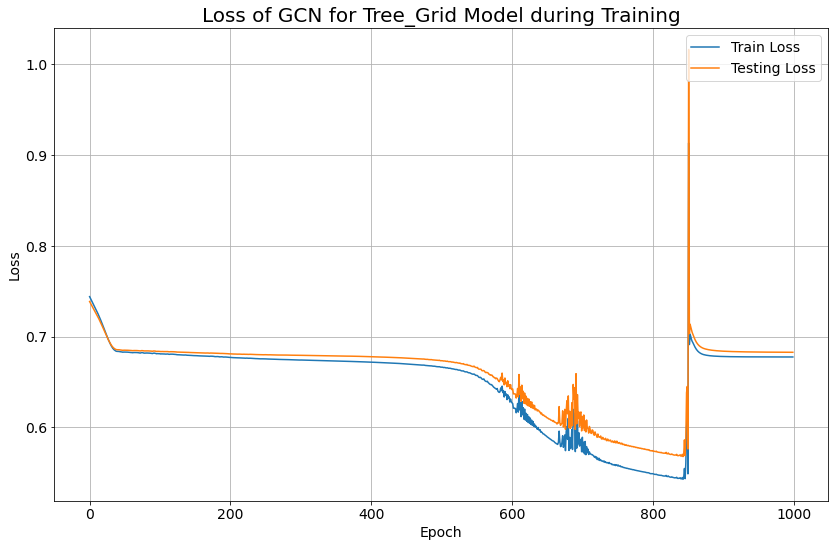

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 30, n_clustering: 3, concept_emb_size: 20


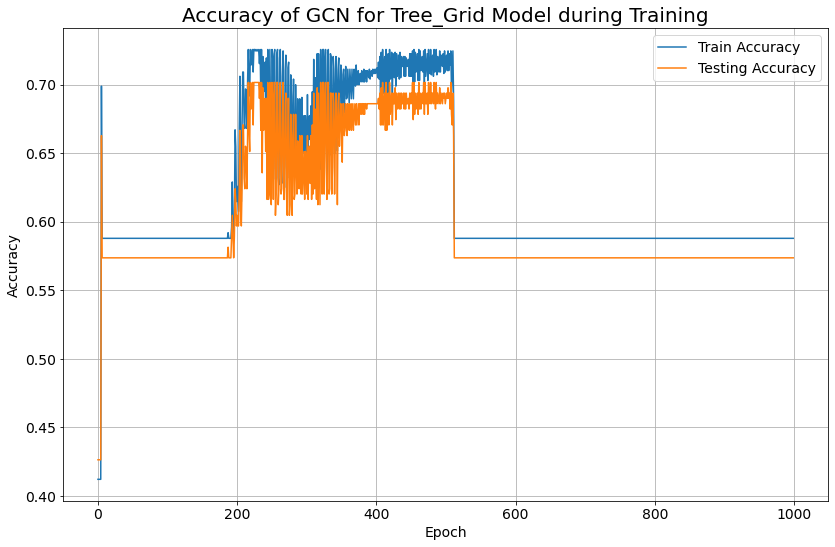

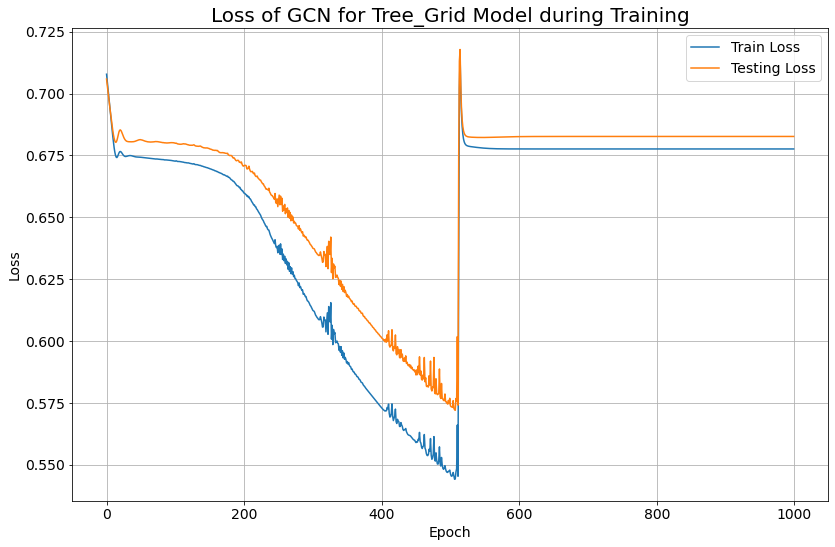

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 30, n_clustering: 4, concept_emb_size: 5


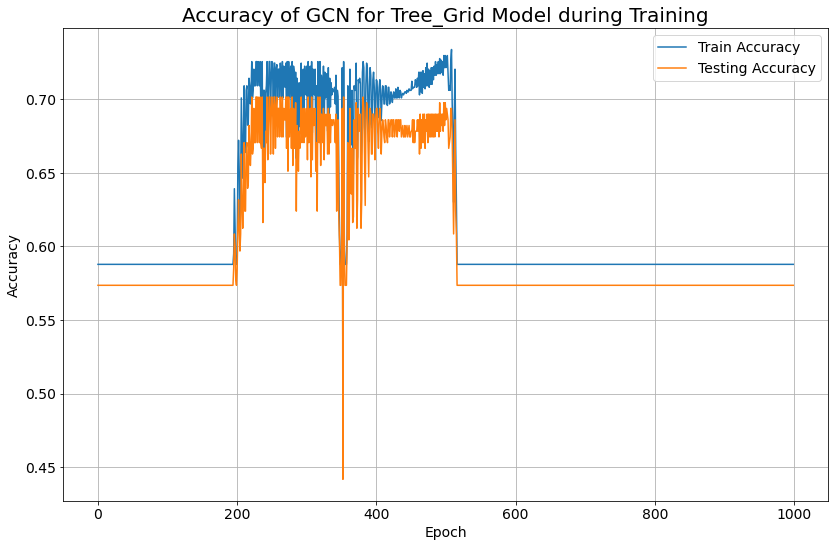

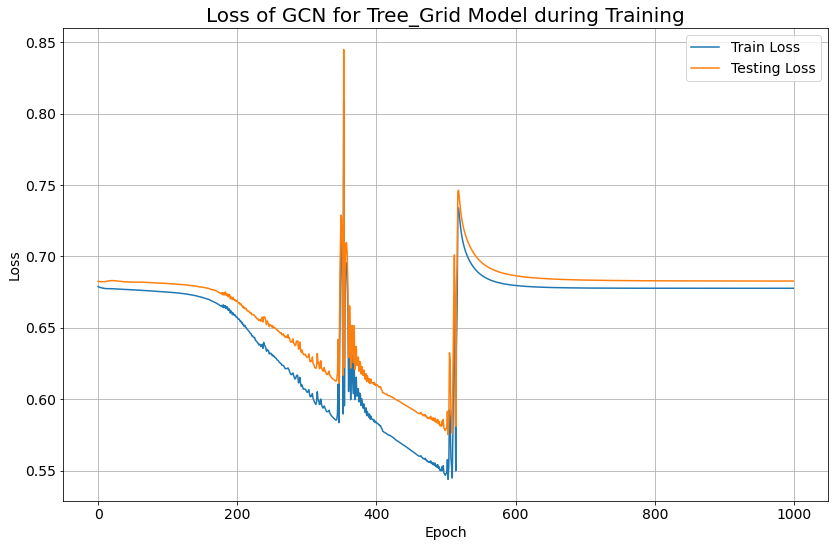

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 30, n_clustering: 4, concept_emb_size: 10


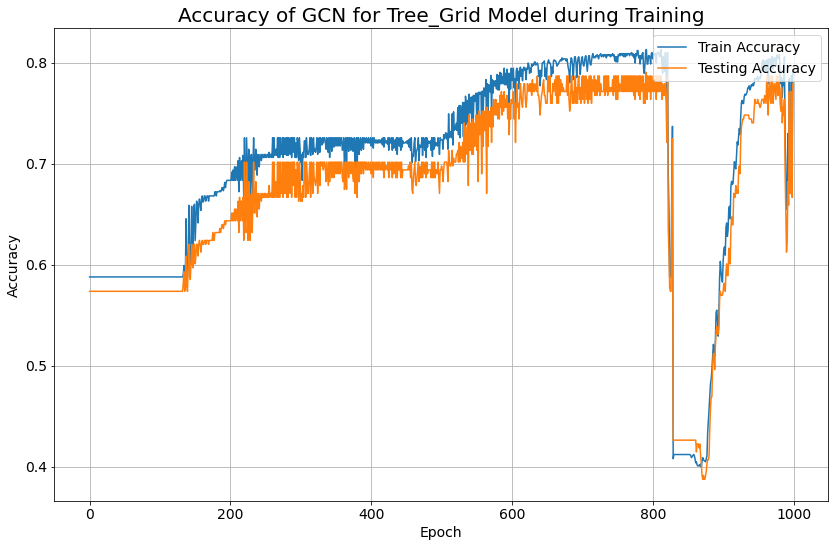

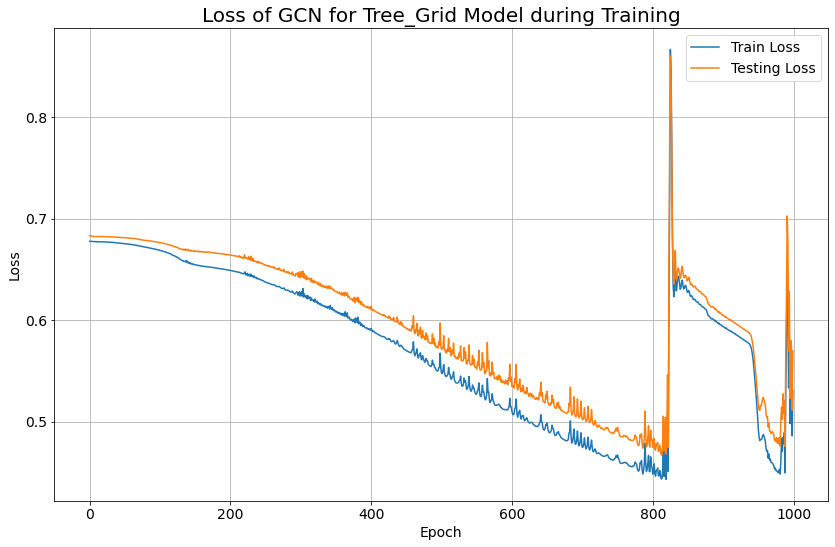

Explanation class 0: feature0000000002_0000000009 - acc. = 0.6700 - compl. = 1.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.001, hu: 30, n_clustering: 4, concept_emb_size: 20


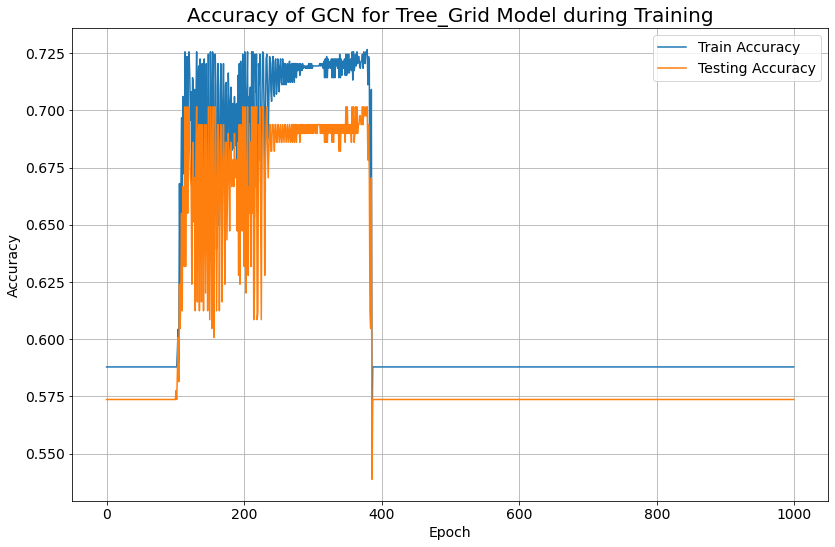

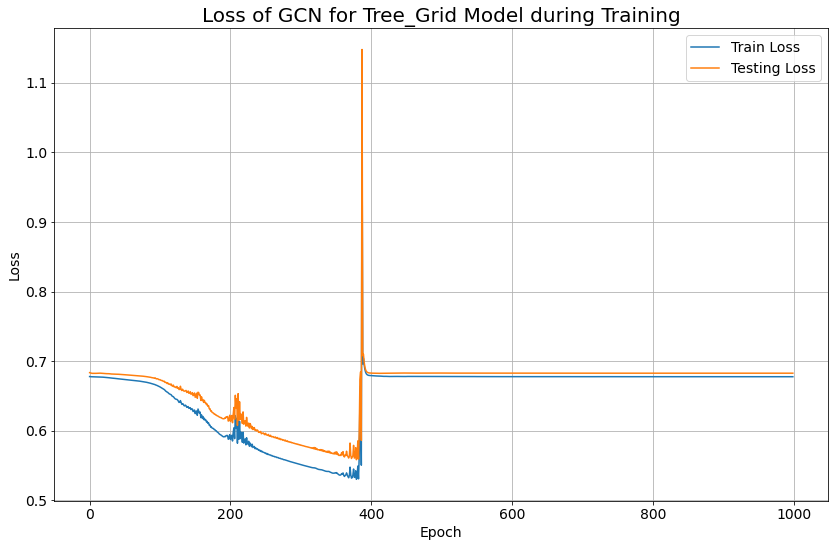

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 10, n_clustering: 2, concept_emb_size: 5


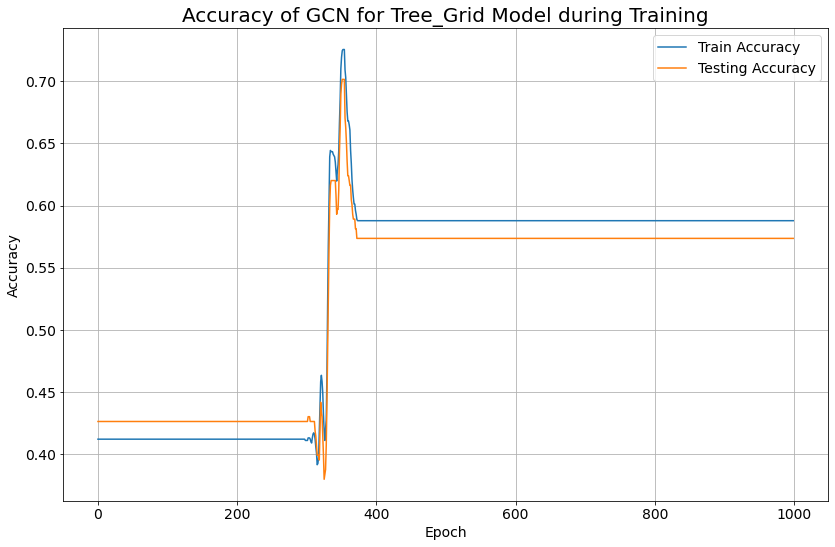

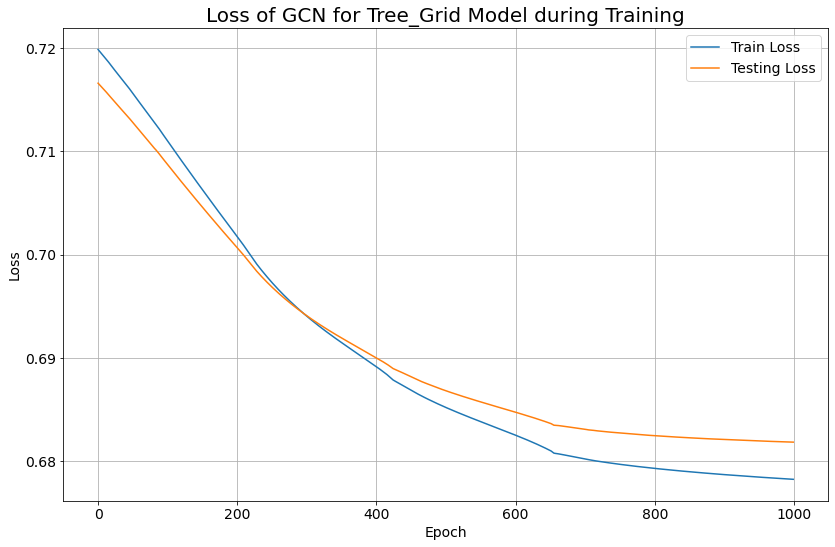

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 10, n_clustering: 2, concept_emb_size: 10


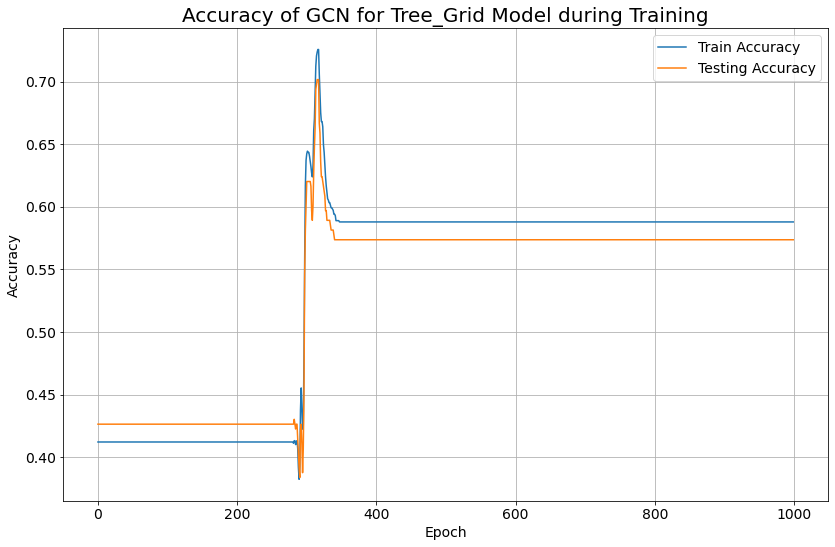

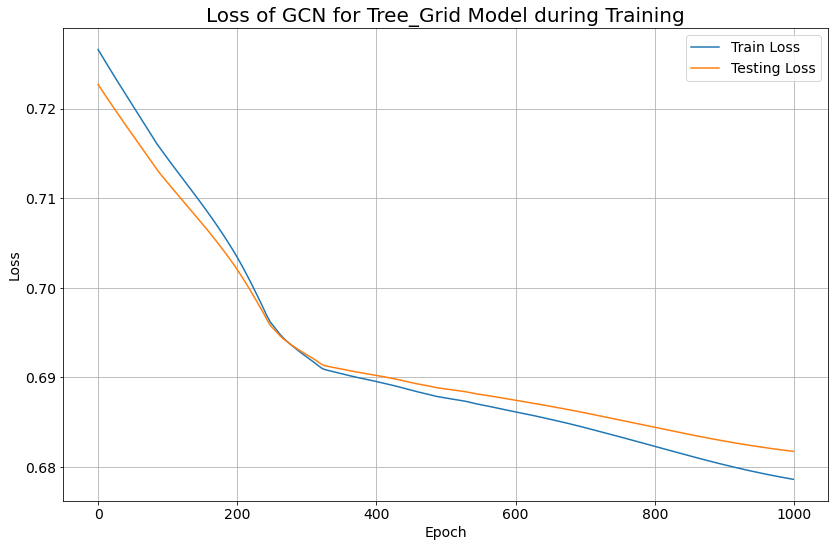

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: ~feature0000000001_0000000007 - acc. = 0.2989 - compl. = 1.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 10, n_clustering: 2, concept_emb_size: 20


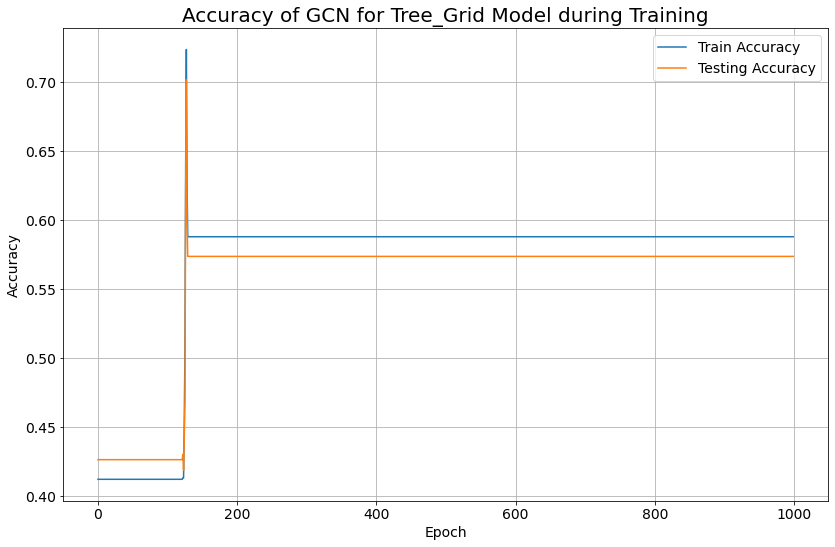

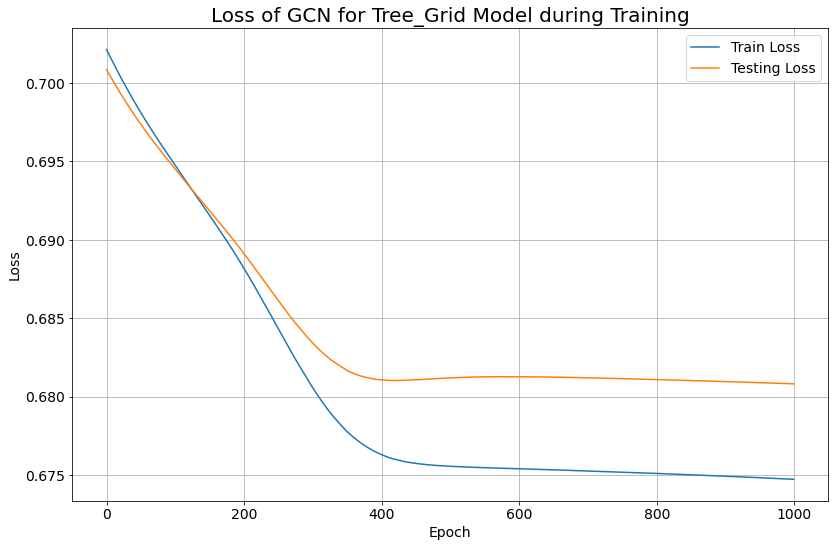

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 10, n_clustering: 3, concept_emb_size: 5


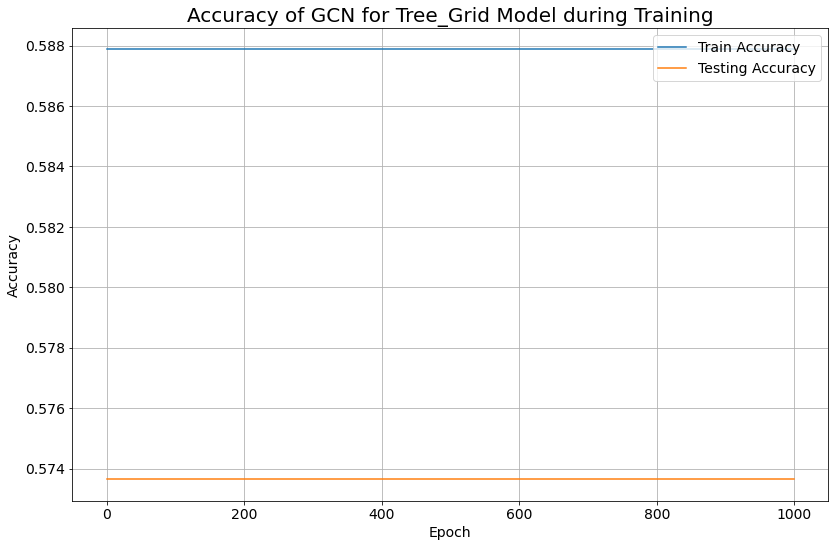

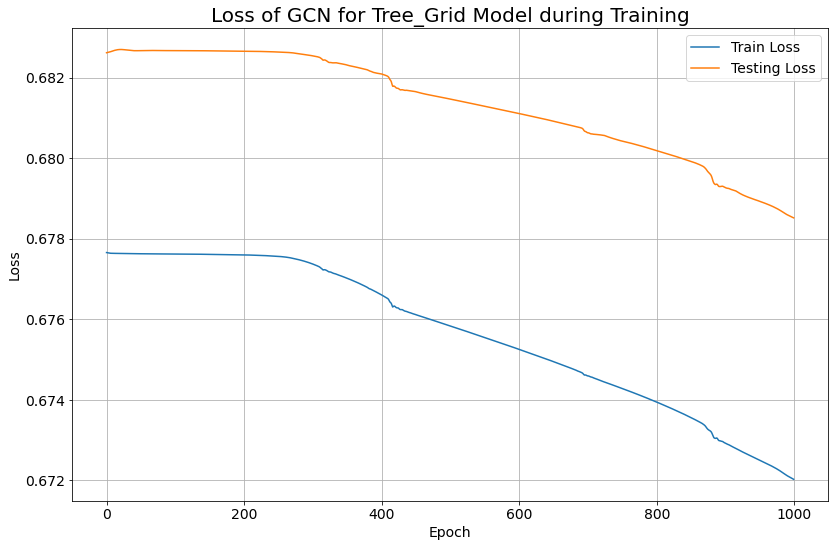

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 10, n_clustering: 3, concept_emb_size: 10


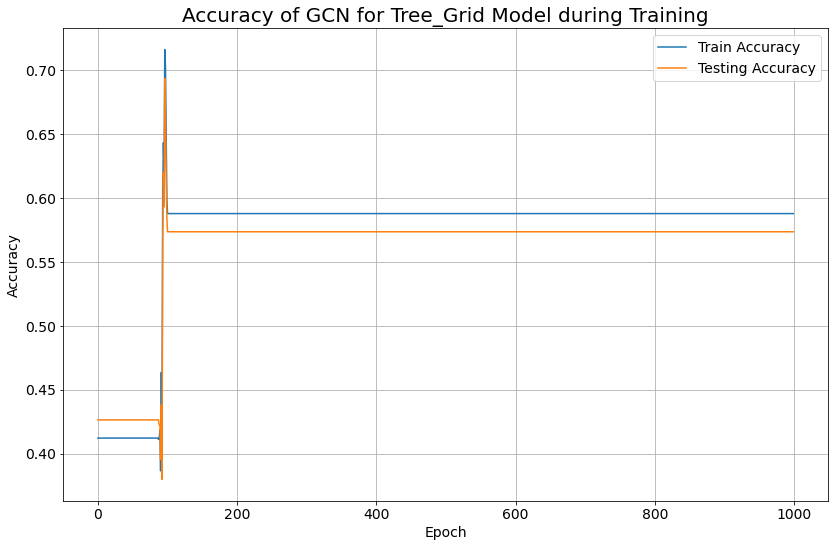

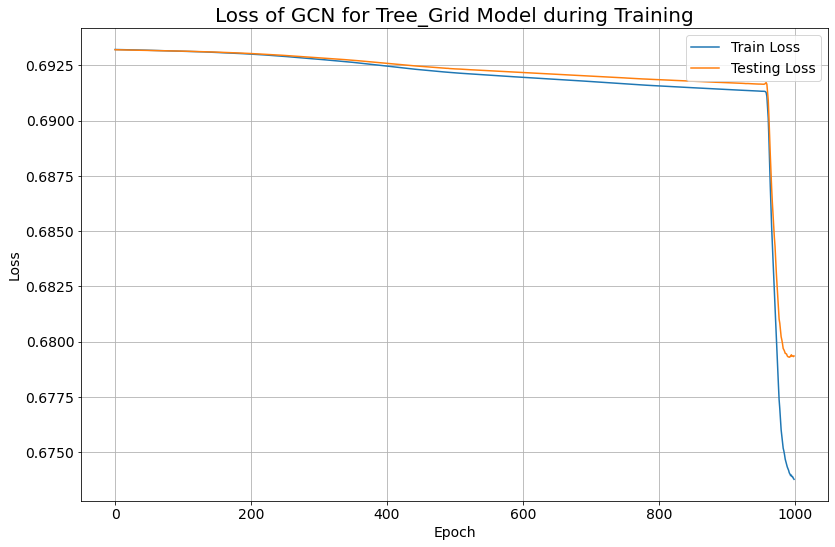

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: feature0000000000_0000000009 | ~feature0000000000_0000000009 - acc. = 0.3645 - compl. = 2.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 10, n_clustering: 3, concept_emb_size: 20


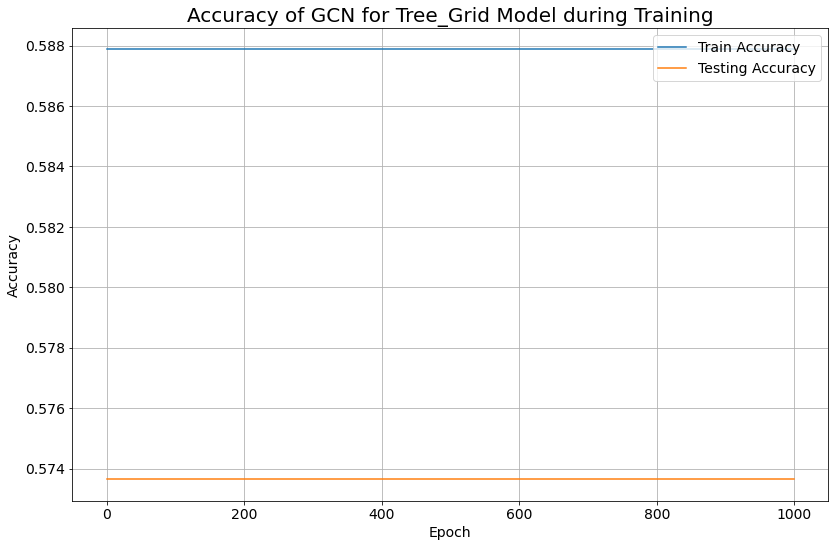

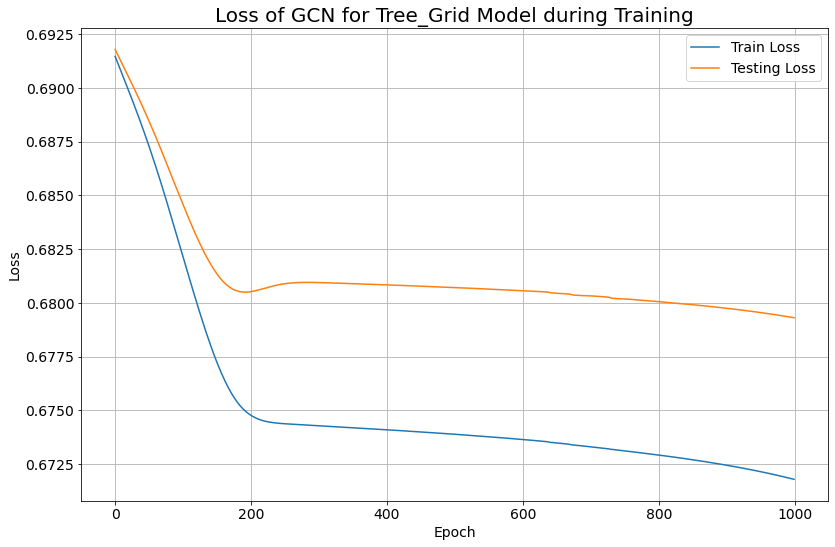

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 10, n_clustering: 4, concept_emb_size: 5


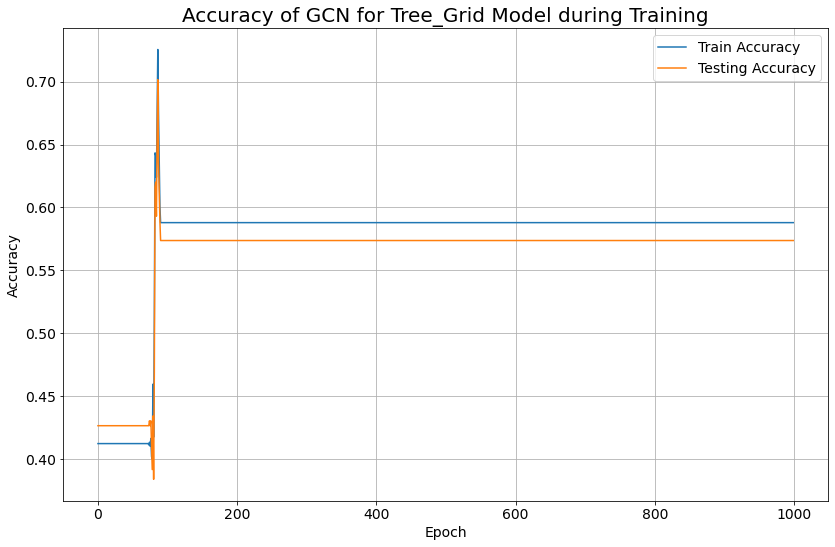

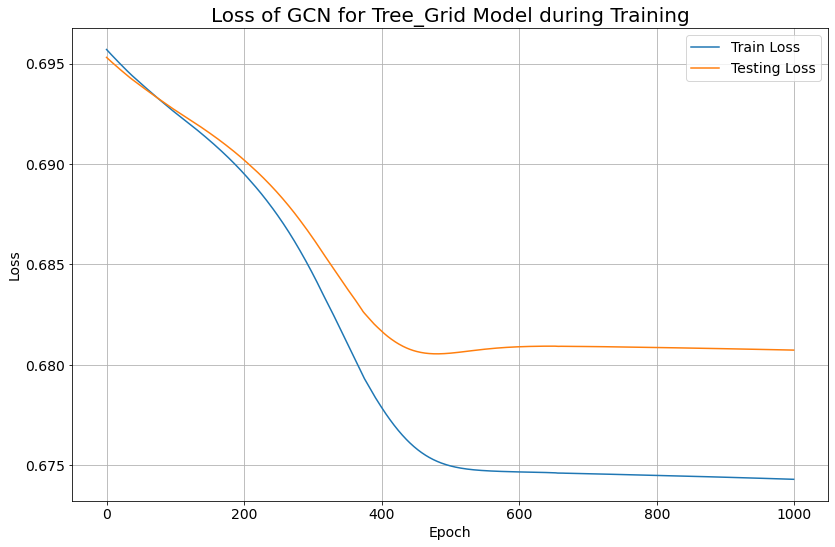

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 10, n_clustering: 4, concept_emb_size: 10


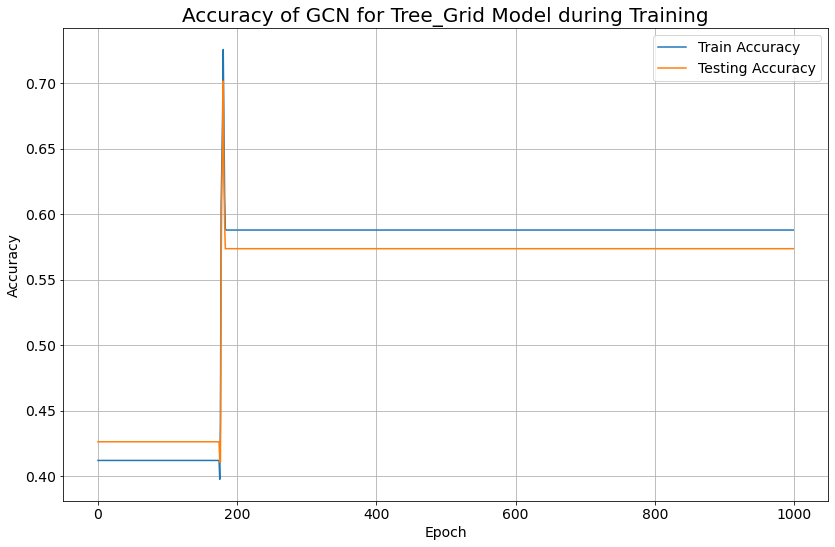

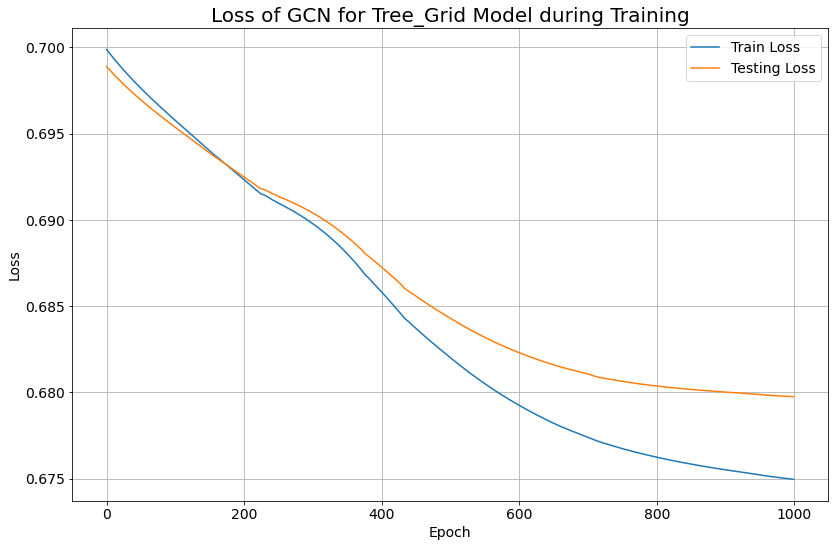

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 10, n_clustering: 4, concept_emb_size: 20


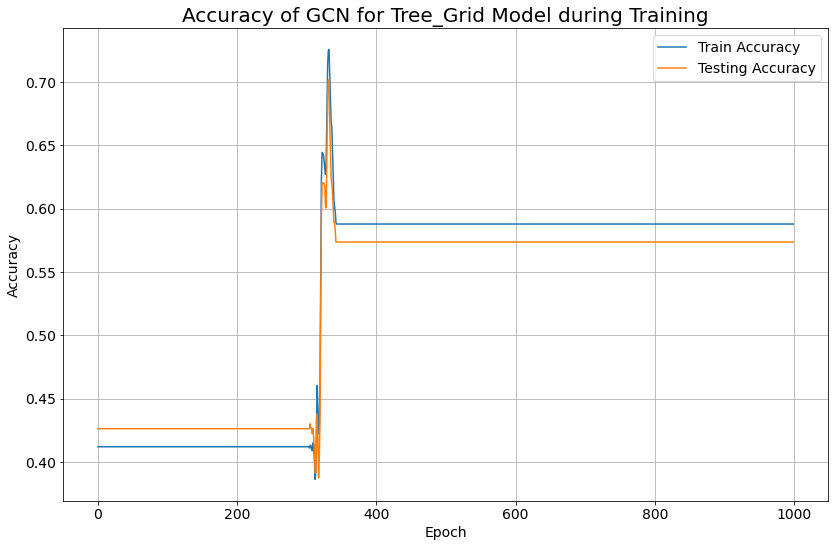

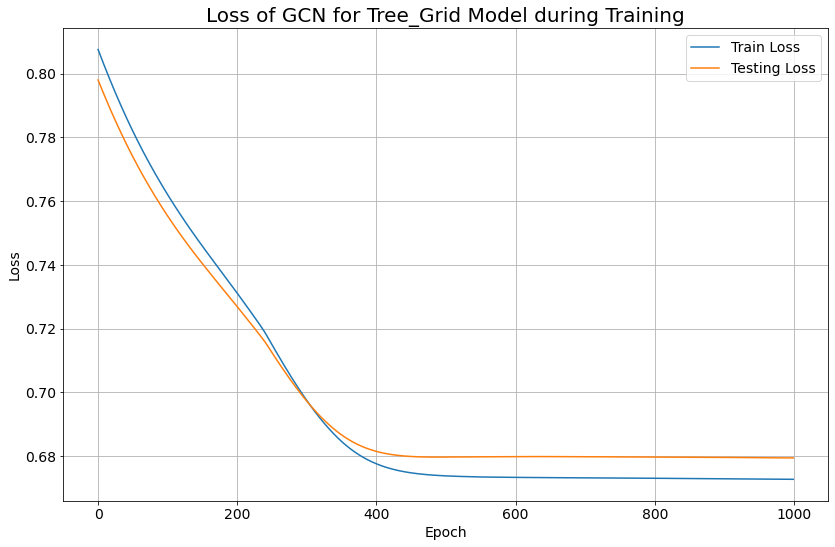

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 20, n_clustering: 2, concept_emb_size: 5


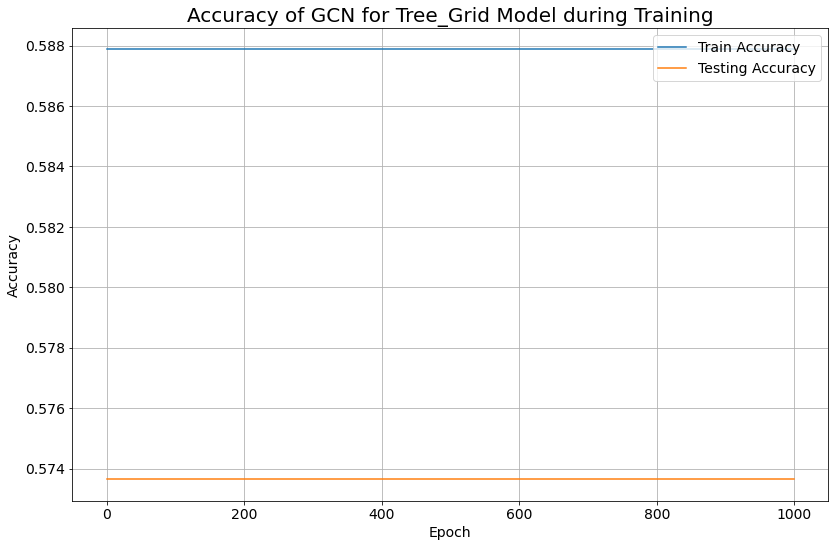

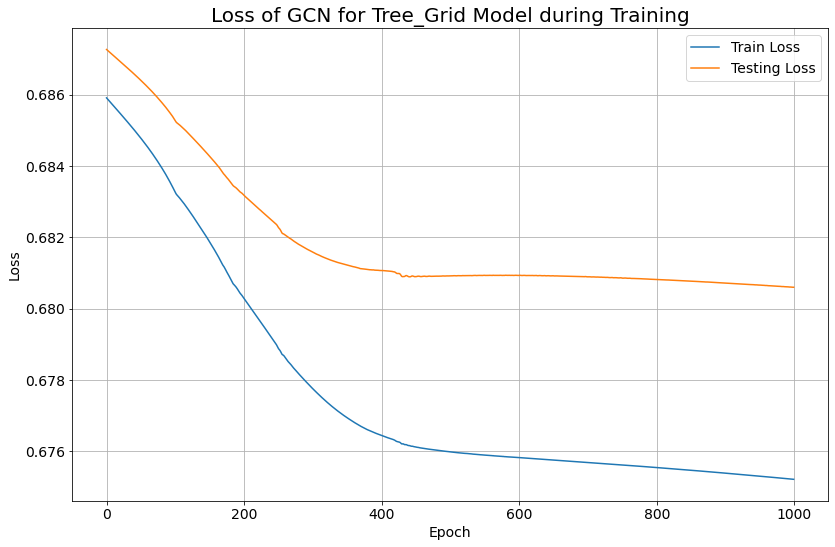

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 20, n_clustering: 2, concept_emb_size: 10


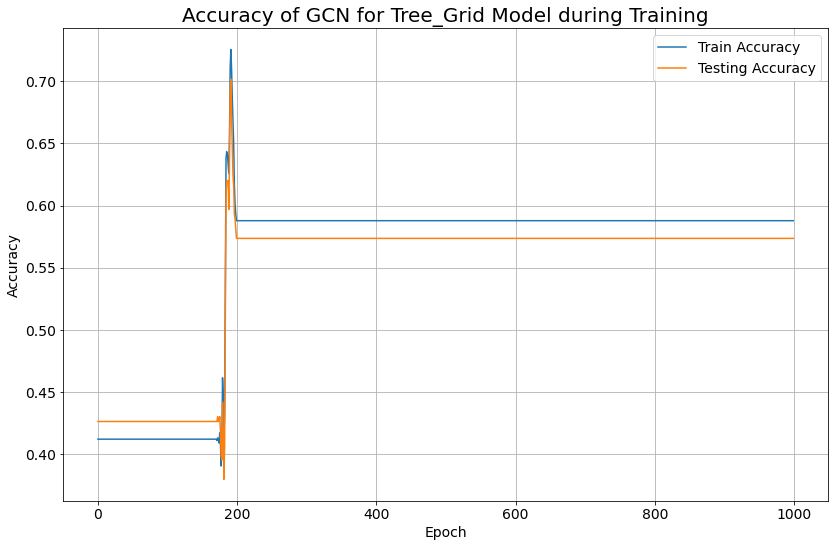

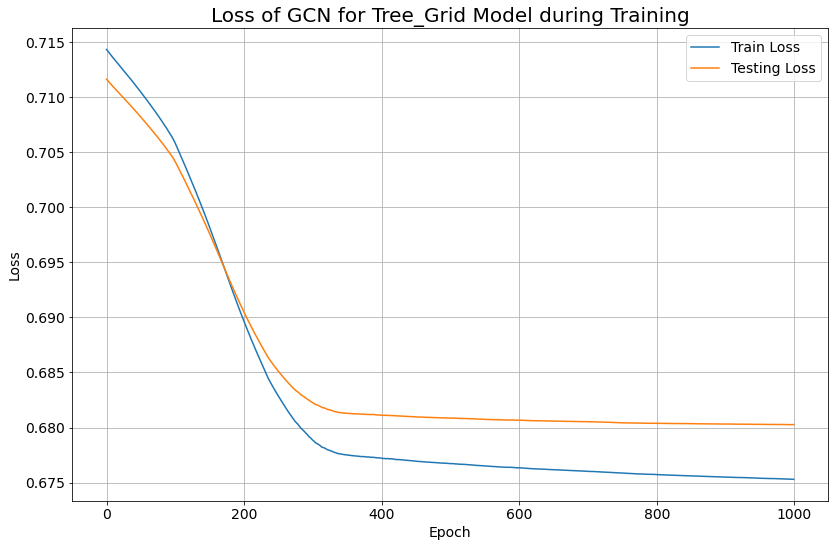

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 20, n_clustering: 2, concept_emb_size: 20


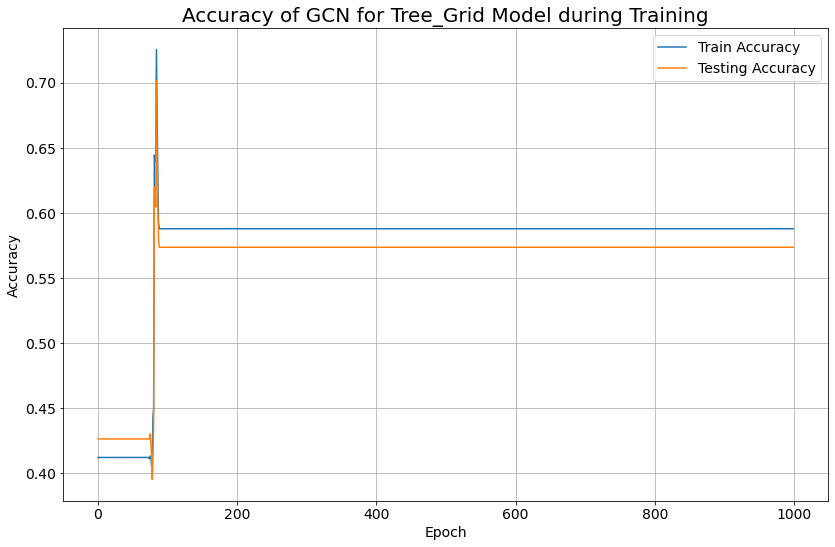

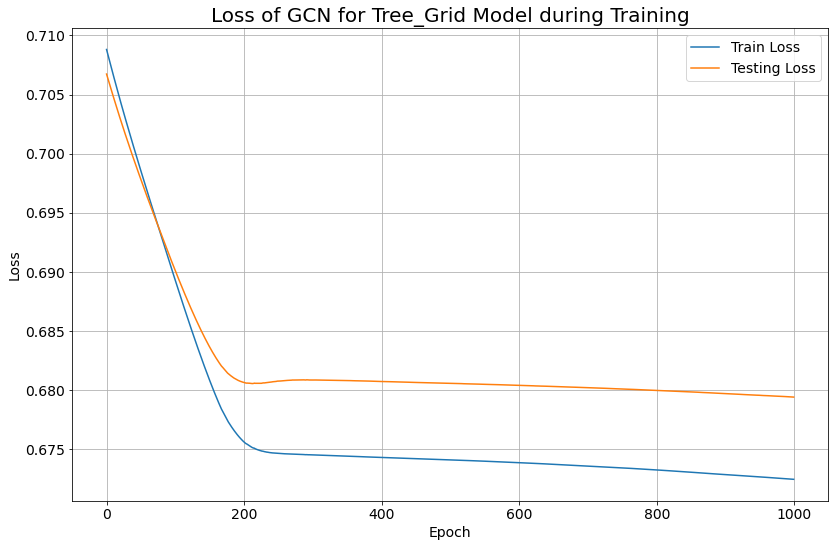

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 20, n_clustering: 3, concept_emb_size: 5


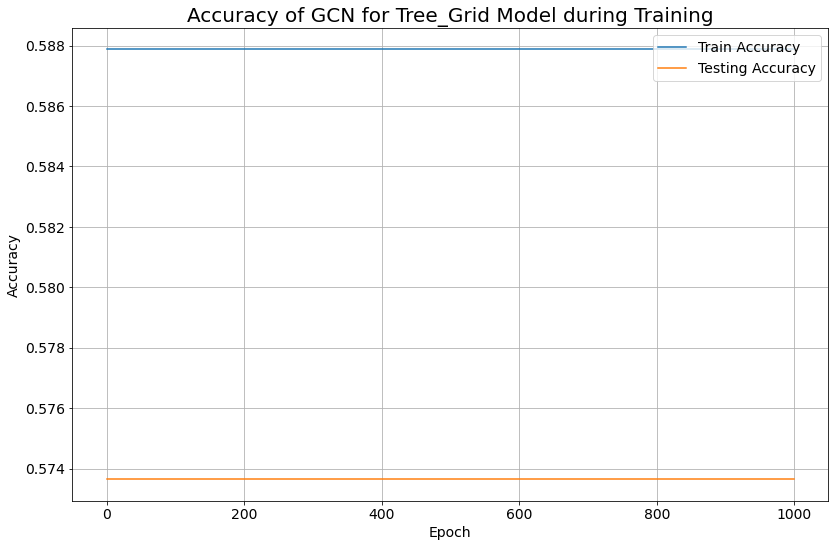

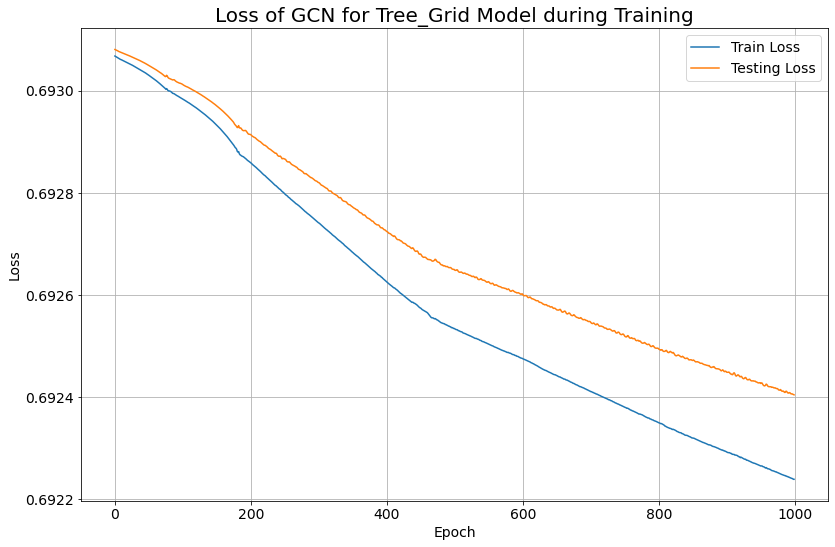

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 20, n_clustering: 3, concept_emb_size: 10


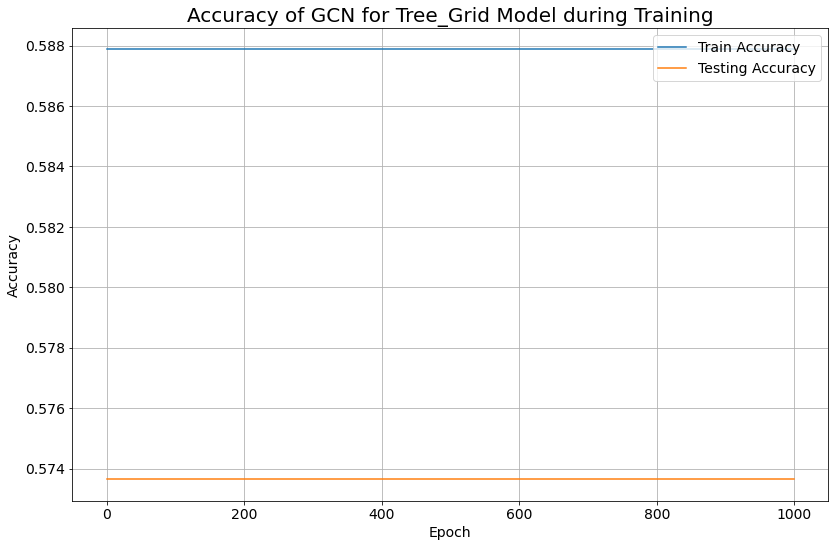

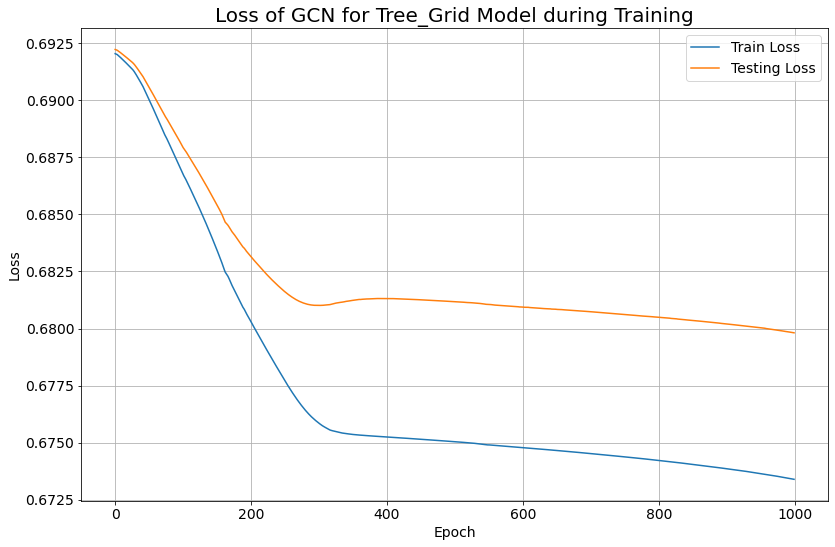

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 20, n_clustering: 3, concept_emb_size: 20


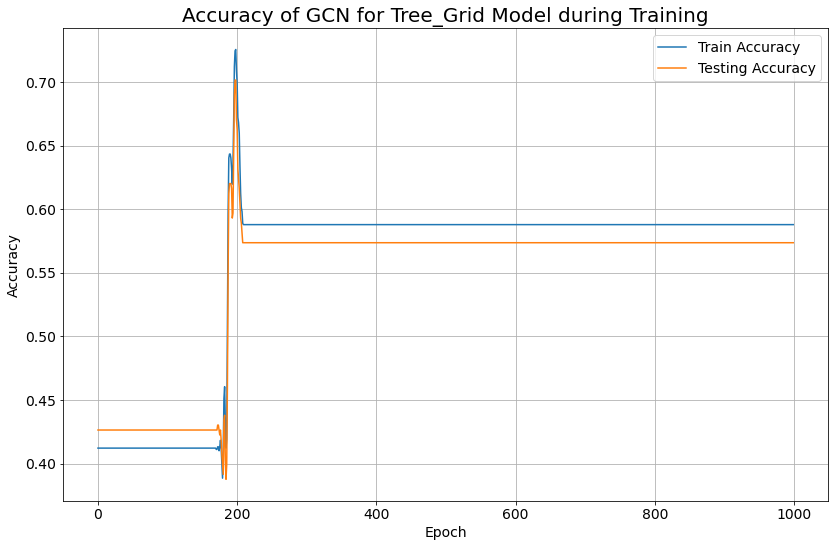

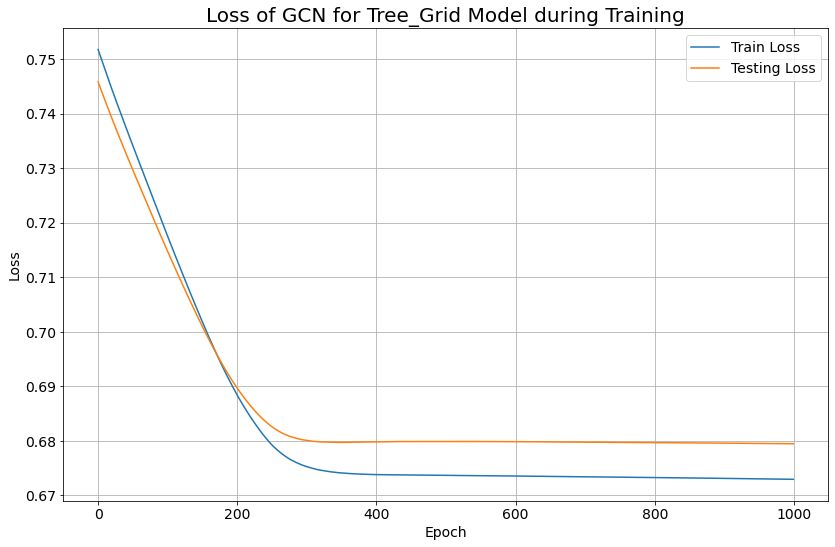

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 20, n_clustering: 4, concept_emb_size: 5


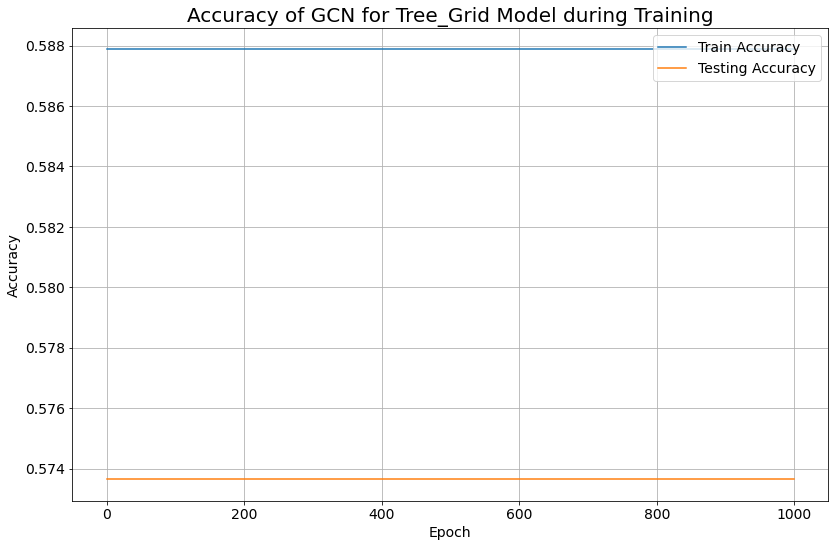

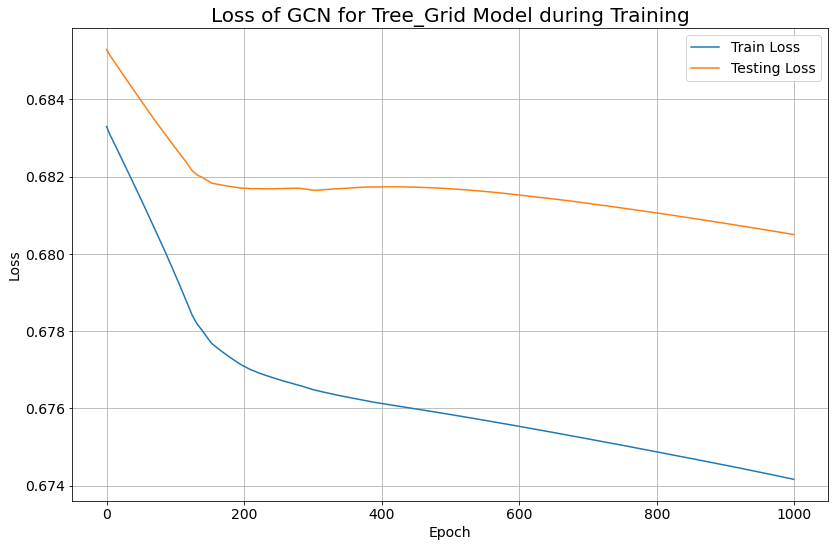

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 20, n_clustering: 4, concept_emb_size: 10


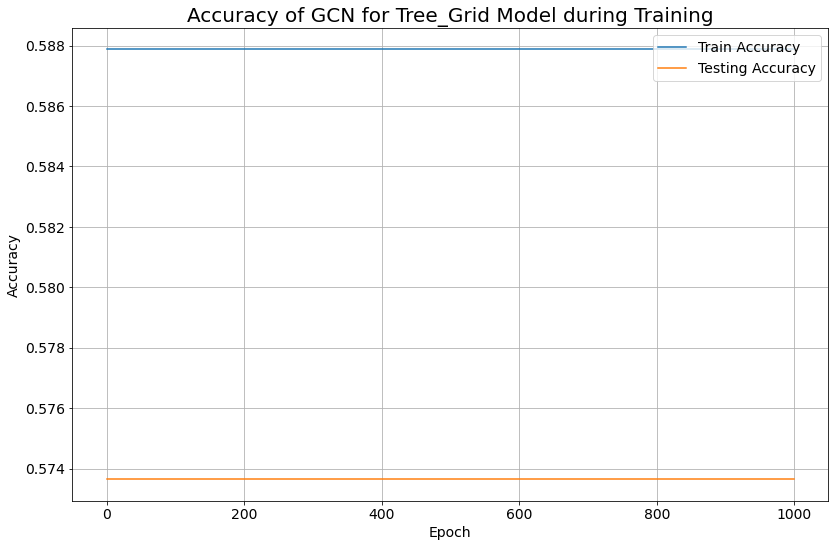

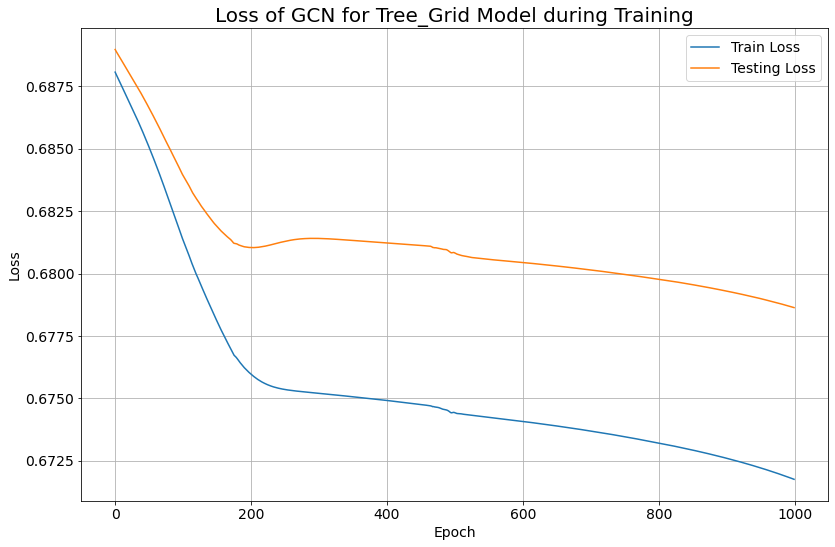

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: ~feature0000000002_0000000008 - acc. = 0.2989 - compl. = 1.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 20, n_clustering: 4, concept_emb_size: 20


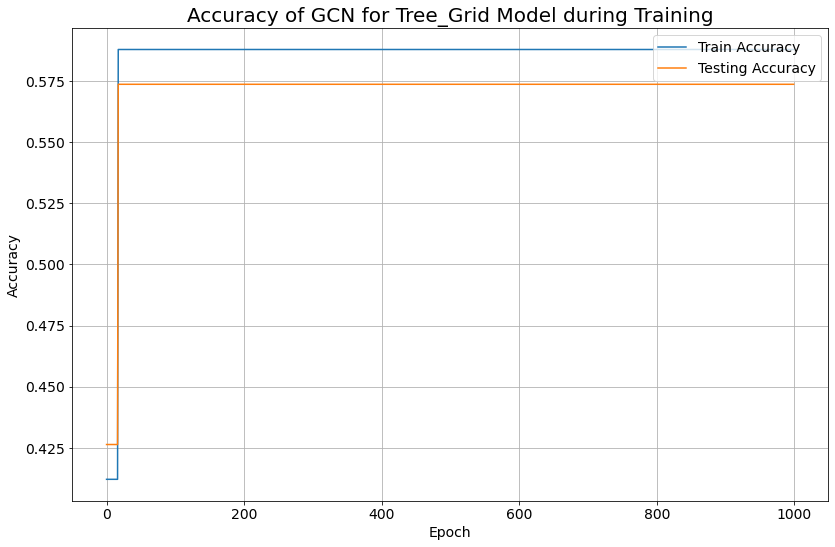

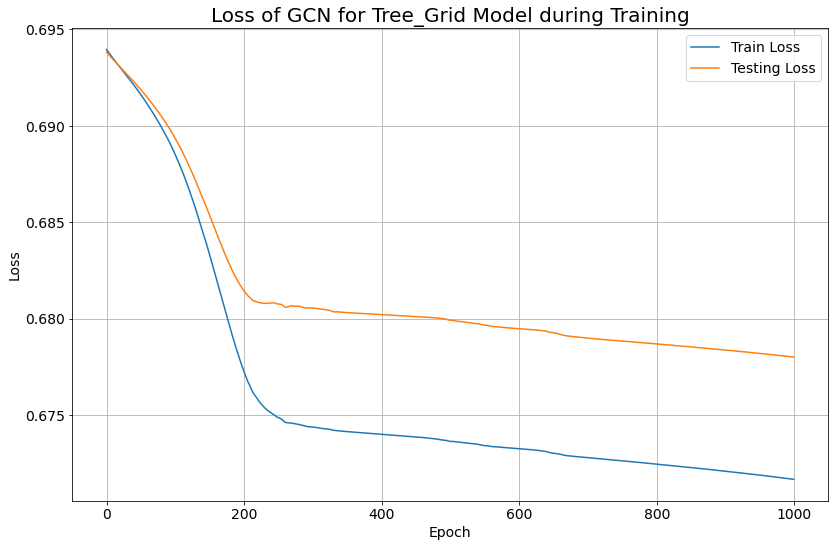

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 30, n_clustering: 2, concept_emb_size: 5


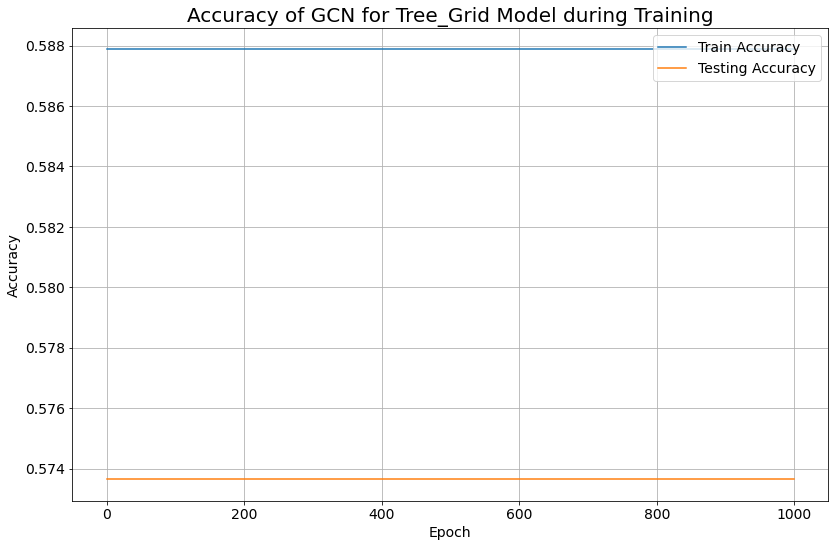

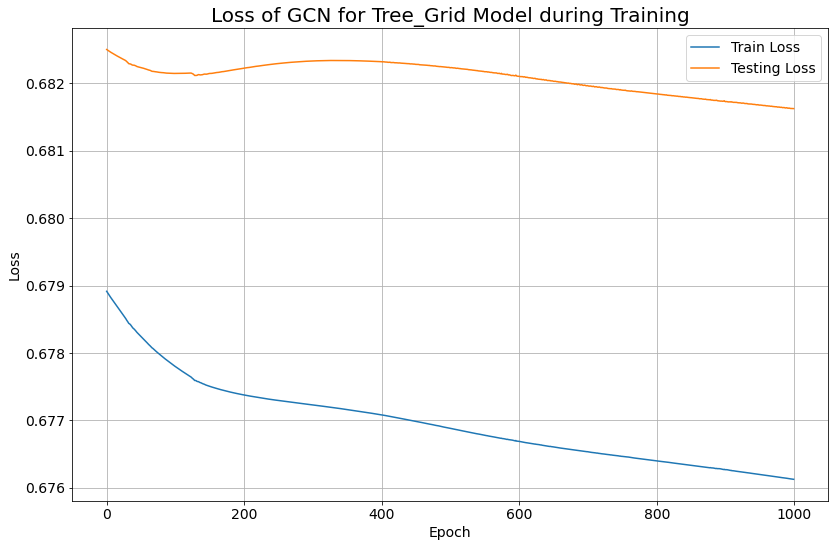

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 30, n_clustering: 2, concept_emb_size: 10


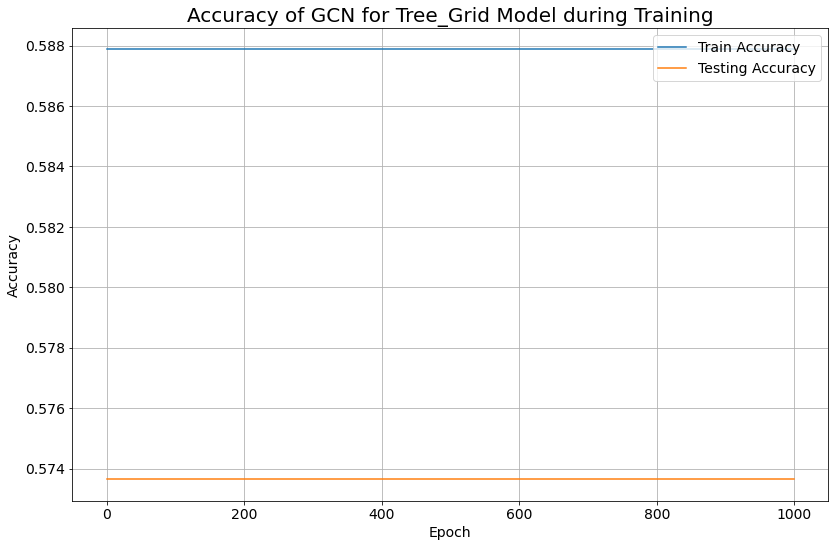

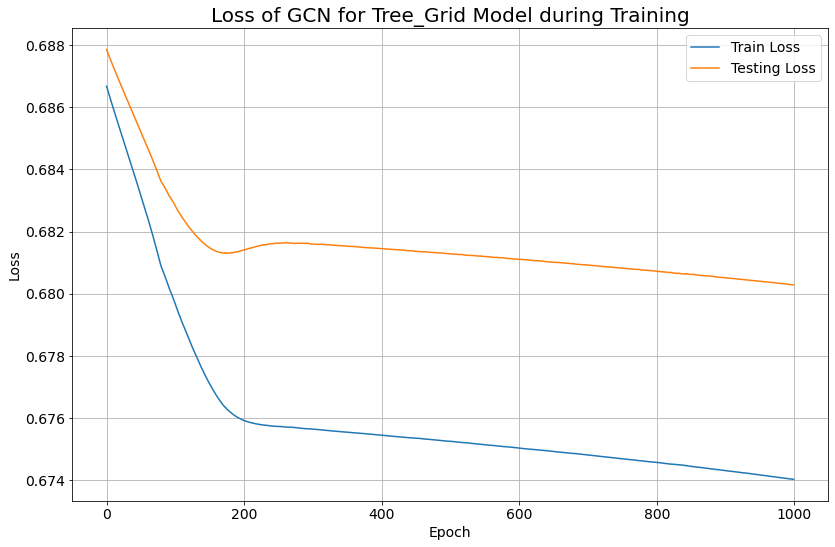

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 30, n_clustering: 2, concept_emb_size: 20


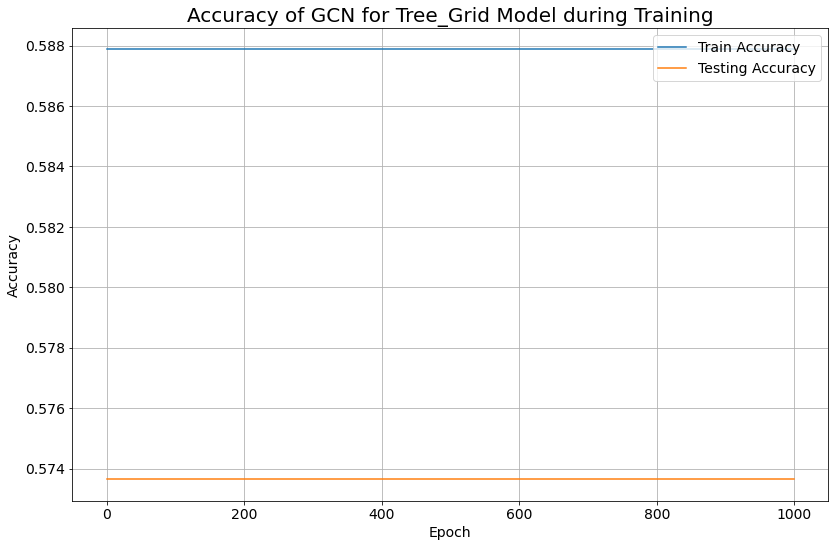

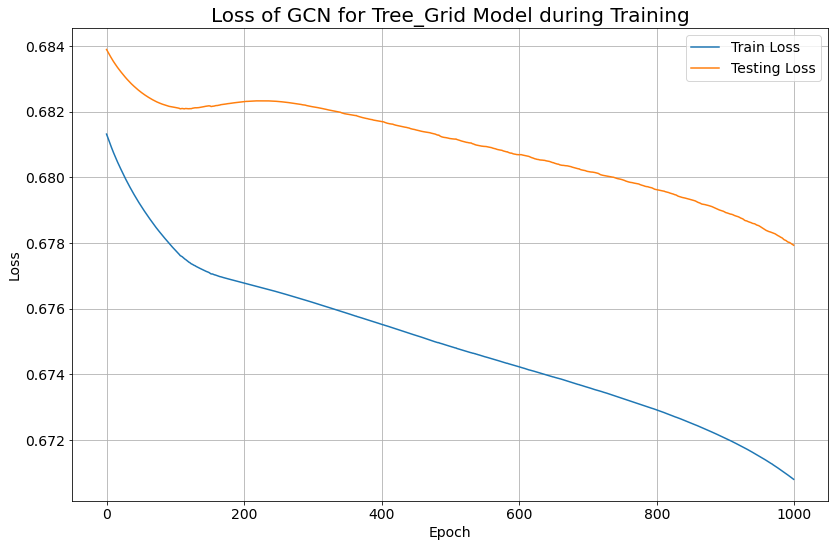

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: ~feature0000000001_0000000019 - acc. = 0.6053 - compl. = 1.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 30, n_clustering: 3, concept_emb_size: 5


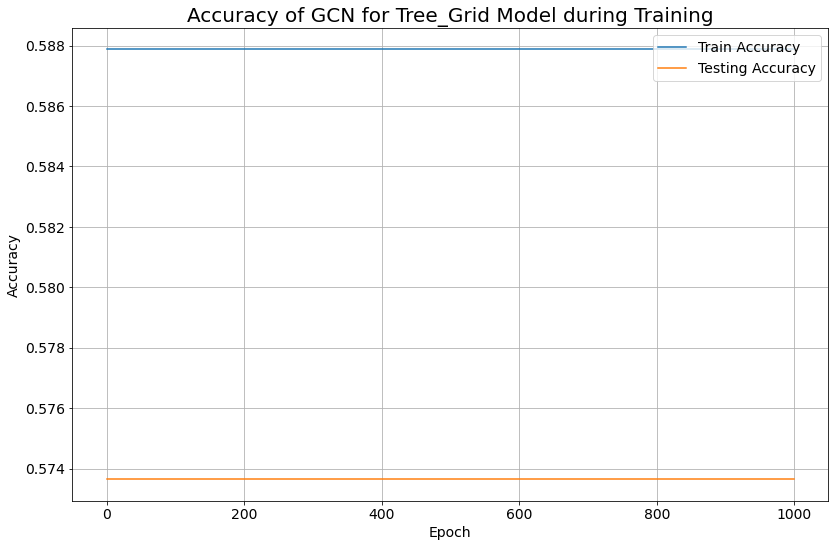

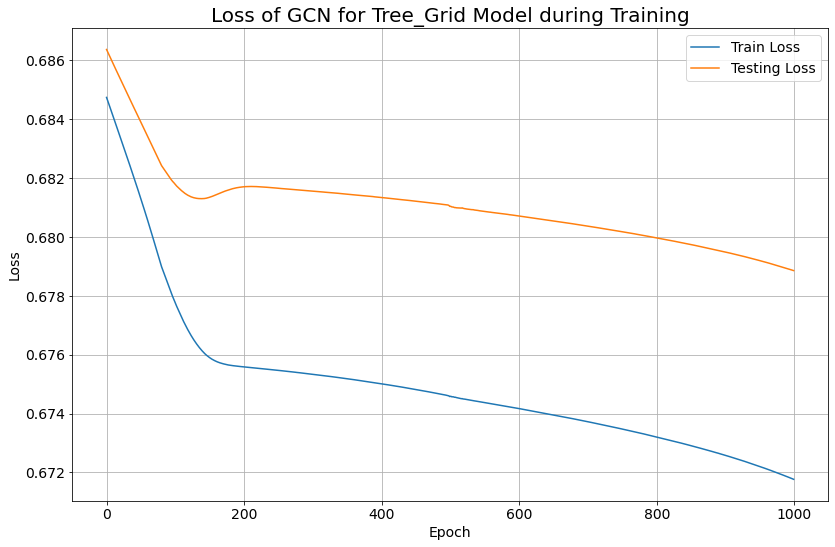

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 30, n_clustering: 3, concept_emb_size: 10


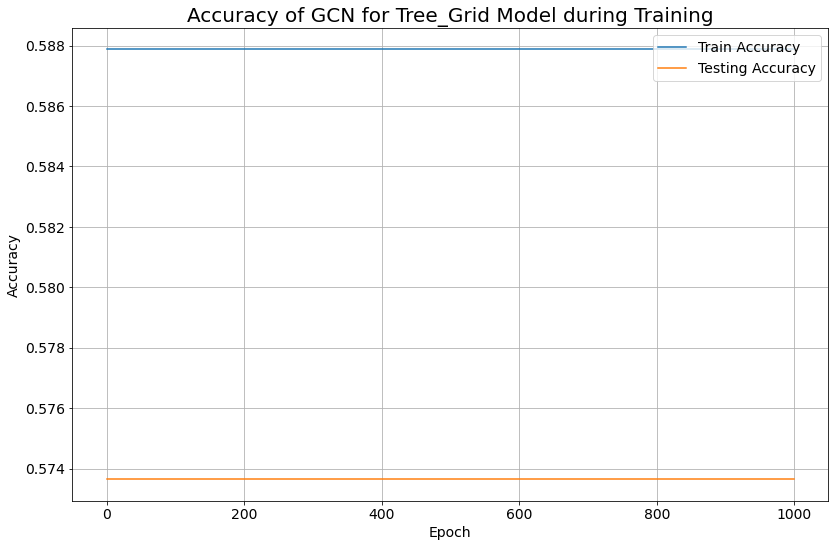

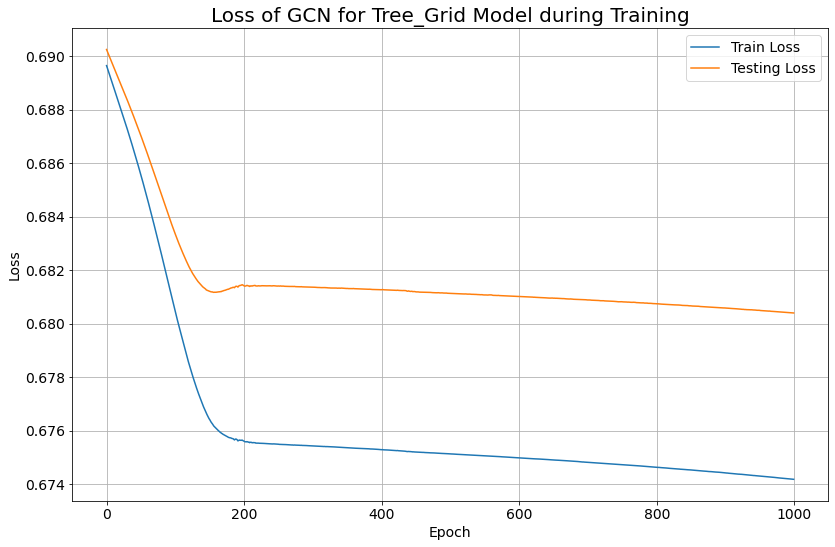

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 30, n_clustering: 3, concept_emb_size: 20


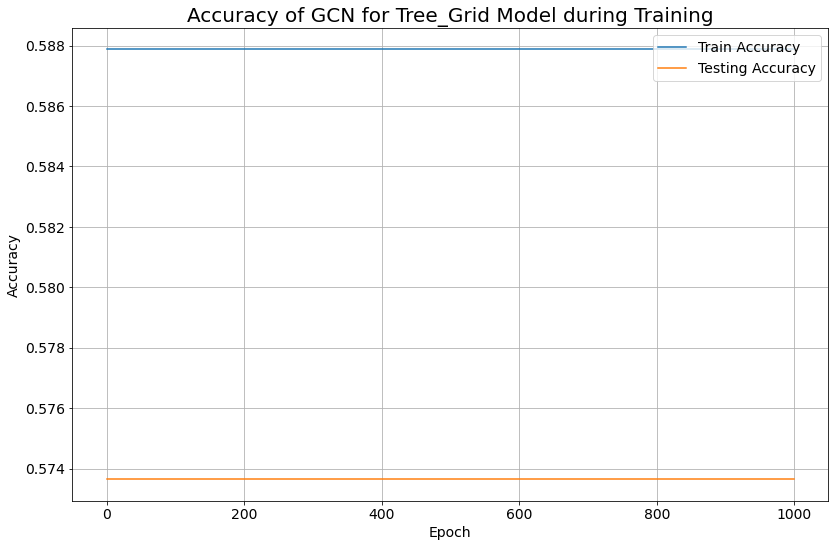

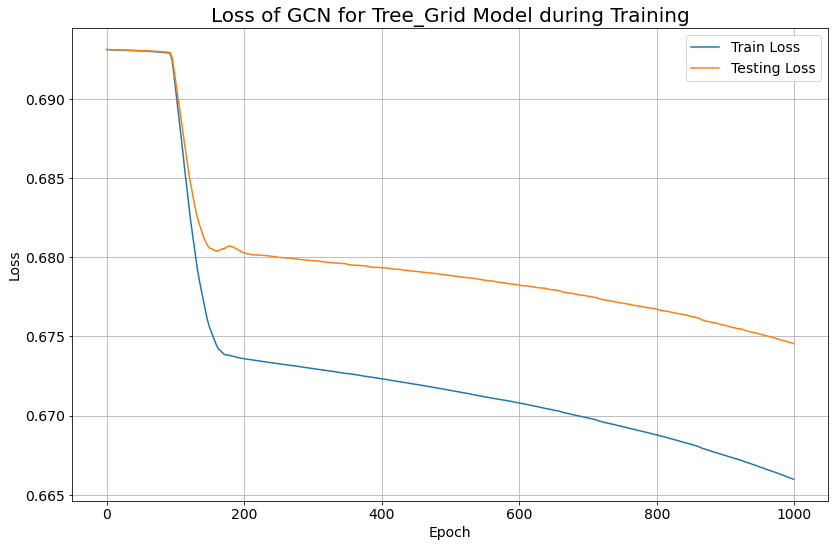

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 30, n_clustering: 4, concept_emb_size: 5


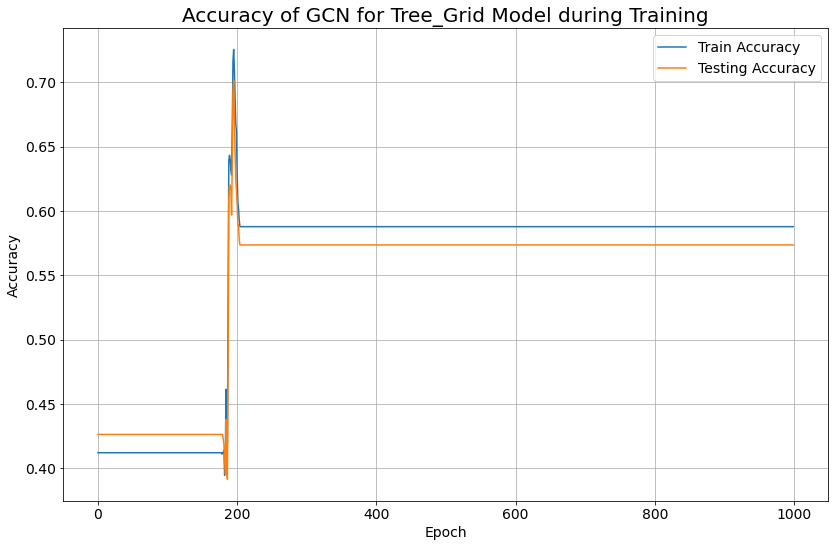

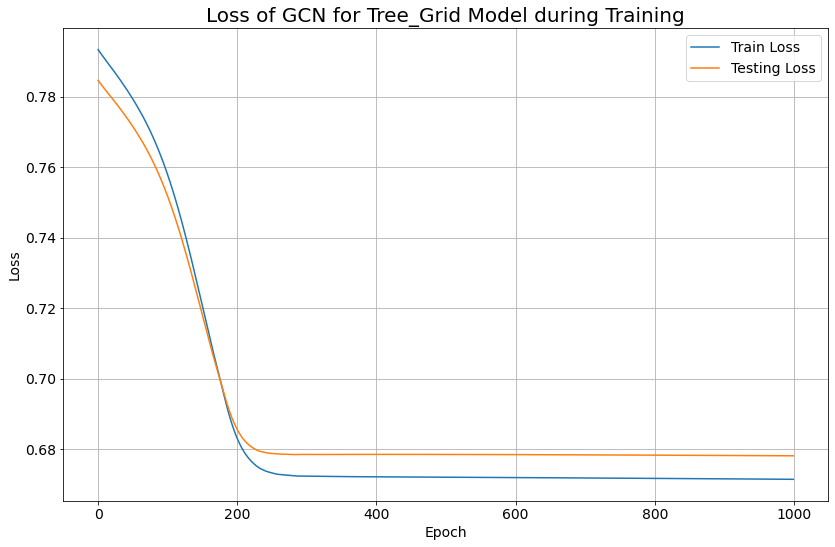

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 30, n_clustering: 4, concept_emb_size: 10


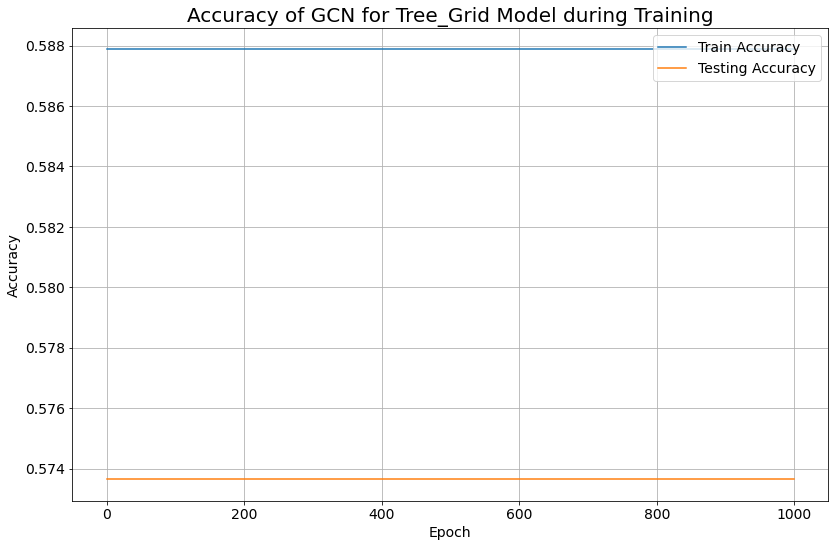

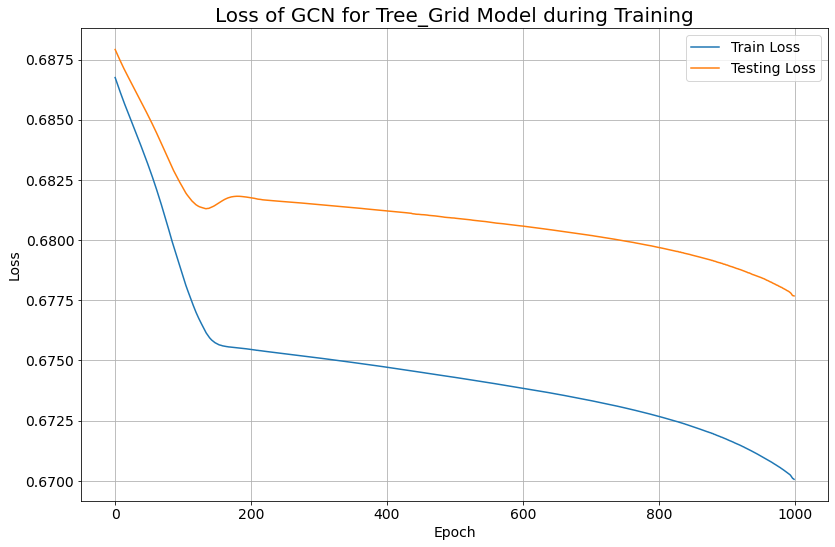

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------


START EXPERIMENT-----------------------------------------

lr: 0.0001, hu: 30, n_clustering: 4, concept_emb_size: 20


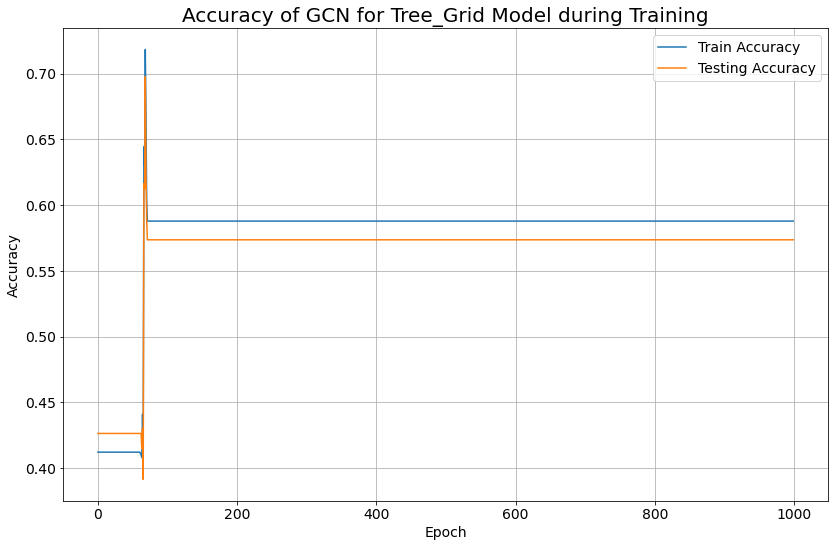

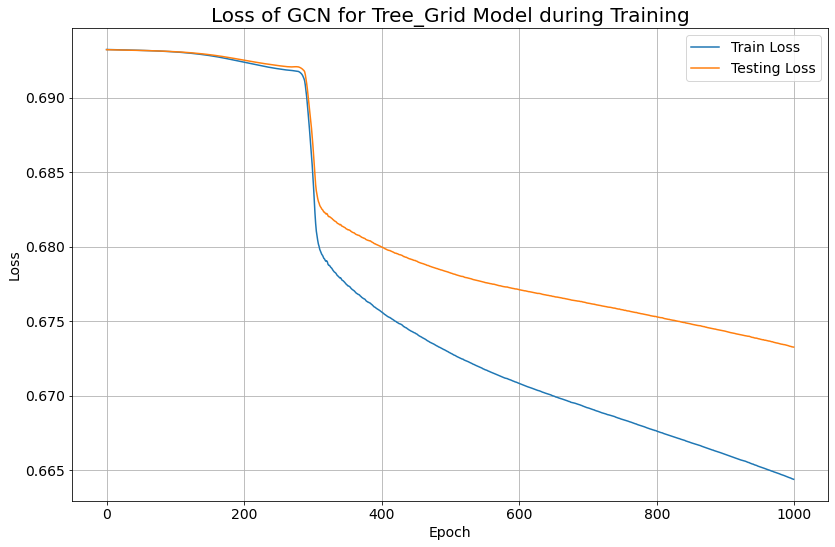

Explanation class 0: None - acc. = 0.0000 - compl. = 0.0000
Explanation class 1: None - acc. = 0.0000 - compl. = 0.0000

END EXPERIMENT-------------------------------------------



In [5]:
# run multiple times for confidence interval - seeds generated using Google's random number generator
seed = 42

seed_everything(seed)
lr_values = [0.01, 0.001, 0.0001]
hidden_units_values = [10, 20, 30]
n_clustering_values = [2, 3, 4]
concept_emb_size_values = [5, 10, 20]

# load data
G, labels = data_utils.load_syn_data(DATASET_NAME, path_prefix="../")
data = data_utils.prepare_syn_data(G, labels, TRAIN_TEST_SPLIT, if_adj=True)

for lr in lr_values:
    for hidden_units in hidden_units_values:
        for n_clustering in n_clustering_values:
            for concept_emb_size in concept_emb_size_values:
                print("\nSTART EXPERIMENT-----------------------------------------\n")
                print(f"lr: {lr}, hu: {hidden_units}, n_clustering: {n_clustering}, concept_emb_size: {concept_emb_size}")

                path = os.path.join("..", "..", "output", "grid_search", DATASET_NAME, f"seed_{seed}_lr_{lr}_hu_{hidden_units}_cluster_{n_clustering}_emb_{concept_emb_size}")
                data_utils.create_path(path)

                run_grid_search(data, lr, hidden_units, n_clustering, concept_emb_size, path)

                print("\nEND EXPERIMENT-------------------------------------------\n")